# Mutation Variation

### KEYS

In [1]:
import json
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import iqr
stats.junk = lambda chisq, df: stats.chi2.sf(chisq, df)
import csv
import gffpandas.gffpandas as gffpd
import scikit_posthocs as sp
import itertools

#### LIST OF SAMPLE NAMES ####
CC2344 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

CC2344_list = [ i + '-rep1' for i in CC2344] + [ i + '-rep2' for i in CC2344] + [ i + '-rep3' for i in CC2344]
CC2931_list = [ i + '-rep1' for i in CC2931] + [ i + '-rep2' for i in CC2931] + [ i + '-rep3' for i in CC2931]
    
CC2344_rep = [ i + '-rep1' for i in CC2344[1:]] + [ i + '-rep2' for i in CC2344[1:]] + [ i + '-rep3' for i in CC2344[1:]]
CC2931_rep = [ i + '-rep1' for i in CC2931[1:]] + [ i + '-rep2' for i in CC2931[1:]] + [ i + '-rep3' for i in CC2931[1:]]

#### DATAFRAME RECORDING THE GENERATION TIME PER SAMPLE ####
dic_gen = {'CC2344-L1': 912.356113, 'CC2344-L10': 917.129696, 'CC2344-L11': 889.5859554, 'CC2344-L12': 950.0552184, 'CC2344-L13': 961.4186064,
           'CC2344-L14': 931.447801, 'CC2344-L15': 946.6643063, 'CC2344-L2': 923.1078072, 'CC2344-L3': 1000.469526, 'CC2344-L4': 808.9505794,
           'CC2344-L5': 957.6380465, 'CC2344-L6': 970.6307256, 'CC2344-L7': 990.9451516, 'CC2344-L8': 1009.966123, 'CC2344-L9': 901.0619061, 
           'CC2931-L1': 1050.109001, 'CC2931-L10': 1097.978141, 'CC2931-L11': 1021.13559, 'CC2931-L13': 1041.362593, 
           'CC2931-L14': 1016.111493, 'CC2931-L15': 1052.540951, 'CC2931-L2': 1056.765369, 'CC2931-L3': 1000.399127, 'CC2931-L4': 1011.411706,
           'CC2931-L5': 993.8603657, 'CC2931-L6': 1083.095655, 'CC2931-L7': 1067.34507, 'CC2931-L9': 1079.236285}
generations = pd.Series(dic_gen)

#### DATAFRAME RECORDING THE NUMBER OF MUTATIONS PER SAMPLE ####
dic_mut = {'CC2344-L1': 396, 'CC2344-L10': 59, 'CC2344-L11': 46, 'CC2344-L12': 74, 'CC2344-L13': 49, 'CC2344-L14': 46, 'CC2344-L15': 53, 
           'CC2344-L2': 80, 'CC2344-L3': 63, 'CC2344-L4': 24, 'CC2344-L5': 68, 'CC2344-L6': 38, 'CC2344-L7': 45, 'CC2344-L8': 75, 'CC2344-L9': 27, 
           'CC2931-L1': 89, 'CC2931-L10': 87, 'CC2931-L11': 85, 'CC2931-L13': 97, 'CC2931-L14': 79, 'CC2931-L15': 141, 'CC2931-L2': 123,
           'CC2931-L3': 52, 'CC2931-L4': 100, 'CC2931-L5': 335, 'CC2931-L6': 84, 'CC2931-L7': 72, 'CC2931-L9': 113}
mutations = pd.Series(dic_mut)

#### TAKING THE AVERAGE GENERATION TIME AND NUMBER OF MUTATIONS ####
CC2344_gen_mean = sum([dic_gen[i] for i in CC2344[1:]])/len([dic_gen[i] for i in CC2344[1:]])
CC2931_gen_mean = sum([dic_gen[i] for i in CC2931[1:]])/len([dic_gen[i] for i in CC2931[1:]])

CC2344_mut_mean = sum([dic_mut[i] for i in CC2344[1:]])/len([dic_mut[i] for i in CC2344[1:]])
CC2931_mut_mean = sum([dic_mut[i] for i in CC2931[1:]])/len([dic_mut[i] for i in CC2931[1:]])

### OBSERVED VS EXPECTED MUTATIONS

In [2]:
CC2931_mut_chi = pd.DataFrame()
CC2344_mut_chi = pd.DataFrame()

## Based on the generation time and the known mutation rate, how many mutations do we expect to see
## Mutation rate: 11.5 x 10^(-10) site/generation
## Genome size: 111 x 10^(6) bases

########################################################
## CHI-SQUARE ANALYSIS (actual vs expected mutations) ##
########################################################

for i in CC2931[1:]:
    CC2931_mut_chi.at[i, 'exp_mut'] = generations[i]*(11.5*10**(-10))*(111*10**(6))
    CC2931_mut_chi.at[i, 'mut'] = dic_mut[i]
    CC2931_mut_chi.at[i, 'stat'] = (CC2931_mut_chi.at[i, 'mut'] - CC2931_mut_chi.at[i, 'exp_mut'])**2/(CC2931_mut_chi.at[i, 'exp_mut'])
CC2931_mut_chi['chi_square'] = CC2931_mut_chi['stat'].sum()
CC2931_mut_chi['chi_sq_min_outliers'] = CC2931_mut_chi['stat'].sum() - CC2931_mut_chi.at['CC2931-L5','exp_mut']
CC2931_mut_chi['p-val_1'] = stats.junk(CC2931_mut_chi['chi_square'], len(CC2931_mut_chi.index.values))
CC2931_mut_chi['p-val_2'] = stats.junk(CC2931_mut_chi['chi_sq_min_outliers'], len(CC2931_mut_chi.index.values) - 1)

for i in CC2344[1:]:
    CC2344_mut_chi.at[i, 'exp_mut'] = generations[i]*(11.5*10**(-10))*(111*10**(6))
    CC2344_mut_chi.at[i, 'mut'] = dic_mut[i]
    CC2344_mut_chi.at[i, 'stat'] = (CC2344_mut_chi.at[i, 'mut'] - CC2344_mut_chi.at[i, 'exp_mut'])**2/(CC2344_mut_chi.at[i, 'exp_mut'])
CC2344_mut_chi['chi_square'] = CC2344_mut_chi['stat'].sum()
CC2344_mut_chi['chi_sq_min_outliers'] = CC2344_mut_chi['stat'].sum() - CC2344_mut_chi.at['CC2344-L1','exp_mut']
CC2344_mut_chi['p-val_1'] = stats.junk(CC2344_mut_chi['chi_square'], len(CC2344_mut_chi.index.values))
CC2344_mut_chi['p-val_2'] = stats.junk(CC2344_mut_chi['chi_sq_min_outliers'], len(CC2344_mut_chi.index.values) - 1)

### CLEANING UP THE DATA PROVIDED FROM DESEQ2

In [2]:
# #### CLEANING UP NOISEQ FILTERED DESEQ2 NORMALIZED DATA ####
# CC2931_raw = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_noiseq_filtered_cqn_normalized_samescale.txt', delimiter = "\t")
# CC2344_raw = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_noiseq_filtered_cqn_normalized_samescale.txt', delimiter = "\t")

# #### REDO COLUMN LABELS ####
# columns = CC2931_raw.columns.str.replace('.','-', regex = True)
# columns = columns.str.replace('_','-', regex = True)
# columns = columns.str.split('-')
# CC2931_raw.columns = [columns[i][1] + '-' + columns[i][2] + '-' + columns[i][3] for i in range(len(columns))]

# columns = CC2344_raw.columns.str.replace('.','-', regex = True)
# columns = columns.str.replace('_','-', regex = True)
# columns = columns.str.split('-')
# CC2344_raw.columns = [columns[i][1] + '-' + columns[i][2] + '-' + columns[i][3] for i in range(len(columns))]

# #### TAKING THE MEAN OF THE ANCESTRAL LINES ####
# CC2931_raw['CC2931-ANC'] = CC2931_raw[['CC2931-ANC-rep1', 'CC2931-ANC-rep2', 'CC2931-ANC-rep3']].mean(axis = 1)
# CC2344_raw['CC2344-ANC'] = CC2344_raw[['CC2344-ANC-rep1', 'CC2344-ANC-rep2', 'CC2344-ANC-rep3']].mean(axis = 1)

# CC2931_raw.drop(['CC2931-ANC-rep1', 'CC2931-ANC-rep2', 'CC2931-ANC-rep3'], inplace=True, axis=1)
# CC2344_raw.drop(['CC2344-ANC-rep1', 'CC2344-ANC-rep2', 'CC2344-ANC-rep3'], inplace=True, axis=1)

# ###################################
# ## EXPORTING FILTERED RAW COUNTS ##
# ###################################
# CC2931_raw.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_raw', sep = "\t", index = True, header = True)
# CC2344_raw.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_raw', sep = "\t", index = True, header = True)

###################################################################
#### NUMBER OF GENES WITH EXPRESSION - ZERO EXPRESSION REMOVED ####
###################################################################
# no_expression = pd.DataFrame()
# CC2931_raw = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_raw', delimiter = '\t', index_col = 'Unnamed: 0')
# CC2344_raw = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_raw', delimiter = '\t', index_col = 'Unnamed: 0')
# CC2931_raw = CC2931_raw.replace(0, np.nan, regex = True)
# CC2344_raw = CC2344_raw.replace(0, np.nan, regex = True)

# for i in CC2931_raw.columns:
#     no_expression.at[i, 'no_zeros'] = len(CC2931_raw.dropna(subset = [i]))/len(CC2931_raw[i])
# for i in CC2344_raw.columns:
#     no_expression.at[i, 'no_zeros'] = len(CC2344_raw.dropna(subset = [i]))/len(CC2344_raw[i])
# no_expression['no_zeros'].mean() ## 0.734

### IDENTIFYING LOW AND HIGH EXPRESSION GENES

In [3]:
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

#### OPENING FILES ####
CC2344_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t', index_col = 'index')
CC2931_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t', index_col = 'index')

#### 10TH PERCENTILE - LOW EXPRESSION GENES ####
CC2931_ANC_10 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 10)
CC2344_ANC_10 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 10)

#### 90TH PERCENTILE - HIGH EXPRESSION GENES ####
CC2931_ANC_90 = np.percentile(CC2931_avg_fpkm['CC2931-ANC'], 90)
CC2344_ANC_90 = np.percentile(CC2344_avg_fpkm['CC2344-ANC'], 90)

#### ISOLATING HIGH/LOW EXPRESSION GENES IN ANCESTRAL LINES ####
CC2931_hi_exp = list(CC2931_avg_fpkm.loc[CC2931_avg_fpkm['CC2931-ANC'] >= CC2931_ANC_90].index.values)
CC2931_low_exp = list(CC2931_avg_fpkm.loc[CC2931_avg_fpkm['CC2931-ANC'] <= CC2931_ANC_10].index.values)

CC2344_hi_exp = list(CC2344_avg_fpkm.loc[CC2344_avg_fpkm['CC2344-ANC'] >= CC2344_ANC_90].index.values)
CC2344_low_exp = list(CC2344_avg_fpkm.loc[CC2344_avg_fpkm['CC2344-ANC'] <= CC2344_ANC_10].index.values)

#### ISOLATING HIGH/LOW EXPRESSION GENES IN MA LINES #####
HL_MAgenes = {}
for i in CC2344 + CC2931:
    if 'CC2344' in i:
        HL_MAgenes[i + "_low"] = list(CC2344_avg_fpkm.loc[CC2344_avg_fpkm[i] <= CC2344_ANC_10].index.values)
        HL_MAgenes[i + "_hi"] = list(CC2344_avg_fpkm.loc[CC2344_avg_fpkm[i] >= CC2344_ANC_90].index.values)
    if 'CC2931' in i:
        HL_MAgenes[i + "_low"] = list(CC2931_avg_fpkm.loc[CC2931_avg_fpkm[i] <= CC2931_ANC_10].index.values)
        HL_MAgenes[i + "_hi"] = list(CC2931_avg_fpkm.loc[CC2931_avg_fpkm[i] >= CC2931_ANC_90].index.values)
        
#### SHARED EXPRESSIONS ACROSS GENOTYPES ####
shared_high_expression = set.intersection(set(CC2931_hi_exp), set(CC2344_hi_exp))
shared_low_expression = set.intersection(set(CC2931_low_exp), set(CC2344_low_exp))

#### OVERLAPS BETWEEN HIGH AND LOW EXPRESSION ####
overlap_1 = set.intersection(set(CC2931_hi_exp), set(CC2344_low_exp))
overlap_2 = set.intersection(set(CC2931_low_exp), set(CC2344_hi_exp))

## LOG2FOLD 

In [28]:
CC2344 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

for i in ['CC2931_log2Fold', 'CC2344_log2Fold']:
    exec('{} = pd.DataFrame()'.format(i))

#### COMBINING LOG2FOLD CHANGES ACROSS GENOTYPES ####
for i in CC2931[1:]:
    CC2931_log2Fold[i] = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/genes_log2fold/' + i, delimiter = "\t")['log2FoldChange']
for i in CC2344[1:]:
    CC2344_log2Fold[i] = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/genes_log2fold/' + i, delimiter = "\t")['log2FoldChange']
    
CC2344_log2Fold['CC2344-ANC'] = 0
CC2931_log2Fold['CC2931-ANC'] = 0

#### EXPORTING LOG2FOLD VALUES ####
CC2344_log2Fold.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_log2Fold', sep = '\t', index = True, header = True)
CC2931_log2Fold.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_log2Fold', sep = '\t', index = True, header = True)

#### MEAN/MEDIAN/VARIANCE/SUM OF GENES PER SAMPLE ####
CC2344_log2Fold['mean'] = CC2344_log2Fold[CC2344[1:]].mean(axis = 1) 
CC2931_log2Fold['mean'] = CC2931_log2Fold[CC2931[1:]].mean(axis = 1)

CC2344_log2Fold['median'] = CC2344_log2Fold[CC2344[1:]].median(axis = 1) 
CC2931_log2Fold['median'] = CC2931_log2Fold[CC2931[1:]].median(axis = 1)

CC2344_log2Fold['var'] = CC2344_log2Fold[CC2344[1:]].var(axis = 1)
CC2931_log2Fold['var'] = CC2931_log2Fold[CC2931[1:]].var(axis = 1)

CC2344_log2Fold['sum'] = CC2344_log2Fold[CC2344[1:]].sum(axis = 1)
CC2931_log2Fold['sum'] = CC2931_log2Fold[CC2931[1:]].sum(axis = 1)

#### DEGS IN TRANSCRIPTION FACTORS ####
#######################################
conversion = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/v5.3_to_v5.6_to_v6.csv', delimiter = '\t')

DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',').reset_index()
DEGs = pd.melt(DEGs, id_vars = 'index', value_vars = DEGs.columns[1:])
DEGs = DEGs.dropna().rename(columns = {'variable':'sample'})

TF_1 = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/annotation_package/raw_anno/iTAK_transcription_factors.txt', delimiter = '\t')
TF_1.columns = ['CHR', 'Family', 'Sequence1', 'Sequence2']
TF_1['v5.5_gene'] = TF_1['CHR'].replace('.t[1-9].*','', regex = True)
TF_1 = TF_1.set_index('v5.5_gene').join(conversion.set_index('v5.5_gene')['v6']).reset_index()
TF_1 = TF_1.set_index('v6').join(DEGs.set_index('value')['sample']).drop(['Sequence1', 'Sequence2'], axis = 1)
print('TF_1 = '  + str(len(TF_1)))
subset_TF_1 = TF_1.dropna(subset = ['sample'])

TF_2 = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/annotation_package/raw_anno/PlantTFDB _transcription_factors.txt', delimiter = '\t')
TF_2.columns = ['CHR', 'GENE_ID', 'Family']
TF_2 = TF_2.set_index('GENE_ID').join(conversion.set_index('v5.5_gene')['v6']).reset_index()
TF_2 = TF_2.set_index('v6').join(DEGs.set_index('value')['sample'])
print('TF_2 = ' + str(len(TF_2)))
subset_TF_2 = TF_2.dropna(subset = ['sample'])

subset_TF_2 = subset_TF_2.rename(columns = {'index':'v5.5_gene'})

pd.concat([subset_TF_1, subset_TF_2]).drop_duplicates(keep='first')

TF_1 = 285
TF_2 = 265


,v5.5_gene,CHR,Family,sample
ChCC-v11000250m.g,Cre01.g004600,Cre01.g004600.t1.1,RWP-RK,CC2344-L6
ChCC-v11000741m.g,Cre01.g014050,Cre01.g014050.t1.2,C3H,CC2931-L14
ChCC-v11003118m.g,Cre02.g078831,Cre02.g078831.t1.1,CSD,CC2931-L11
ChCC-v11004331m.g,Cre02.g104700,Cre02.g104700.t1.2,SBP,CC2931-L13
ChCC-v11006158m.g,Cre03.g144747,Cre03.g144747.t1.1,MYB,CC2344-L6
...,...,...,...,...
ChCC-v11025855m.g,Cre12.g514400,Cre12.g514400.t2.1,MYB_related,CC2344-L4
ChCC-v11025855m.g,Cre12.g514400,Cre12.g514400.t2.1,MYB_related,CC2344-L10
ChCC-v11025855m.g,Cre12.g514400,Cre12.g514400.t2.1,MYB_related,CC2344-L11
ChCC-v11025855m.g,Cre12.g514400,Cre12.g514400.t2.1,MYB_related,CC2344-L12


### GB STRAINS - EXPRESSION VARIATION PER INCREASING SAMPLE SIZE

<AxesSubplot:xlabel='# of samples', ylabel='Mean Expression Variance'>

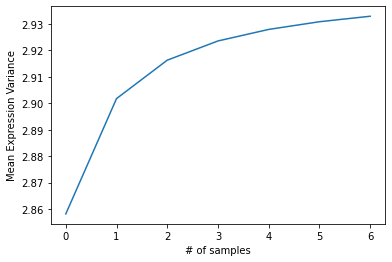

In [64]:
GB = ['GB117', 'GB119', 'GB49', 'GB141', 'GB66', 'GB57', 'GB13', 'GB123']
GB_log2Fold = pd.DataFrame()

#### COMBINING LOG2FOLD CHANGES ACROSS GENOTYPES ####
for i in GB:
    GB_log2Fold[i] = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/genes_log2fold/' + i, delimiter = "\t")['log2FoldChange']
    
#### EXPORTING LOG2FOLD VALUES ####
GB_log2Fold.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/GB_log2Fold', sep = '\t', index = True, header = True)

GB_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/GB_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
GB = ['GB117', 'GB49', 'GB141', 'GB66', 'GB57', 'GB13', 'GB123'] ## Everything relative to GB119

permutations_object = itertools.permutations(GB)
permutations_list = list(permutations_object)
GB_var= pd.DataFrame()

for a in range(len(permutations_list)):
    for i in range(7):
        df = GB_log2Fold[list(permutations_list[a][:i + 1])]
        extended_df = pd.melt(df, value_vars = list(permutations_list[a][:i + 1]))
        GB_var.at[a, str(i + 1)] = extended_df['value'].var() 

mean_expression_variance = pd.DataFrame(GB_var.mean(axis = 0), columns = ['Mean Expression Variance']).reset_index().rename(columns = {'index':'# of samples'})

sns.lineplot(data = mean_expression_variance, x = '# of samples', y = 'Mean Expression Variance')

### MUTATIONAL VARIANCE

ChCC-v11000010m.g         0.013255
ChCC-v11000011m.g         0.012447
ChCC-v11000015m.g         0.015175
ChCC-v11000021m.g         0.006599
ChCC-v11000022m.g         0.001114
                            ...   
gex.Cre10.g434726.t1.1    0.002144
gex.Cre12.g536301.t1.1    0.004205
gex.Cre14.g618926.t1.1    0.009765
gex.Cre16.g647901.t1.1    0.002872
gex.Cre17.g719792.t1.1    0.008810
Length: 15263, dtype: float64

ChCC-v11000010m.g         0.007054
ChCC-v11000011m.g         0.006774
ChCC-v11000015m.g         0.008019
ChCC-v11000021m.g         0.007453
ChCC-v11000022m.g         0.000723
                            ...   
gex.Cre03.g211857.t1.1    0.007625
gex.Cre10.g434726.t1.1    0.001560
gex.Cre12.g536301.t1.1    0.002705
gex.Cre14.g618926.t1.1    0.003839
gex.Cre16.g647901.t1.1    0.007498
Length: 14874, dtype: float64

'CC2344_LD_Vm_per_gen = 0.004942654198211583'

'CC2931_LD_Vm_per_gen = 0.0028540071079960236'

98.46924248552429 0.0 103.1201054995812 0.0
98.46924248552429 0.0 103.1201054995812 0.0


,CC2931_Vm_per_mut,CC2344_Vm_per_mut,CC2931_Vm_per_gen,CC2344_Vm_per_gen
median_low,0.015313,0.041928,0.003288,0.006812
median_high,0.002444,0.005022,0.000525,0.000816
variance_low,0.000220,0.001502,0.000010,0.000040
variance_high,0.000028,0.000287,0.000001,0.000008


'CC2344_Vm_per_mut = 0.022079676631206253'

'CC2931_Vm_per_mut = 0.009726152630559544'

'CC2344_Vm_per_gen = 0.0035869950335104595'

'CC2931_Vm_per_gen = 0.002088370423947658'

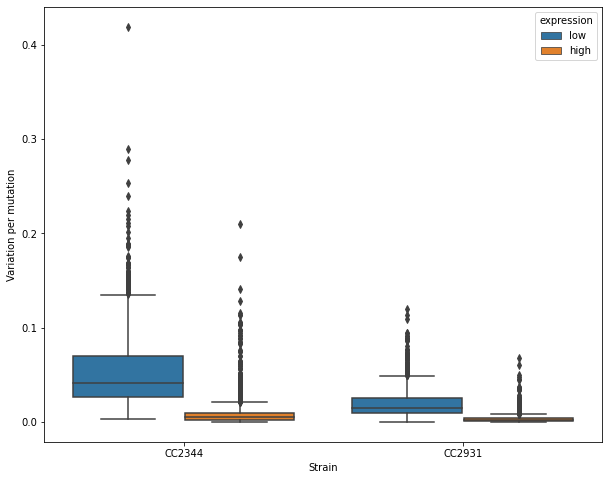

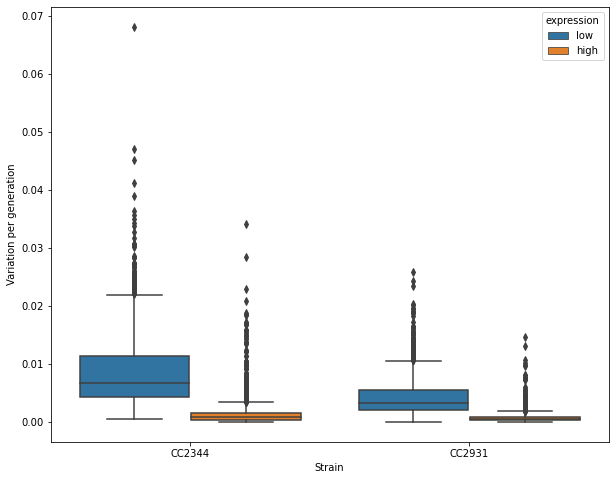

In [55]:
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

##### MUTATION VARIANCE - LOOP DESIGN #####
###########################################
CC2344_1 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15", 'CC2344-ANC']
CC2931_1 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15", "CC2931-ANC"]

CC2344_diff = pd.DataFrame()
for i in range(len(CC2344_1) - 1):
    a = (CC2344_log2Fold[CC2344_1[i]] - CC2344_log2Fold[CC2344_1[i+1]])**2
    CC2344_diff = pd.concat([CC2344_diff, a], axis = 1)
CC2344_diff = CC2344_diff.sum(axis = 1)/(len(CC2344_1) - 1)
CC2344_diff = 2 * CC2344_diff/CC2344_gen_mean

CC2931_diff = pd.DataFrame()
for i in range(len(CC2931_1) - 1):
    a = (CC2931_log2Fold[CC2931_1[i]] - CC2931_log2Fold[CC2931_1[i+1]])**2
    CC2931_diff = pd.concat([CC2931_diff, a], axis = 1)
CC2931_diff = CC2931_diff.sum(axis = 1)/(len(CC2931_1) - 1)
CC2931_diff = 2 * CC2931_diff/CC2931_gen_mean

display(CC2344_diff)
display(CC2931_diff)

#### MEDIAN EXPRESSION VARIATION PER MUTATION ####
display('CC2344_LD_Vm_per_gen = ' + str(CC2344_diff.median()))
display('CC2931_LD_Vm_per_gen = ' + str(CC2931_diff.median()))

########################################################################################################################
for i in ['CC2931_Vm', 'CC2344_Vm']:
    exec('{} = pd.DataFrame()'.format(i))

#### FINDING THE LOG2FOLD CHANGE OVER MA GENERATIONS (VARIANCE PER GENE) ####
CC2344_var = ((CC2344_log2Fold[CC2344] - 0)**2).sum(axis = 1)/len(CC2344)
CC2931_var = ((CC2931_log2Fold[CC2931] - 0)**2).sum(axis = 1)/len(CC2931)

CC2344_Vm['Vm_per_gen'] = 2 * CC2344_var/CC2344_gen_mean
CC2931_Vm['Vm_per_gen'] = 2 * CC2931_var/CC2931_gen_mean

#### FINDING THE LOG2FOLD CHANGE OVER MUTATIONS (VARIANCE PER GENE) ####
CC2344_Vm['Vm_per_mut'] = CC2344_var/CC2344_mut_mean
CC2931_Vm['Vm_per_mut'] = CC2931_var/CC2931_mut_mean

#### ADDING LOG2FOLD CHANGE MEAN TO VARIANCE PER GENE ####
CC2344_Vm = pd.concat([CC2344_log2Fold['mean'], CC2344_Vm], axis = 1)
CC2931_Vm = pd.concat([CC2931_log2Fold['mean'], CC2931_Vm], axis = 1)

CC2344_Vm.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/CC2344_mutational_variance.csv', sep = '\t', index = True, header = True)
CC2931_Vm.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/CC2931_mutational_variance.csv', sep = '\t', index = True, header = True)

###################################################################
#### MUTATIONAL VARIANCE - ISOLATING HIGH/LOW EXPRESSION GENES ####
###################################################################
Vm = ['Vm_per_mut', 'Vm_per_gen']
title = ['Variation per mutation', 'Variation per generation']
dic = {Vm[i]:title[i] for i in range(len(Vm))}
Vm_stat = pd.DataFrame(index = ['median_low', 'median_high', 'variance_low', 'variance_high'])

for i in Vm:
    #### CREATING DATAFRAME ####
    for a in ['CC2344_high', 'CC2344_low', 'CC2931_high', 'CC2931_low']:
        exec('{} = pd.DataFrame()'.format(a))
    #### ISOLATING HIGH/LOW EXPRESSION GENES ####
    CC2344_high[i] = CC2344_Vm[i].loc[CC2344_hi_exp].values.tolist()
    CC2344_high['expression'] = 'high'
    CC2344_high['id'] = 'CC2344'
    CC2344_low[i] = CC2344_Vm[i].loc[CC2344_low_exp].values.tolist()
    CC2344_low['expression'] = 'low'
    CC2344_low['id'] = 'CC2344'

    CC2931_high[i] = CC2931_Vm[i].loc[CC2931_hi_exp].values.tolist()
    CC2931_high['expression'] = 'high'
    CC2931_high['id'] = 'CC2931'
    CC2931_low[i] = CC2931_Vm[i].loc[CC2931_low_exp].values.tolist()
    CC2931_low['expression'] = 'low'
    CC2931_low['id'] = 'CC2931'
    combined_Vm = pd.concat([CC2344_low, CC2344_high, CC2931_low, CC2931_high], axis = 0)
    #### SEABORN ####
    plt.figure(figsize = (10,8))
    sns.boxplot(data = combined_Vm, x = 'id', y = i, hue = 'expression')
#     plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.ylabel(dic[i])
    plt.xlabel('Strain')
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/boxplots_mut_var/' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    #### BRUNNER MUNZEL TEST ####
    CC2344_ts, CC2344_p = scipy.stats.brunnermunzel(CC2344_high[i].values.tolist(), CC2344_low[i].values.tolist(), alternative = 'less')
    CC2931_ts, CC2931_p = scipy.stats.brunnermunzel(CC2931_high[i].values.tolist(), CC2931_low[i].values.tolist(), alternative = 'less')
    print(CC2344_ts, CC2344_p.round(5), CC2931_ts, CC2931_p.round(5))
    
    #### VARIANCE ####
    CC2344_Vm_subset = combined_Vm.loc[combined_Vm['id'] == 'CC2344']
    CC2344_Vm_low = CC2344_Vm_subset.loc[CC2344_Vm_subset['expression'] == 'low']
    CC2344_Vm_high = CC2344_Vm_subset.loc[CC2344_Vm_subset['expression'] == 'high']

    CC2931_Vm_subset = combined_Vm.loc[combined_Vm['id'] == 'CC2931']
    CC2931_Vm_low = CC2931_Vm_subset.loc[CC2931_Vm_subset['expression'] == 'low']
    CC2931_Vm_high = CC2931_Vm_subset.loc[CC2931_Vm_subset['expression'] == 'high']

    Vm_stat.at['median_low', 'CC2931_' + i] = CC2931_Vm_low[i].median()
    Vm_stat.at['median_low', 'CC2344_' + i] = CC2344_Vm_low[i].median()
    Vm_stat.at['median_high', 'CC2931_' + i] = CC2931_Vm_high[i].median()
    Vm_stat.at['median_high', 'CC2344_' + i] = CC2344_Vm_high[i].median()

    Vm_stat.at['variance_low', 'CC2931_' + i] = CC2931_Vm_low[i].var()
    Vm_stat.at['variance_low', 'CC2344_' + i] = CC2344_Vm_low[i].var()
    Vm_stat.at['variance_high', 'CC2931_' + i] = CC2931_Vm_high[i].var()
    Vm_stat.at['variance_high', 'CC2344_' + i] = CC2344_Vm_high[i].var()

display(Vm_stat)

#### MEDIAN EXPRESSION VARIATION PER MUTATION ####
display('CC2344_Vm_per_mut = ' + str(CC2344_Vm['Vm_per_mut'].median()))
display('CC2931_Vm_per_mut = ' + str(CC2931_Vm['Vm_per_mut'].median()))

#### MEDIAN EXPRESSION VARIATION PER GENERATION ####
display('CC2344_Vm_per_gen = ' + str(CC2344_Vm['Vm_per_gen'].median()))
display('CC2931_Vm_per_gen = ' + str(CC2931_Vm['Vm_per_gen'].median()))


### BOOTSTRAPPING

0.0
0.0


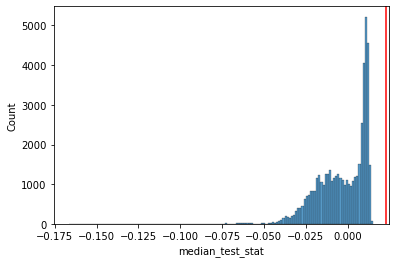

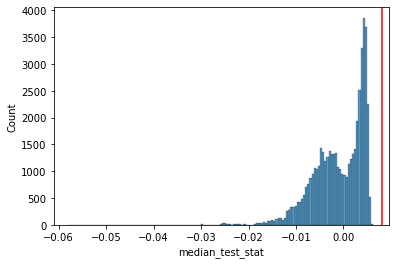

In [17]:
#### CC2344 ####
for i in ['Vm_per_mut', 'Vm_per_gen']:
    CC2344_high[i] = CC2344_Vm[i].loc[CC2344_hi_exp].values.tolist()
    CC2344_low[i] = CC2344_Vm[i].loc[CC2344_low_exp].values.tolist()
    x = CC2344_high[i].values.tolist()
    y = CC2344_low[i].values.tolist()
    
    #### OBSERVED TEST STATISTIC ####
    obs_median_high = np.median(x)
    obs_median_low = np.median(y)
    obs_test_statistic = obs_median_low - obs_median_high

    test_statistics = []
    for e in range(50000):
        a = np.random.choice(x + y, len(x + y), replace=True, p=None)
        median_high = np.median(a[len(x)])
        median_low = np.median(a[len(x):len(x+y)])
        test_statistics.append(median_low - median_high)

    histplot = pd.DataFrame({'median_test_stat':test_statistics})
    plt.figure()
    mut_var_median = sns.histplot(data = histplot, x = 'median_test_stat')
    plt.axvline(obs_test_statistic, color = 'red')
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/bootstrapping/CC2344_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    pvalue = (histplot.loc[histplot['median_test_stat'] >= obs_test_statistic].size)/histplot.size
    mut_var_median
    print(pvalue.round(5))
    
#### CC2931 ####
for i in ['Vm_per_mut', 'Vm_per_gen']:
    CC2931_high[i] = CC2931_Vm[i].loc[CC2931_hi_exp].values.tolist()
    CC2931_low[i] = CC2931_Vm[i].loc[CC2931_low_exp].values.tolist()
    x = CC2931_high[i].values.tolist()
    y = CC2931_low[i].values.tolist()
    
    #### OBSERVED TEST STATISTIC ####
    obs_median_high = np.median(x)
    obs_median_low = np.median(y)
    obs_test_statistic = obs_median_low - obs_median_high

    test_statistics = []
    for e in range(50000):
        a = np.random.choice(x + y, len(x + y), replace=True, p=None)
        median_high = np.median(a[len(x)])
        median_low = np.median(a[len(x):len(x+y)])
        test_statistics.append(median_low - median_high)

    histplot = pd.DataFrame({'median_test_stat':test_statistics})
    plt.figure()
    mut_var_median = sns.histplot(data = histplot, x = 'median_test_stat')
    plt.axvline(obs_test_statistic, color = 'red')
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/bootstrapping/CC2931_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    pvalue = (histplot.loc[histplot['median_test_stat'] >= obs_test_statistic].size)/histplot.size
    mut_var_median
    print(pvalue.round(5))

### PLOTS

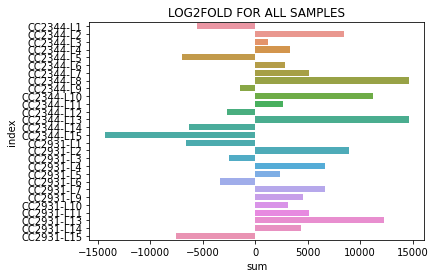

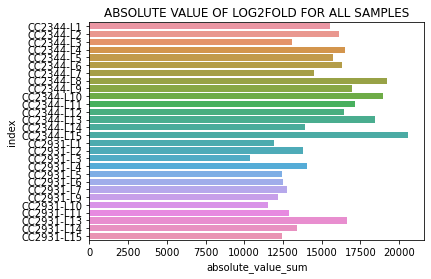

In [22]:
#### HISTOGRAM OF THE MEAN/MEDIAN ####
sns.histplot(CC2344_log2Fold['mean'])
sns.histplot(CC2344_log2Fold['median'])
plt.xlim(0, 12)
plt.title('CC2344 - The mean/median log2fold change of all samples')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/CC2344_allsamples_mean_and_median.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure()
sns.histplot(CC2931_log2Fold['mean'])
sns.histplot(CC2931_log2Fold['median'])
plt.xlim(0, 12)
plt.title('CC2931 - The mean/median log2fold change of all samples')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/CC2931_allsamples_mean_and_median.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### HISTOGRAM OF THE LOG2FOLD OF EACH GENE PER MA LINE OF A GENOTYPE ####
CC2344_L2F = CC2344_log2Fold.drop(['mean', 'median', 'var', 'sum'], axis = 1)
CC2931_L2F = CC2931_log2Fold.drop(['mean', 'median', 'var', 'sum'], axis = 1)

for i in CC2344[1:]:
    plt.figure(i)
    sns.histplot(CC2344_L2F[i])
    plt.xlim(-6, 6)
    plt.axvline(0, color = 'red')
    plt.title(i)
    plt.xlabel('log2fold')
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/histogram/histogram_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')


for i in CC2931[1:]:
    plt.figure(i)
    sns.histplot(CC2931_L2F[i])
    plt.xlim(-6, 6)
    plt.axvline(0, color = 'red')
    plt.title(i)
    plt.xlabel('log2fold')
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/histogram/histogram_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
#### SUM OF LOG2FOLD ACROSS SAMPLES ####
sum_FC = pd.DataFrame(index = CC2344[1:] + CC2931[1:])
for i in list(sum_FC.index.values):
    if 'CC2344' in i:
        sum_FC.at[i, 'sum'] = CC2344_log2Fold[i].sum()
    if 'CC2931' in i:
        sum_FC.at[i, 'sum'] = CC2931_log2Fold[i].sum()
sum_FC = sum_FC.reset_index()
sns.barplot(data = sum_FC, y = 'index', x = 'sum')
plt.title('LOG2FOLD FOR ALL SAMPLES')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/all_samples_FC.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### SUM OF ABSOLUTE VALUE LOG2FOLD ACROSS SAMPLES ####
CC2344_sum_per_mut = CC2344_sum_per_mut.reset_index()
CC2931_sum_per_mut = CC2931_sum_per_mut.reset_index()
absval_sum_FC = pd.DataFrame(index = list(CC2344_sum_per_mut['index']) + list(CC2931_sum_per_mut['index']))
CC2344_sum_per_mut.set_index('index', inplace = True)
CC2931_sum_per_mut.set_index('index', inplace = True)
for i in list(absval_sum_FC.index.values):
    if 'CC2344' in i:
        absval_sum_FC.at[i, 'absolute_value_sum'] = CC2344_sum_per_mut.at[i, 'absval_sum']
    if 'CC2931' in i:
        absval_sum_FC.at[i, 'absolute_value_sum'] = CC2931_sum_per_mut.at[i, 'absval_sum']
absval_sum_FC = absval_sum_FC.reset_index()
plt.figure()
sns.barplot(data = absval_sum_FC, x = 'absolute_value_sum', y = 'index')
plt.title('ABSOLUTE VALUE OF LOG2FOLD FOR ALL SAMPLES')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/all_samples_absolute_value_FC.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### PLOT OF SUM OF LOG2FOLD CHANGE PER GENERATION/MUTATION

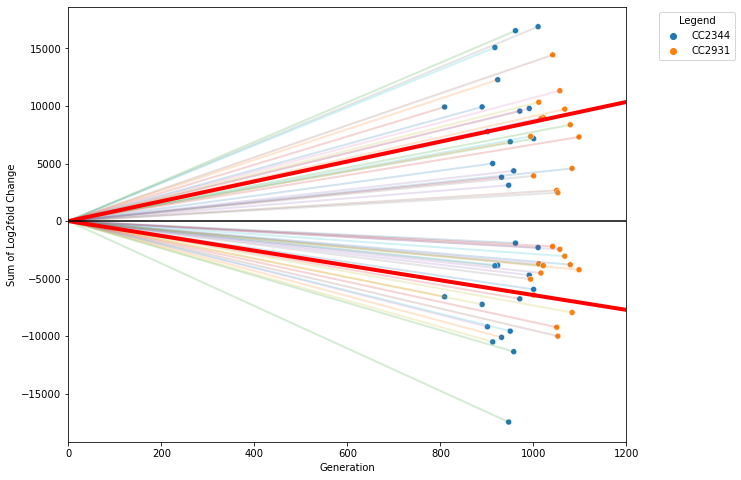

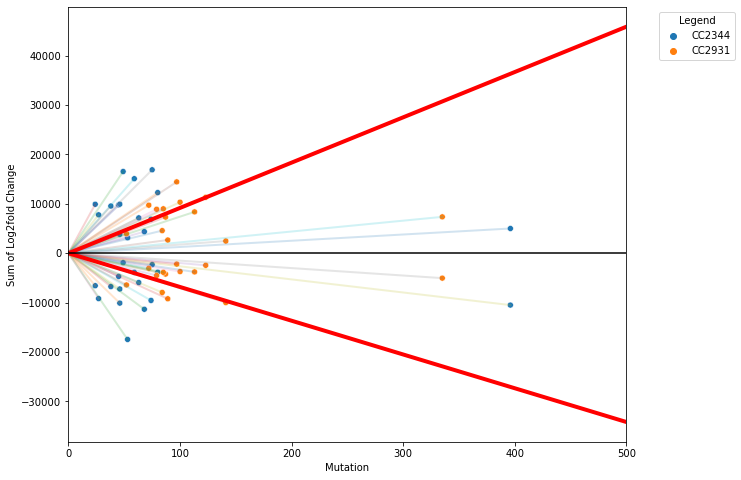

In [15]:
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

CC2344_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
CC2931_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')

L2F_sum = pd.DataFrame()
for i in CC2344 + CC2931:
    if 'CC2344' in i:
        positive_sum = CC2344_log2Fold[i].loc[CC2344_log2Fold[i] > 0].sum()
        negative_sum = CC2344_log2Fold[i].loc[CC2344_log2Fold[i] < 0].sum()
        L2F_sum.at[i, 'positive_sum'] = positive_sum
        L2F_sum.at[i, 'negative_sum'] = negative_sum
        L2F_sum.at[i, 'generation'] = dic_gen[i]
        L2F_sum.at[i, 'mutation'] = dic_mut[i]
    if 'CC2931' in i:
        positive_sum = CC2931_log2Fold[i].loc[CC2931_log2Fold[i] > 0].sum()
        negative_sum = CC2931_log2Fold[i].loc[CC2931_log2Fold[i] < 0].sum()
        L2F_sum.at[i, 'positive_sum'] = positive_sum
        L2F_sum.at[i, 'negative_sum'] = negative_sum
        L2F_sum.at[i, 'generation'] = dic_gen[i]
        L2F_sum.at[i, 'mutation'] = dic_mut[i]
        
mean_summary = L2F_sum.mean(axis = 0)
L2F_sum = L2F_sum.reset_index()

for i in L2F_sum.index.values:
    if 'CC2344' in L2F_sum.at[i, 'index']:
        L2F_sum.at[i, 'sample'] = 'CC2344'
    if 'CC2931' in L2F_sum.at[i, 'index']:
        L2F_sum.at[i, 'sample'] = 'CC2931'

plt.figure(figsize = (10, 8))
sns.scatterplot(data = L2F_sum, x = 'generation', y = 'positive_sum', hue = 'sample', legend = False)
plt.ylabel('Sum of Log2fold Change')
for i in L2F_sum.index.values:
    plt.plot([0, L2F_sum.at[i, 'generation']], [0, L2F_sum.at[i, 'positive_sum']], linewidth=2, alpha = 0.2)
slope = mean_summary['positive_sum']/mean_summary['generation']
plt.plot([0, 1200], [0, slope*1200], color = 'red', linewidth = 4)

sns.scatterplot(data = L2F_sum, x = 'generation', y = 'negative_sum', hue = 'sample')
plt.xlabel('Generation')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = 'Legend')
for i in L2F_sum.index.values:
    plt.plot([0, L2F_sum.at[i, 'generation']], [0, L2F_sum.at[i, 'negative_sum']], linewidth=2, alpha = 0.2)
slope = mean_summary['negative_sum']/mean_summary['generation']
plt.plot([0, 1200], [0, slope*1200], color = 'red', linewidth = 4)
plt.xlim(0, 1200)
plt.axhline(0, color = 'black')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/L2F_sum_per_generation.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure(figsize = (10,8))
sns.scatterplot(data = L2F_sum, x = 'mutation', y = 'positive_sum', hue = 'sample', legend = False)
plt.ylabel('Sum of Log2fold Change')
for i in L2F_sum.index.values:
    plt.plot([0, L2F_sum.at[i, 'mutation']], [0, L2F_sum.at[i, 'positive_sum']], linewidth=2, alpha = 0.2)
slope = mean_summary['positive_sum']/mean_summary['mutation']
plt.plot([0, 500], [0, slope*500], color = 'red', linewidth = 4)
sns.scatterplot(data = L2F_sum, x = 'mutation', y = 'negative_sum', hue = 'sample')
plt.xlabel('Mutation')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = 'Legend')
for i in L2F_sum.index.values:
    plt.plot([0, L2F_sum.at[i, 'mutation']], [0, L2F_sum.at[i, 'negative_sum']], linewidth=2, alpha = 0.2)
slope = mean_summary['negative_sum']/mean_summary['mutation']
plt.plot([0, 500], [0, slope*500], color = 'red', linewidth = 4)
plt.xlim(0, 500)
plt.axhline(0, color = 'black')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/L2F_sum_per_mutation.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### PLOT OF SUM OF LOG2FOLD CHANGE (DEGs) PER GENERATION/MUTATION

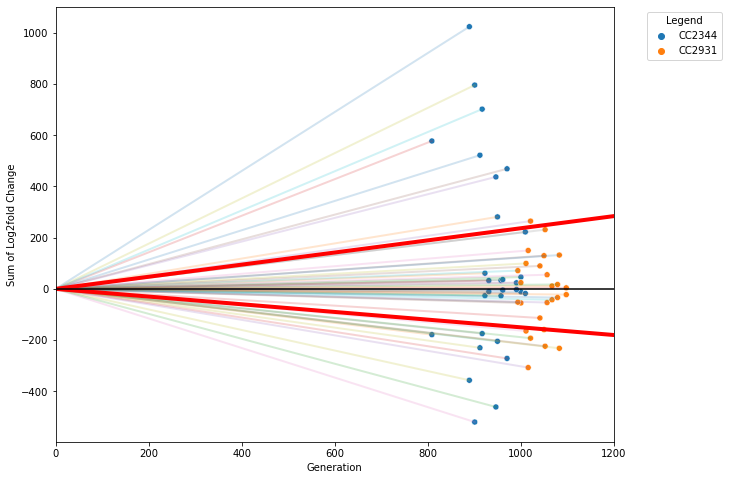

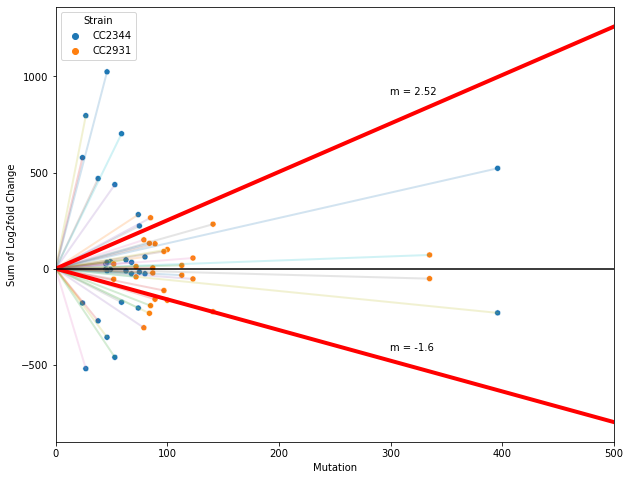

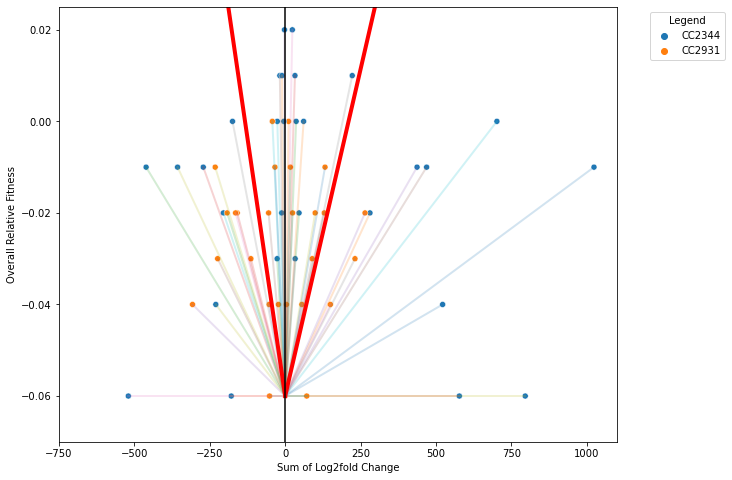

In [16]:
#### LISTS ####
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
total = CC2344 + CC2931

CC2344_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
CC2931_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')

fitness = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/mutation_info/Mutation_Fitness.txt', delimiter = '\t')
fitness = fitness.replace('_', '-L', regex = True)
fitness = fitness.loc[fitness['Sample'].isin(CC2344 + CC2931)].rename(columns = {'Average_realtive':'Average_relative'}).set_index('Sample')

DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',')
DEGs = DEGs.reset_index()
DEGs = pd.melt(DEGs, id_vars = 'index', value_vars = DEGs.columns[1:])
DEGs = DEGs.dropna().drop(columns = ['index'])

for i in list(DEGs.index.values):
    DEGs.at[i, 'sample'] = DEGs.at[i, 'variable']

CC2344_DEGs = DEGs.loc[DEGs['sample'].isin(CC2344)]
CC2931_DEGs = DEGs.loc[DEGs['sample'].isin(CC2931)]

DEGs = pd.concat([CC2344_DEGs, CC2931_DEGs])

for i in list(DEGs.index.values):
    if 'CC2344' in DEGs.at[i, 'sample']:
        DEGs.at[i, 'L2F'] = CC2344_log2Fold.at[DEGs.at[i, 'value'], DEGs.at[i, 'sample']]
    if 'CC2931' in DEGs.at[i, 'sample']:
        DEGs.at[i, 'L2F'] = CC2931_log2Fold.at[DEGs.at[i, 'value'], DEGs.at[i, 'sample']]

DEG_sum = pd.DataFrame(index = total)
for i in CC2344 + CC2931:
    if 'CC2344' in i:
        positive_sum = DEGs.loc[DEGs['sample'] == i].loc[DEGs['L2F'] > 0]['L2F'].sum()
        negative_sum = DEGs.loc[DEGs['sample'] == i].loc[DEGs['L2F'] < 0]['L2F'].sum()
        DEG_sum.at[i, 'positive_sum'] = positive_sum
        DEG_sum.at[i, 'negative_sum'] = negative_sum
        DEG_sum.at[i, 'generation'] = dic_gen[i]
        DEG_sum.at[i, 'mutation'] = dic_mut[i]
        DEG_sum.at[i, 'fitness'] = fitness.at[i, 'Average_relative']
    if 'CC2931' in i:
        positive_sum = DEGs.loc[DEGs['sample'] == i].loc[DEGs['L2F'] > 0]['L2F'].sum()
        negative_sum = DEGs.loc[DEGs['sample'] == i].loc[DEGs['L2F'] < 0]['L2F'].sum()
        DEG_sum.at[i, 'positive_sum'] = positive_sum
        DEG_sum.at[i, 'negative_sum'] = negative_sum
        DEG_sum.at[i, 'generation'] = dic_gen[i]
        DEG_sum.at[i, 'mutation'] = dic_mut[i]
        DEG_sum.at[i, 'fitness'] = fitness.at[i, 'Average_relative']

mean_summary = DEG_sum.mean(axis = 0)
DEG_sum = DEG_sum.reset_index()

for i in DEG_sum.index.values:
    if 'CC2344' in DEG_sum.at[i, 'index']:
        DEG_sum.at[i, 'sample'] = 'CC2344'
    if 'CC2931' in DEG_sum.at[i, 'index']:
        DEG_sum.at[i, 'sample'] = 'CC2931'

plt.figure(figsize = (10, 8))
sns.scatterplot(data = DEG_sum, x = 'generation', y = 'positive_sum', hue = 'sample', legend = False)
plt.ylabel('Sum of Log2fold Change')
for i in DEG_sum.index.values:
    plt.plot([0, DEG_sum.at[i, 'generation']], [0, DEG_sum.at[i, 'positive_sum']], linewidth=2, alpha = 0.2)
slope = mean_summary['positive_sum']/mean_summary['generation']
plt.plot([0, 1200], [0, slope*1200], color = 'red', linewidth = 4)
sns.scatterplot(data = DEG_sum, x = 'generation', y = 'negative_sum', hue = 'sample')
plt.xlabel('Generation')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = 'Legend')
for i in DEG_sum.index.values:
    plt.plot([0, DEG_sum.at[i, 'generation']], [0, DEG_sum.at[i, 'negative_sum']], linewidth=2, alpha = 0.2)
slope = mean_summary['negative_sum']/mean_summary['generation']
plt.plot([0, 1200], [0, slope*1200], color = 'red', linewidth = 4)
plt.xlim(0, 1200)
plt.axhline(0, color = 'black')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/DEG_sum_per_generation.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure(figsize = (10,8))
sns.scatterplot(data = DEG_sum, x = 'mutation', y = 'positive_sum', hue = 'sample', legend = False)
plt.ylabel('Sum of Log2fold Change')
for i in DEG_sum.index.values:
    plt.plot([0, DEG_sum.at[i, 'mutation']], [0, DEG_sum.at[i, 'positive_sum']], linewidth=2, alpha = 0.2)
slope = mean_summary['positive_sum']/mean_summary['mutation']
plt.text(300, slope*300 + 150, 'm = ' + str(slope.round(2)))
plt.plot([0, 500], [0, slope*500], color = 'red', linewidth = 4)
sns.scatterplot(data = DEG_sum, x = 'mutation', y = 'negative_sum', hue = 'sample')
plt.xlabel('Mutation')
for i in DEG_sum.index.values:
    plt.plot([0, DEG_sum.at[i, 'mutation']], [0, DEG_sum.at[i, 'negative_sum']], linewidth=2, alpha = 0.2)
slope = mean_summary['negative_sum']/mean_summary['mutation']
plt.text(300, slope*300 + 50, 'm = ' + str(slope.round(2)))
plt.plot([0, 500], [0, slope*500], color = 'red', linewidth = 4)
plt.xlim(0, 500)
plt.axhline(0, color = 'black')
plt.legend(title = 'Strain')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/DEG_sum_per_mutation.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### GRAPHING THE OVERALL FITNESS OF EACH MA LINE ####
plt.figure(figsize = (10,8))
sns.scatterplot(data = DEG_sum, x = 'positive_sum', y = 'fitness', hue = 'sample', legend = False)
plt.xlabel('Sum of Log2fold Change')
for i in DEG_sum.index.values:
    plt.plot([0, DEG_sum.at[i, 'positive_sum']], [-0.06, DEG_sum.at[i, 'fitness']], linewidth=2, alpha = 0.2)
slope = mean_summary['fitness']/mean_summary['positive_sum']
plt.plot([300, 0], [(-1)*slope*(300), -0.06], color = 'red', linewidth = 4)
sns.scatterplot(data = DEG_sum, x = 'negative_sum', y = 'fitness', hue = 'sample')
plt.ylabel('Overall Relative Fitness')
for i in DEG_sum.index.values:
    plt.plot([0, DEG_sum.at[i, 'negative_sum']], [-0.06, DEG_sum.at[i, 'fitness']], linewidth=2, alpha = 0.2)
slope = mean_summary['fitness']/mean_summary['negative_sum']
plt.plot([-190, 0], [(-1)*slope*(-190), -0.06], color = 'red', linewidth = 4)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = 'Legend')
plt.axvline(0, color = 'black')
plt.ylim(-0.07, 0.025)
plt.xlim(-750, 1100)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/DEG_sum_per_fitness.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

No handles with labels found to put in legend.


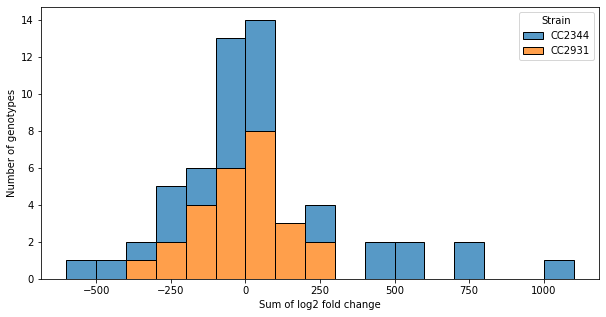

<Figure size 720x360 with 0 Axes>

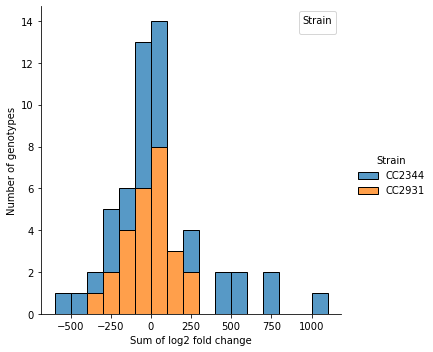

In [17]:
DEG_sum.rename(columns = {'sample':'Strain'}, inplace = True)

#### FINAL FIGURES ####
combined = pd.melt(DEG_sum, id_vars = ['Strain'], value_vars = ['positive_sum', 'negative_sum'])
bins_list = [i for i in range(-600, 1200, 100)]
plt.figure(figsize = (10, 5))
sns.histplot(data = combined, x = 'value', multiple = 'stack', hue = 'Strain', bins = bins_list)
plt.ylabel('Number of genotypes')
plt.xlabel('Sum of log2 fold change')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/direction_expression_change.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure(figsize = (10, 5))
sns.displot(combined, x = 'value', multiple = 'stack', hue = 'Strain', bins = bins_list)
plt.ylabel('Number of genotypes')
plt.xlabel('Sum of log2 fold change')
plt.legend(title = 'Strain')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/direction_expression_change1.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

In [19]:
#### STATS INFORMATION ####
CC2344_DEG_sum = DEG_sum.loc[DEG_sum['Strain'] == 'CC2344']
print('positive_sum: ' + str(CC2344_DEG_sum['positive_sum'].sum()), 'negative_sum: ' + str(CC2344_DEG_sum['negative_sum'].sum()), 'total: ' + str(CC2344_DEG_sum['positive_sum'].sum() + CC2344_DEG_sum['negative_sum'].sum()))

CC2931_DEG_sum = DEG_sum.loc[DEG_sum['Strain'] == 'CC2931']
print('positive_sum: ' + str(CC2931_DEG_sum['positive_sum'].sum()), 'negative_sum: ' + str(CC2931_DEG_sum['negative_sum'].sum()), 'total: ' + str(CC2931_DEG_sum['positive_sum'].sum() + CC2931_DEG_sum['negative_sum'].sum()))

positive_sum: 5264.23141717819 negative_sum: -2496.3818176064938 total: 2767.849599571696
positive_sum: 1280.8714791788316 negative_sum: -1651.4867102459807 total: -370.6152310671491


In [20]:
print(CC2344_DEG_sum['mutation'].sum(), CC2931_DEG_sum['mutation'].sum())

1143.0 1457.0


### PLOT OF SUM OF LOG2FOLD CHANGE (MINUS DEGs) PER GENERATION/MUTATION

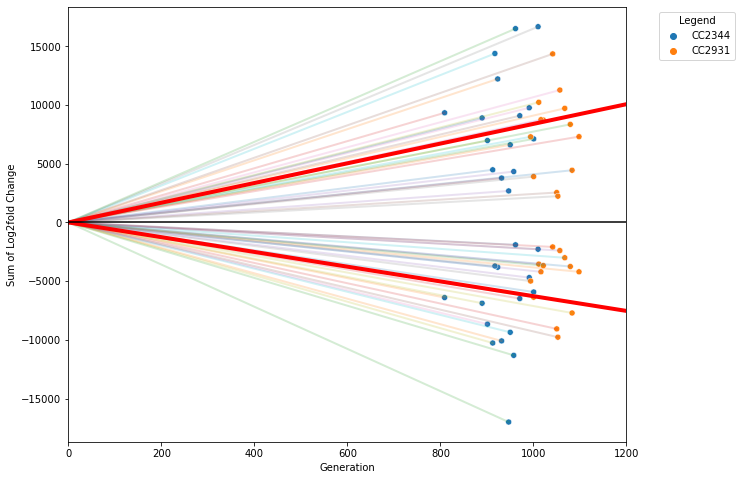

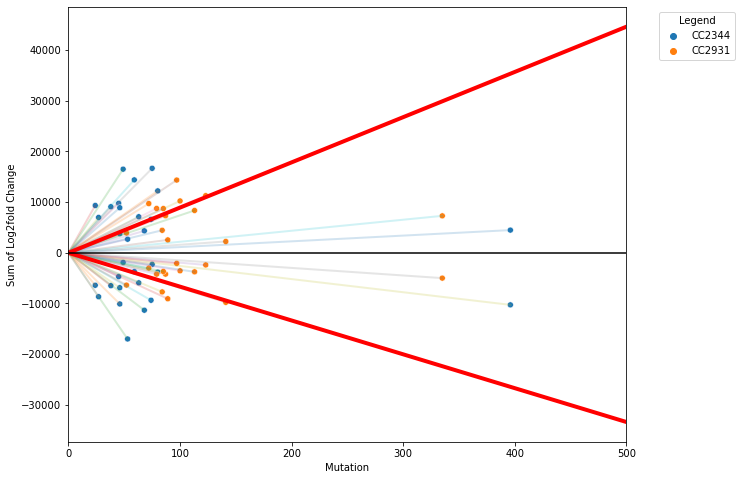

In [22]:
CC2344_L2F = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
CC2931_L2F = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')

for i in DEGs.index.values:
    if 'CC2344' in DEGs.at[i, 'sample']:
        CC2344_L2F.at[DEGs.at[i, 'value'], DEGs.at[i, 'sample']] = np.nan
    if 'CC2931' in DEGs.at[i, 'sample']:
        CC2931_L2F.at[DEGs.at[i, 'value'], DEGs.at[i, 'sample']] = np.nan

DEG_minus_sum = pd.DataFrame(index = total)
for i in CC2344 + CC2931:
    if 'CC2344' in i:
        positive_sum = CC2344_L2F[i].loc[CC2344_L2F[i] > 0].sum()
        negative_sum = CC2344_L2F[i].loc[CC2344_L2F[i] < 0].sum()
        DEG_minus_sum.at[i, 'positive_sum'] = positive_sum
        DEG_minus_sum.at[i, 'negative_sum'] = negative_sum
        DEG_minus_sum.at[i, 'generation'] = dic_gen[i]
        DEG_minus_sum.at[i, 'mutation'] = dic_mut[i]
    if 'CC2931' in i:
        positive_sum = CC2931_L2F[i].loc[CC2931_L2F[i] > 0].sum()
        negative_sum = CC2931_L2F[i].loc[CC2931_L2F[i] < 0].sum()
        DEG_minus_sum.at[i, 'positive_sum'] = positive_sum
        DEG_minus_sum.at[i, 'negative_sum'] = negative_sum
        DEG_minus_sum.at[i, 'generation'] = dic_gen[i]
        DEG_minus_sum.at[i, 'mutation'] = dic_mut[i]

mean_summary = DEG_minus_sum.mean(axis = 0)
DEG_minus_sum = DEG_minus_sum.reset_index()

for i in DEG_minus_sum.index.values:
    if 'CC2344' in DEG_minus_sum.at[i, 'index']:
        DEG_minus_sum.at[i, 'sample'] = 'CC2344'
    if 'CC2931' in DEG_minus_sum.at[i, 'index']:
        DEG_minus_sum.at[i, 'sample'] = 'CC2931'

plt.figure(figsize = (10, 8))
sns.scatterplot(data = DEG_minus_sum, x = 'generation', y = 'positive_sum', hue = 'sample', legend = False)
plt.ylabel('Sum of Log2fold Change')
for i in DEG_minus_sum.index.values:
    plt.plot([0, DEG_minus_sum.at[i, 'generation']], [0, DEG_minus_sum.at[i, 'positive_sum']], linewidth=2, alpha = 0.2)
slope = mean_summary['positive_sum']/mean_summary['generation']
plt.plot([0, 1200], [0, slope*1200], color = 'red', linewidth = 4)

sns.scatterplot(data = DEG_minus_sum, x = 'generation', y = 'negative_sum', hue = 'sample')
plt.xlabel('Generation')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = 'Legend')
for i in DEG_minus_sum.index.values:
    plt.plot([0, DEG_minus_sum.at[i, 'generation']], [0, DEG_minus_sum.at[i, 'negative_sum']], linewidth=2, alpha = 0.2)
slope = mean_summary['negative_sum']/mean_summary['generation']
plt.plot([0, 1200], [0, slope*1200], color = 'red', linewidth = 4)
plt.xlim(0, 1200)
plt.axhline(0, color = 'black')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/DEG_minus_sum_per_generation.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure(figsize = (10,8))
sns.scatterplot(data = DEG_minus_sum, x = 'mutation', y = 'positive_sum', hue = 'sample', legend = False)
plt.ylabel('Sum of Log2fold Change')
for i in DEG_minus_sum.index.values:
    plt.plot([0, DEG_minus_sum.at[i, 'mutation']], [0, DEG_minus_sum.at[i, 'positive_sum']], linewidth=2, alpha = 0.2)
slope = mean_summary['positive_sum']/mean_summary['mutation']
plt.plot([0, 500], [0, slope*500], color = 'red', linewidth = 4)

sns.scatterplot(data = DEG_minus_sum, x = 'mutation', y = 'negative_sum', hue = 'sample')
plt.xlabel('Mutation')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = 'Legend')
for i in DEG_minus_sum.index.values:
    plt.plot([0, DEG_minus_sum.at[i, 'mutation']], [0, DEG_minus_sum.at[i, 'negative_sum']], linewidth=2, alpha = 0.2)
slope = mean_summary['negative_sum']/mean_summary['mutation']
plt.plot([0, 500], [0, slope*500], color = 'red', linewidth = 4)
plt.xlim(0, 500)
plt.axhline(0, color = 'black')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/DEG_minus_sum_per_mutation.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

## DIVERGENCE

###  DIVERGENCE CORRELATIONS BETWEEN MUTATIONAL VARIANCE AND HIGH/LOW EXPRESSION GENES

In [112]:
import pandas as pd
import numpy as np
network_divergence = pd.read_csv('/research/projects/chlamydomonas/network_evolution/analysis/diversityANDdivergence_by_network_correlations.Ness/network_divergence_diversity_statsmerged.txt', sep = '\t')
network_divergence.set_index('transcript', inplace = True)
geneID = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/v5_to_v6_liftover/preliminary_v6_Cre_liftover.tsv', delimiter = '\t', header = None)
geneID.columns = ['v6', 'v5']
geneID.set_index('v5', inplace = True)
geneID = geneID[~geneID.index.duplicated(keep = 'first')]

conversion = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/v5_to_v6_liftover/ChlamydomonasTranscriptNameConversionBetweenReleases.Mch12b.csv', delimiter = ',', skiprows = 1)
conversion.columns = ['5.5', '3', '1', 'Genbank', '4', '4.3', 'u5', 'u9', '5.3.1']
conversion = conversion[~conversion.index.duplicated(keep = 'first')]
conversion.drop(['3', '1', 'Genbank', '4', '4.3', 'u5', 'u9'], axis = 1, inplace = True)
conversion = conversion.replace(' ', '', regex = True)
conversion.set_index('5.3.1', inplace = True)
network_divergence = conversion.join(network_divergence)
network_divergence['v5_5_gene'] = network_divergence['5.5'].replace('.t[1-9].*','', regex = True)
network_divergence = network_divergence.reset_index().set_index('v5_5_gene')

network_divergence = network_divergence[~network_divergence.index.duplicated(keep = 'first')]
network_divergence = network_divergence.join(geneID).reset_index()
network_divergence.rename(columns = {'v5_5_gene':'v5.5_gene', 'index':'v5.3.1', '5.5':'v5.5'}, inplace = True)
network_divergence.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/divergence/files/network_divergence.csv', sep = '\t', header = True, index = False )
version_conversion = network_divergence[['v5.5_gene', 'v5.3.1', 'v5.5', 'v6']]
version_conversion.to_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/v5.3_to_v5.6_to_v6.csv', sep = '\t', header = True, index = False)

1409 1273 1375 1366
5.595948776506076e-34 2.627213638738815e-41
median_low: 0.2221858794315323 variance_low: 0.020838651275763155 median_high: 0.19342994025456098 variance_high: 0.019056278713629346
median_low: 0.24241412805356366 variance_low: 0.026491651156827688 median_high: 0.18997505897318645 variance_high: 0.01603295781887704


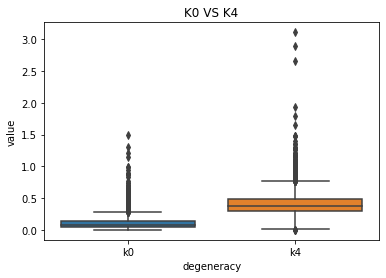

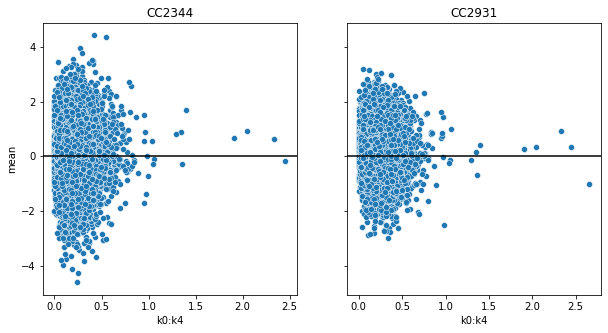

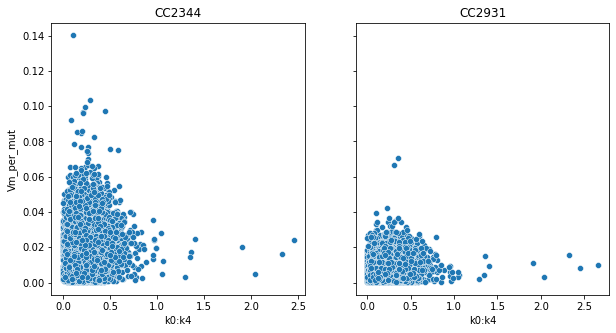

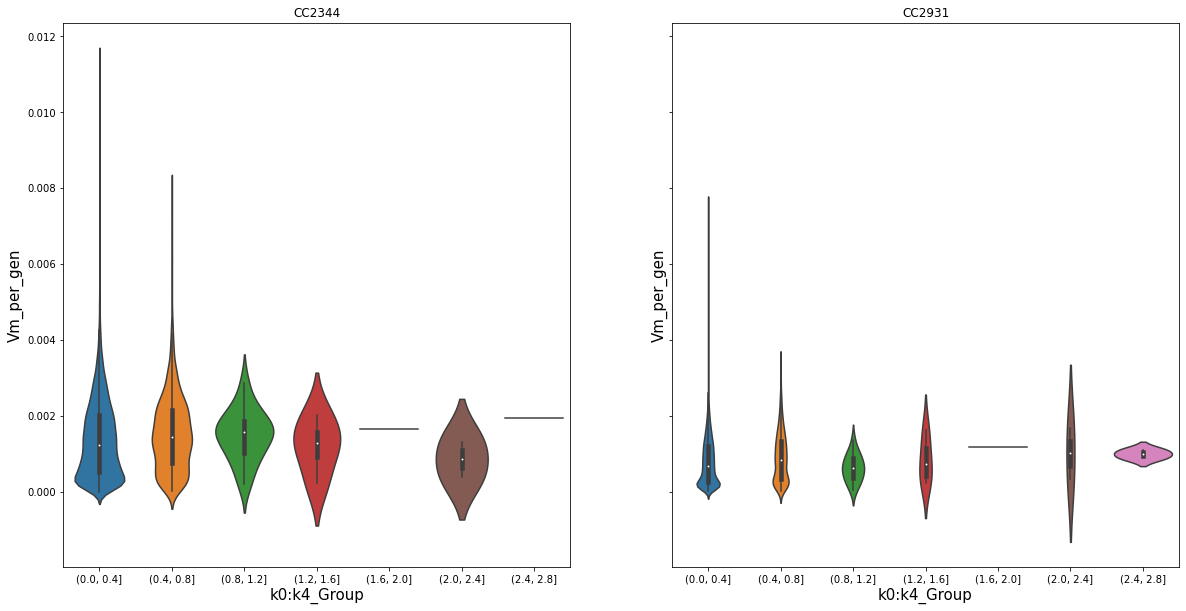

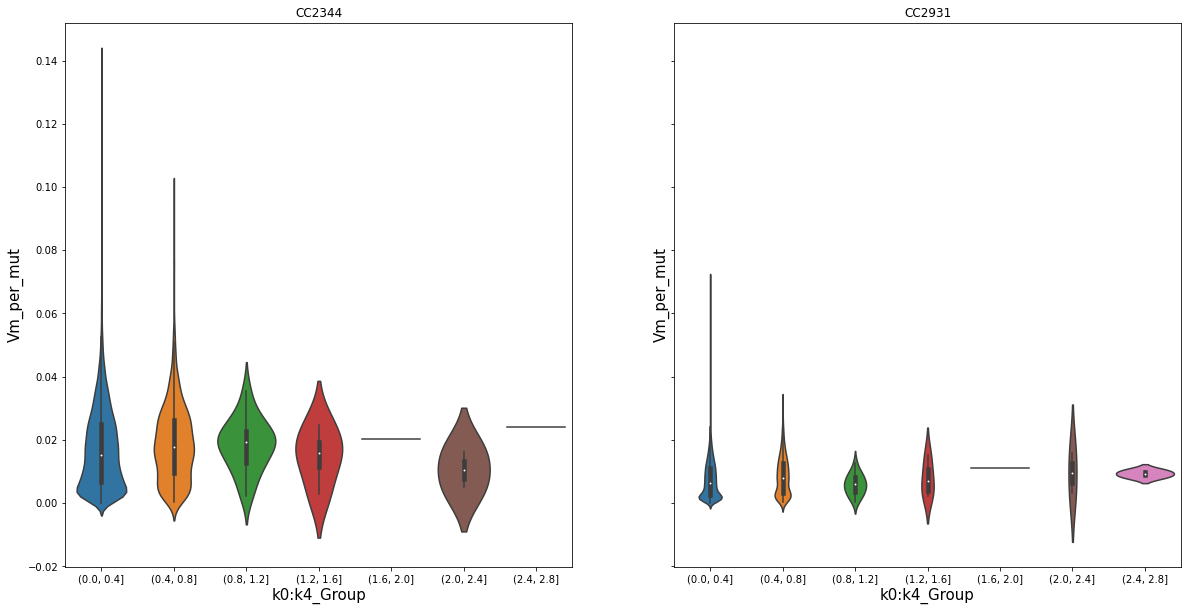

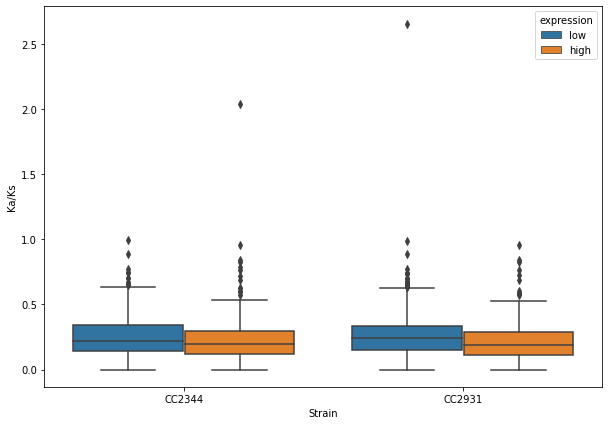

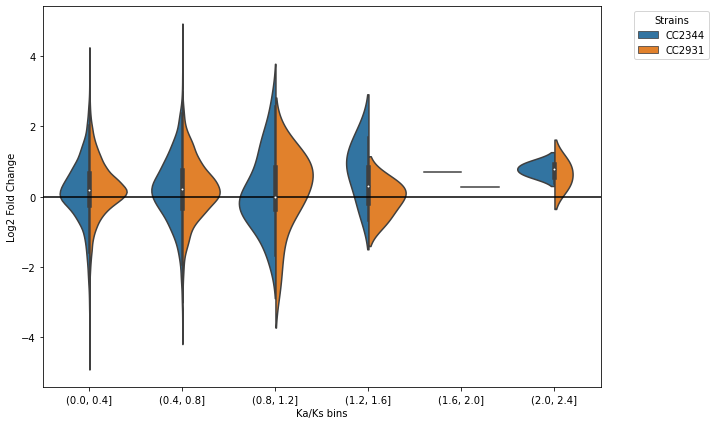

In [32]:
#### ADDING VERSION 6 GENES TO VERSION 5.3 DIVERGENCE FILE ####
CC2344_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
CC2931_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
divergence = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/divergence/files/network_divergence.csv', delimiter = '\t')

#### CREATING DATAFRAMES ####
for i in ['CC2344_Vm', 'CC2931_Vm']:
    exec('{} = pd.DataFrame()'.format(i))

#### FINDING AND ADDING THE LOG2FOLD MUTATIONAL VARIANCE ####
CC2344_Vm['Vm_per_gen'] = CC2344_log2Fold[CC2344[1:]].var(axis = 1)/CC2344_gen_mean
CC2931_Vm['Vm_per_gen'] = CC2931_log2Fold[CC2931[1:]].var(axis = 1)/CC2931_gen_mean
CC2344_Vm['Vm_per_mut'] = CC2344_log2Fold[CC2344[1:]].var(axis = 1)/CC2344_mut_mean
CC2931_Vm['Vm_per_mut'] = CC2931_log2Fold[CC2931[1:]].var(axis = 1)/CC2931_mut_mean

#### ADDING THE LOG2FOLD MEAN AND MEDIAN ####
CC2344_Vm['mean'] = CC2344_log2Fold[CC2344[1:]].mean(axis = 1)
CC2344_Vm['median'] = CC2344_log2Fold[CC2344[1:]].median(axis = 1)
CC2931_Vm['mean'] = CC2931_log2Fold[CC2931[1:]].mean(axis = 1)
CC2931_Vm['median'] = CC2931_log2Fold[CC2931[1:]].median(axis = 1)

CC2344_Vm['abs_mean'] = CC2344_Vm['mean'].abs()
CC2344_Vm['abs_median'] = CC2344_Vm['median'].abs()
CC2931_Vm['abs_mean'] = CC2931_Vm['mean'].abs()
CC2931_Vm['abs_median'] = CC2931_Vm['median'].abs()

#### EDITING DIVERGENCE FILE ####
for i in ['k0', 'k4']:
    divergence[i] = divergence[i].replace('None', 'nan', regex = True)
    divergence[i] = divergence[i].astype(float)
divergence['k0:k4'] = divergence['k0']/divergence['k4']
divergence.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/divergence/files/edited_divergence_info.txt', sep = '\t', index = False, header = True)
divergence.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/divergence/files/network_divergence.csv', sep = '\t', index = False, header = True)

#### PLOTTING - DEGENERACY ####
###############################
# 0-fold degenerate sites are those at which all changes are nonsynonymous
# 4-fold degenerate sites are those at which all changes are synonymous

k0_k4 = pd.melt(divergence, id_vars = ['v6'], value_vars = ['k0', 'k4'], var_name = 'degeneracy')
graph = sns.boxplot(data = k0_k4, x = 'degeneracy', y = 'value')
plt.title('K0 VS K4')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/divergence/k0_vs_k4.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### ADDING THE LOG2FOLD MUTATIONAL VARIANCE ####
#################################################
CC2344_overlap = list(set.intersection(set(divergence['v6']), set(CC2344_Vm.index.values)))
CC2344_divergence_subset = divergence.loc[divergence['v6'].isin(CC2344_overlap)]

CC2931_overlap = list(set.intersection(set(divergence['v6']), set(CC2931_Vm.index.values)))
CC2931_divergence_subset = divergence.loc[divergence['v6'].isin(CC2931_overlap)]

CC2344_Vm = pd.concat([CC2344_Vm, CC2344_divergence_subset.set_index('v6')[['k0', 'k4', 'k0:k4']]], axis = 1)
CC2931_Vm = pd.concat([CC2931_Vm, CC2931_divergence_subset.set_index('v6')[['k0', 'k4', 'k0:k4']]], axis = 1)

CC2344_Vm["k0:k4_Group"] = pd.cut(CC2344_Vm["k0:k4"], [0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8], precision = 0)
CC2931_Vm["k0:k4_Group"] = pd.cut(CC2931_Vm["k0:k4"], [0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8], precision = 0)

CC2344_Vm.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2344_L2F.csv', sep = '\t', index = True, header = True)
CC2931_Vm.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2931_L2F.csv', sep = '\t', index = True, header = True)

#### PLOTTING - MEAN VS K0:K4 (SCATTERPLOT) #####
#################################################
fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharey = True)
ax1 = sns.scatterplot(ax = axes[0], data = CC2344_Vm, y = 'mean', x = 'k0:k4')
ax1.axhline(0, color = 'black')
ax1.set_title('CC2344')
ax2 = sns.scatterplot(ax = axes[1], data = CC2931_Vm, y = 'mean', x = 'k0:k4')
ax2.axhline(0, color = 'black')
ax2.set_title('CC2931')

#### PLOTTING - MUTATIONAL VARIANCE VS K0:K4 (SCATTERPLOT) ####
###############################################################
fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharey = True)
ax1 = sns.scatterplot(ax = axes[0], data = CC2344_Vm, y = 'Vm_per_mut', x = 'k0:k4')
ax1.set_title('CC2344')
ax2 = sns.scatterplot(ax = axes[1], data = CC2931_Vm, y = 'Vm_per_mut', x = 'k0:k4')
ax2.set_title('CC2931')

#### PLOTTING - MUTATIONAL VARIANCE VS K0:K4 ####
#################################################
fig, axes = plt.subplots(1, 2, figsize = (20, 10), sharey = True)
ax1 = sns.violinplot(ax = axes[0], data = CC2344_Vm, y = 'Vm_per_gen', x = 'k0:k4_Group')
ax1.set_title('CC2344')
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)
ax2 = sns.violinplot(ax = axes[1], data = CC2931_Vm, y = 'Vm_per_gen', x = 'k0:k4_Group')
ax2.set_title('CC2931')
ax2.xaxis.label.set_size(15)
ax2.yaxis.label.set_size(15)
fig.savefig('/research/projects/chlamydomonas/MAexpression/analysis/divergence/Vm_per_gen_vs_k0:k4.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

fig, axes = plt.subplots(1, 2, figsize = (20, 10), sharey = True)
ax2 = sns.violinplot(ax = axes[0], data = CC2344_Vm, y = 'Vm_per_mut', x = 'k0:k4_Group')
ax2.set_title('CC2344')
ax2.xaxis.label.set_size(15)
ax2.yaxis.label.set_size(15)
ax4 = sns.violinplot(ax = axes[1], data = CC2931_Vm, y = 'Vm_per_mut', x = 'k0:k4_Group')
ax4.set_title('CC2931')
ax4.xaxis.label.set_size(15)
ax4.yaxis.label.set_size(15)
fig.savefig('/research/projects/chlamydomonas/MAexpression/analysis/divergence/Vm_per_mut_vs_k0:k4.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### MANN WHITNEY U TEST BETWEEN K0:K4 GROUPS ####
group_list = CC2344_Vm['k0:k4_Group'].dropna()
group_list = group_list.unique()
lis = [1, 0, 2, 3, 5, 4]
group_list = [group_list[i] for i in lis]

results = pd.DataFrame(columns = ['CC2344_pval_Vm_per_gen', 'CC2931_pval_Vm_per_gen', 'CC2344_pval_Vm_per_mut', 'CC2931_pval_Vm_per_mut'])

for i in range(len(group_list[:-1])):
    edited_CC2344_Vm = CC2344_Vm.groupby('k0:k4_Group')
    section_1 = edited_CC2344_Vm.get_group(group_list[i])
    section_2 = edited_CC2344_Vm.get_group(group_list[i+1])
    section_3 = section_1['Vm_per_gen'].values.tolist()
    section_4 = section_2['Vm_per_gen'].values.tolist()
    t_stat, pval = mannwhitneyu(section_3, section_4)
    results.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2344_pval_Vm_per_gen'] = pval
    
    section_5 = section_1['Vm_per_mut'].values.tolist()
    section_6 = section_2['Vm_per_mut'].values.tolist()
    t_stat1, pval1 = mannwhitneyu(section_5, section_6)
    results.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2344_pval_Vm_per_mut'] = pval1
    
for i in range(len(group_list[:-1])):
    edited_CC2931_Vm = CC2931_Vm.groupby('k0:k4_Group')
    section_1 = edited_CC2931_Vm.get_group(group_list[i])
    section_3 = section_1['Vm_per_gen'].values.tolist()
    section_2 = edited_CC2931_Vm.get_group(group_list[i+1])
    section_4 = section_2['Vm_per_gen'].values.tolist()
    t_stat, pval = mannwhitneyu(section_3, section_4)
    results.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2931_pval_Vm_per_gen'] = pval
    
    section_5 = section_1['Vm_per_mut'].values.tolist()
    section_6 = section_2['Vm_per_mut'].values.tolist()
    t_stat1, pval1 = mannwhitneyu(section_5, section_6)
    results.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2931_pval_Vm_per_mut'] = pval1

#### HIGH AND LOW EXPRESSION GENES VS K0:K4 ####
################################################
CC2344_low = divergence[['v6', 'k0', 'k4', 'k0:k4']].loc[divergence['v6'].isin(CC2344_low_exp)]
CC2344_low['expression'] = 'low'
CC2344_low['sample'] = 'CC2344'
CC2344_high = divergence[['v6', 'k0', 'k4', 'k0:k4']].loc[divergence['v6'].isin(CC2344_hi_exp)]
CC2344_high['expression'] = 'high'
CC2344_high['sample'] = 'CC2344'
CC2931_low = divergence[['v6', 'k0', 'k4', 'k0:k4']].loc[divergence['v6'].isin(CC2931_low_exp)]
CC2931_low['expression'] = 'low'
CC2931_low['sample'] = 'CC2931'
CC2931_high = divergence[['v6', 'k0', 'k4', 'k0:k4']].loc[divergence['v6'].isin(CC2931_hi_exp)]
CC2931_high['expression'] = 'high'
CC2931_high['sample'] = 'CC2931'

divergence_plot = pd.concat([CC2344_low, CC2344_high, CC2931_low, CC2931_high], axis = 0)

plt.figure(figsize = (10, 7))
sns.boxplot(data = divergence_plot, x = 'sample', y = 'k0:k4', hue = 'expression') ## SIGNIFICANT!!
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xlabel('Strain')
plt.ylabel('Ka/Ks')
CC2344_ts, CC2344_p = mannwhitneyu(CC2344_high['k0:k4'].values.tolist(), CC2344_low['k0:k4'].values.tolist(), alternative = 'less')
CC2931_ts, CC2931_p = mannwhitneyu(CC2931_high['k0:k4'].values.tolist(), CC2931_low['k0:k4'].values.tolist(), alternative = 'less')
print(len(CC2344_high['k0:k4'].values.tolist()), len(CC2344_low['k0:k4'].values.tolist()), len(CC2931_high['k0:k4'].values.tolist()), len(CC2931_low['k0:k4'].values.tolist()))
print(CC2344_p, CC2931_p)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/divergence/high_low_vs_k0:k4.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### STATS OF K0:K4 EXPRESSION VARIATION ####
CC2344_div = divergence_plot.loc[divergence_plot['sample'] == 'CC2344']
CC2344_div_low = CC2344_div.loc[CC2344_div['expression'] == 'low']
CC2344_div_high = CC2344_div.loc[CC2344_div['expression'] == 'high']
print('median_low: ' + str(CC2344_div_low['k0:k4'].median()), 'variance_low: ' + str(CC2344_div_low['k0:k4'].var()), 'median_high: ' + str(CC2344_div_high['k0:k4'].median()), 'variance_high: ' + str(CC2344_div_high['k0:k4'].var()))

CC2931_div = divergence_plot.loc[divergence_plot['sample'] == 'CC2931']
CC2931_div_low = CC2931_div.loc[CC2931_div['expression'] == 'low']
CC2931_div_high = CC2931_div.loc[CC2931_div['expression'] == 'high']
print('median_low: ' + str(CC2931_div_low['k0:k4'].median()), 'variance_low: ' + str(CC2931_div_low['k0:k4'].var()), 'median_high: ' + str(CC2931_div_high['k0:k4'].median()), 'variance_high: ' + str(CC2931_div_high['k0:k4'].var()))

#### PLOTTING THE BOXPLOT LOG2FOLD OF MEAN/MEDIAN VS K0:K4 ####
###############################################################
CC2344_L2F = pd.DataFrame(index = [i for i in range(len(group_list))], columns = ['mean', 'median', 'abs_mean', 'abs_median'])
CC2931_L2F = pd.DataFrame(index = [i for i in range(len(group_list))], columns = ['mean', 'median', 'abs_mean', 'abs_median'])

for i in range(len(group_list)):
    genes = CC2344_Vm.loc[CC2344_Vm['k0:k4_Group'] == group_list[i]]
    CC2344_L2F.at[i, 'mean'] = genes['mean'].values.tolist()
    CC2344_L2F.at[i, 'median'] = genes['median'].values.tolist()
    CC2344_L2F.at[i, 'abs_mean'] = genes['abs_mean'].values.tolist()
    CC2344_L2F.at[i, 'abs_median'] = genes['abs_median'].values.tolist()
    CC2344_L2F.at[i, 'k0:k4_Group'] = group_list[i]

for i in range(len(group_list)):
    genes = CC2931_Vm.loc[CC2931_Vm['k0:k4_Group'] == group_list[i]]
    CC2931_L2F.at[i, 'mean'] = genes['mean'].values.tolist()
    CC2931_L2F.at[i, 'median'] = genes['median'].values.tolist()
    CC2931_L2F.at[i, 'abs_mean'] = genes['abs_mean'].values.tolist()
    CC2931_L2F.at[i, 'abs_median'] = genes['abs_median'].values.tolist()
    CC2931_L2F.at[i, 'k0:k4_Group'] = group_list[i]
    
#### CHANGING DATAFRAME TO LONGFORM ####
# CC2344_L2F = pd.melt(CC2344_L2F, id_vars = 'k0:k4 Group', value_vars = ['mean', 'median', 'abs_mean', 'abs_median'])
# CC2931_L2F = pd.melt(CC2931_L2F, id_vars = 'k0:k4 Group', value_vars = ['mean', 'median', 'abs_mean', 'abs_median'])

CC2344_L2F = pd.melt(CC2344_L2F, id_vars = 'k0:k4_Group', value_vars = ['mean', 'abs_mean'])
CC2931_L2F = pd.melt(CC2931_L2F, id_vars = 'k0:k4_Group', value_vars = ['mean', 'abs_mean'])

#### EXPLODING ALL VALUES IN LIST #####
CC2344_L2F = CC2344_L2F.explode('value')
CC2931_L2F = CC2931_L2F.explode('value')

#### COMBINING CC2344 AND CC2931 ####
CC2344_L2F['sample'] = 'CC2344'
CC2931_L2F['sample'] = 'CC2931'
combined_L2F = pd.concat([CC2344_L2F, CC2931_L2F])
combined_L2F['value'] = combined_L2F['value'].astype(float)

#### PLOT ####
fig, ax = plt.subplots(figsize = (10,7))
sns.violinplot(ax = ax, data = combined_L2F.loc[combined_L2F['variable'] == 'mean'], x = 'k0:k4_Group', y = 'value', hue = 'sample', alpha = 0.2, split = True)
plt.axhline(0, color = 'black')
plt.xlabel('Ka/Ks bins')
plt.ylabel('Log2 Fold Change')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = 'Strains')

In [124]:
#### MANN WHITNEY U TEST BETWEEN MEANK0:K4 GROUPS ####
group_list = CC2344_Vm['k0:k4 Group'].dropna()
group_list = group_list.unique()
lis = [1, 0, 2, 3, 5, 4]
group_list = [group_list[i] for i in lis]

results_combined_L2F = pd.DataFrame()

groups = combined_L2F.groupby('k0:k4 Group')
for i in range(len(group_list[:-1])):
    section_1 = groups.get_group(group_list[i])
    section_2 = groups.get_group(group_list[i+1])
    CC2344_1 = section_1.loc[section_1['sample'] == 'CC2344']
    CC2931_1 = section_1.loc[section_1['sample'] == 'CC2931']
    CC2344_2 = section_2.loc[section_2['sample'] == 'CC2344']
    CC2931_2 = section_2.loc[section_2['sample'] == 'CC2931']
    
    CC2344_value_1 = CC2344_1['value'].values.tolist()
    CC2931_value_1 = CC2931_1['value'].values.tolist()
    CC2344_value_2 = CC2344_2['value'].values.tolist()
    CC2931_value_2 = CC2931_2['value'].values.tolist()
    t_stat, pval = mannwhitneyu(CC2344_value_1, CC2344_value_2, alternative = 'less')
    results_combined_L2F.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2344_alt_less'] = pval
    t_stat1, pval1 = mannwhitneyu(CC2931_value_1, CC2931_value_2, alternative = 'less')
    results_combined_L2F.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2931_alt_less'] = pval1
    
    t_stat, pval = mannwhitneyu(CC2344_value_1, CC2344_value_2, alternative = 'greater')
    results_combined_L2F.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2344_alt_great'] = pval
    t_stat1, pval1 = mannwhitneyu(CC2931_value_1, CC2931_value_2, alternative = 'greater')
    results_combined_L2F.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2931_alt_great'] = pval1
    
display(results_combined_L2F)

,CC2344_alt_less,CC2931_alt_less,CC2344_alt_great,CC2931_alt_great
"(0.0, 0.4]-(0.4, 0.8]",0.000204,0.014182,0.999796,0.985818
"(0.4, 0.8]-(0.8, 1.2]",0.645182,0.104259,0.354911,0.895789
"(0.8, 1.2]-(1.2, 1.6]",0.075641,0.957281,0.928404,0.045559
"(1.2, 1.6]-(1.6, 2.0]",0.882885,0.346316,0.177433,0.744990
"(1.6, 2.0]-(2.0, 2.4]",0.595634,0.045092,0.595634,0.985318


### EXAMINING DEGs

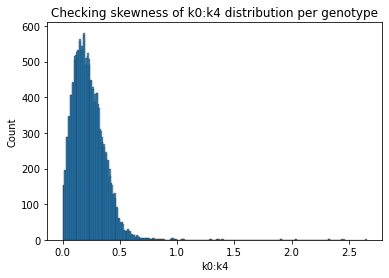

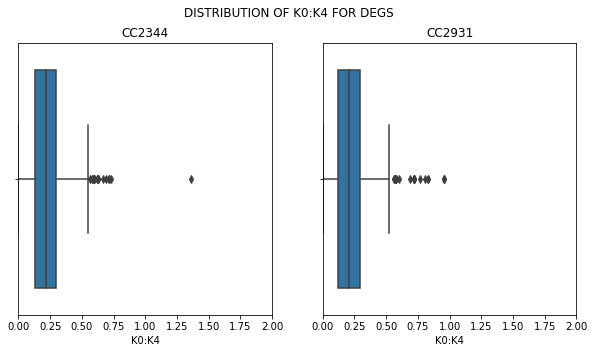

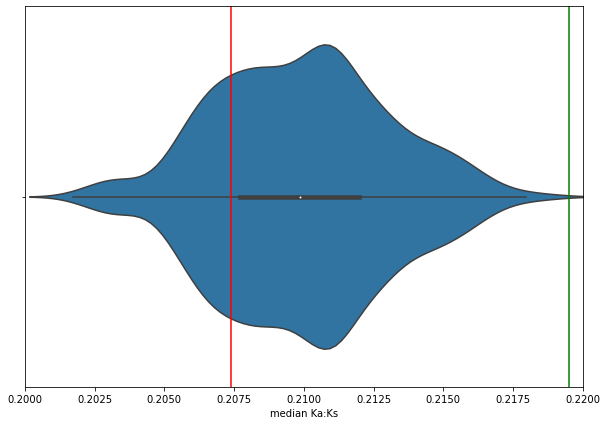

In [18]:
#### LISTS ####
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
total = CC2344 + CC2931

#### CHECKING THE SKEWNESS OF K0:K4 DISTRIBUTION ACROSS ALL DATA ####
sns.histplot(CC2344_Vm['k0:k4']) ## Data is right-skewed
sns.histplot(CC2931_Vm['k0:k4']) ## Data is right-skewed
plt.title('Checking skewness of k0:k4 distribution per genotype')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/divergence/k0_k4_distribution_histogram.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### ISOLATING THE K0:K4 OF DEGS ####
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',')
DEGs = DEGs.reset_index()
DEGs = pd.melt(DEGs, id_vars = 'index', value_vars = DEGs.columns[1:])
DEGs = DEGs.dropna().rename(columns = {'variable':'sample'})

for i in list(DEGs.index.values):
    DEGs.at[i, 'sample'] = DEGs.at[i, 'sample']

CC2344_DEGs = DEGs.loc[DEGs['sample'].isin(CC2344)]
CC2931_DEGs = DEGs.loc[DEGs['sample'].isin(CC2931)]
    
CC2344_subset = CC2344_Vm.loc[CC2344_DEGs['value'].values.tolist()]
CC2344_DEGs = pd.concat([CC2344_DEGs.set_index('value'), CC2344_subset], axis = 1)

CC2931_subset = CC2931_Vm.loc[CC2931_DEGs['value'].values.tolist()]
CC2931_DEGs = pd.concat([CC2931_DEGs.set_index('value'), CC2931_subset], axis = 1)

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
sns.boxplot(ax = axes[0], data = CC2344_DEGs, x = 'k0:k4')
sns.boxplot(ax = axes[1], data = CC2931_DEGs, x = 'k0:k4')
axes[0].set_title('CC2344')
axes[1].set_title('CC2931')
axes[0].set_xlabel('K0:K4')
axes[1].set_xlabel('K0:K4')
axes[0].set_xlim(0,2)
axes[1].set_xlim(0,2)
fig.suptitle('DISTRIBUTION OF K0:K4 FOR DEGS')
fig.savefig('/research/projects/chlamydomonas/MAexpression/analysis/divergence/distribution_k0:k4_degs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### NULL HYPOTHESIS ####
k0_k4_results = pd.DataFrame(index = [i for i in range(1000)])
for i in range(1000):
    genes = np.random.choice(list(CC2344_Vm.index.values), len(DEGs), replace = True)
    simulated_degs = CC2344_Vm.loc[genes]
    simulated_degs = simulated_degs.dropna()
    k0_k4_results.at[i, 'CC2344_simulated_degs'] = len(simulated_degs['k0:k4'].values.tolist())
    k0_k4_results.at[i, 'CC2344_simulated_degs_median'] = simulated_degs['k0:k4'].median()
    stat, p = mannwhitneyu(simulated_degs['k0:k4'].values.tolist(), CC2344_DEGs['k0:k4'].values.tolist()) ## ALL SIG!!
    if p < 0.05:
        k0_k4_results.at[i, 'CC2344_trials'] = 'Null rejected'
    k0_k4_results['CC2344_observed_degs'] = len(CC2344_DEGs['k0:k4'].values.tolist())
    k0_k4_results['CC2344_observed_degs_median'] = CC2344_DEGs['k0:k4'].median()
    
    genes = np.random.choice(list(CC2931_Vm.index.values), len(DEGs), replace = True)
    simulated_degs = CC2931_Vm.loc[genes]
    simulated_degs = simulated_degs.dropna()
    k0_k4_results.at[i, 'CC2931_simulated_degs'] = len(simulated_degs['k0:k4'].values.tolist())
    k0_k4_results.at[i, 'CC2931_simulated_degs_median'] = simulated_degs['k0:k4'].median()
    stat, p = mannwhitneyu(simulated_degs['k0:k4'].values.tolist(), CC2931_DEGs['k0:k4'].values.tolist()) ## ALL SIG!!
    if p < 0.05:
        k0_k4_results.at[i, 'CC2931_trials'] = 'Null rejected'
    k0_k4_results['CC2931_observed_degs'] = len(CC2931_DEGs['k0:k4'].values.tolist())
    k0_k4_results['CC2931_observed_degs_median'] = CC2931_DEGs['k0:k4'].median()
    
#### COMPARING MEDIAN K0:K4 OF OBSERVED/SIMULATED DEGS ####
plt.figure(figsize = (10, 7))
ax = sns.violinplot(x = k0_k4_results['CC2344_simulated_degs_median'])
ax.axvline(k0_k4_results.at[0, 'CC2344_observed_degs_median'], color = 'green')
ax.axvline(k0_k4_results.at[0, 'CC2931_observed_degs_median'], color = 'red')
ax.set_xlabel('median Ka:Ks')
ax.set_xlim(0.2, 0.22)
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/divergence/boxplot_median_k0:k4_observed_vs_simulated_degs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

In [19]:
pval = k0_k4_results.loc[k0_k4_results['CC2344_simulated_degs_median'] >= k0_k4_results.at[0, 'CC2344_observed_degs_median']]
len(pval)
pval1 = k0_k4_results.loc[k0_k4_results['CC2931_simulated_degs_median'] >= k0_k4_results.at[0, 'CC2931_observed_degs_median']]
print(len(pval), len(pval1))

0 707


### EXAMINING DEGS - Correlation between the frequency of each DEG and their divergence

<ipython-input-25-21b1b184e6f9>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_genes_subset['GENEID'] = [int(i) for i in unique_genes_subset['GENEID'].values.tolist()]


1778


,pval,null_hypothesis
"(4.0, 6.0]-(6.0, 8.0]",0.421014,not rejected
"(6.0, 8.0]-(8.0, 9.0]",0.122412,not rejected
"(8.0, 9.0]-(9.0, 11.0]",0.172143,not rejected
"(9.0, 11.0]-(11.0, 12.0]",0.270146,not rejected
"(11.0, 12.0]-(12.0, 14.0]",0.193238,not rejected
"(12.0, 14.0]-(17.0, 19.0]",0.185547,not rejected


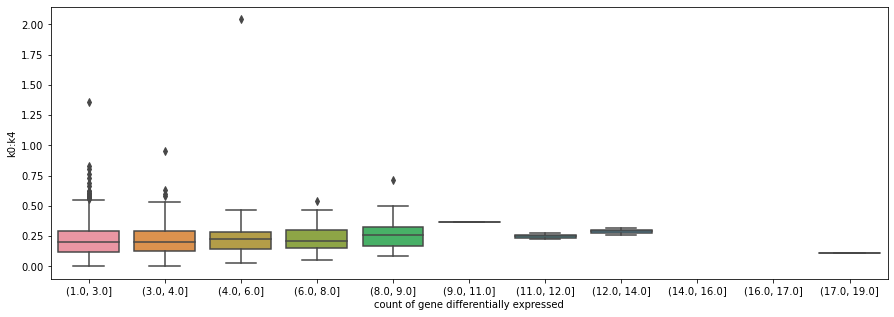

In [25]:
#### OPENING FILES ####
UNIPROT = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/annotation_package/edited_anno/UNIPROT_BY_GENENAME', delimiter = '\t')
CC2344_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2344_avg_fpkm', delimiter = '\t', index_col = 'index')
CC2931_avg_fpkm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/fpkm/CC2931_avg_fpkm', delimiter = '\t', index_col = 'index')
geneID = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/v5_to_v6_liftover/preliminary_v6_Cre_liftover.tsv', delimiter = '\t', header = None, names = ['v6', 'v5'])
mutations = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/mutation_info/all_mutations.csv', delimiter = '\t')
mutations['sample'] = mutations['sample'].str.replace('_', '-L', regex = True)
mutation_counts = mutations['gene'].value_counts()

#### ALL DIFFERENTIALLY EXPRESSED GENES ####
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv', delimiter = ',')
DEGs = DEGs.reset_index()
DEGs = pd.melt(DEGs, id_vars = 'index', value_vars = DEGs.columns[1:])
DEGs = DEGs.dropna()
unique_genes = DEGs['value'].value_counts()
unique_genes = unique_genes.reset_index()
unique_genes['expression'] = 'neither'

#### ADDING K0:K4 AND V6 DATA TO DATAFRAMES ####
unique_genes = unique_genes.set_index('index').join(mutation_counts)
divergence_subset = divergence.loc[divergence['v6'].isin(unique_genes.index.values)]
divergence_subset = divergence_subset.set_index('v6')
unique_genes = pd.concat([unique_genes, divergence_subset[['k0', 'k4', 'k0:k4']]], axis = 1)
unique_genes['value_group'] = pd.cut(unique_genes['value'], 11, precision = 0)

select_index = unique_genes['k0:k4'].dropna()
unique_genes = unique_genes.loc[select_index.index.values]
subset = geneID.loc[geneID['v6'].isin(unique_genes.index.values)]
unique_genes = pd.concat([subset.set_index('v6'), unique_genes], axis = 1) ## high frequency DEGs were check for function, but played nothing significant

UNIPROT_GENENAME = UNIPROT['GENENAME'].values.tolist()
gene_intersect = set.intersection(set(unique_genes['v5']), set(UNIPROT_GENENAME))
specific_genes = UNIPROT.loc[UNIPROT['GENENAME'].isin(gene_intersect)]
unique_genes = unique_genes.reset_index()
unique_genes = unique_genes.set_index('v5').join(specific_genes.set_index('GENENAME')['GENEID'])
unique_genes = unique_genes.sort_values(by = 'value', ascending=False)

#### ISOLATING THE GENEID OF UNIQUE GENES SET ####
unique_genes_subset = unique_genes.loc[unique_genes['GENEID'].isin(unique_genes['GENEID'].dropna())]
unique_genes_subset['GENEID'] = [int(i) for i in unique_genes_subset['GENEID'].values.tolist()]
unique_genes_subset['GENEID'].to_csv('/research/projects/chlamydomonas/MAexpression/analysis/divergence/files/unique_genes_geneid.csv', sep = ',', index = False, header = True)

#### ADDING GENENAME TO UNIQUE GENES SET ####
gene_names = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/divergence/files/unique_genes_gene_name.txt', delimiter = '\t')[['ENTREZ_GENE_ID', 'Name']]
unique_genes_subset = unique_genes_subset.reset_index()
unique_genes_subset = unique_genes_subset.set_index('GENEID').join(gene_names.set_index('ENTREZ_GENE_ID'))

#### ENSURING THAT EACH UNIQUE GENE OCCURS IN DIFFERENT SAMPLES ####
counter = 0
unique_genes = unique_genes.reset_index()
for i in unique_genes.index.values:
    if len(DEGs.loc[DEGs['value'] == unique_genes.at[i, 'index']]) == unique_genes.at[i, 'value']:
        counter += 1
print(counter)
    
#### CLASSIFYING POTENTIAL CIS MUTATIONS WITH HIGH/LOW/NEITHER EXPRESSION ####
for i in unique_genes.index.values:
    if unique_genes.at[i, 'index'] in list(overlap_1) + list(overlap_2):
        unique_genes.at[i, 'expression'] = 'neither'
    elif unique_genes.at[i, 'index'] in CC2344_hi_exp + CC2931_hi_exp:
        unique_genes.at[i, 'expression'] = 'high'
    else:
        if unique_genes.at[i, 'index'] in CC2344_low_exp + CC2931_low_exp:
            unique_genes.at[i, 'expression'] = 'low'
            
#### EXPORT CSV ####
unique_genes.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/examining_degs/unique_genes.csv', sep = '\t', index = False, header = True)         

#### PLOT ####
plt.figure(figsize = (15, 5))
sns.boxplot(data = unique_genes, x = 'value_group', y = 'k0:k4') ## No correlation between divergence of the genes and the frequency at which a gene is differentially expressed
plt.xlabel('count of gene differentially expressed')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/divergence/DEGs_vs_k0:k4.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### MANN WHITNEY U TEST BETWEEN GROUPS OF DEG FREQUENCY ####
group_list = unique_genes['value_group'].dropna()
group_list = group_list.unique()
lis = [6, 5, 4, 3, 2, 1, 0]
group_list = [group_list[i] for i in lis]

results = pd.DataFrame(columns = ['pval', 'null_hypothesis'])

for i in range(len(group_list[:-1])): ## none are significant
    edited_unique_genes = unique_genes.groupby('value_group')
    section_1 = edited_unique_genes.get_group(group_list[i])
    section_3 = section_1['k0:k4'].values.tolist()
    section_2 = edited_unique_genes.get_group(group_list[i+1])
    section_4 = section_2['k0:k4'].values.tolist()
    t_stat, pval = mannwhitneyu(section_3, section_4)
    results.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'pval'] = pval
    if pval < 0.05:
        results.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'null_hypothesis'] = 'rejected'
    else:
        results.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'null_hypothesis'] = 'not rejected'
display(results)

## NETWORK STATS - BETWEENNESS CENTRALITY

<ipython-input-4-40552f689524>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  section_95perc.dropna(subset = ['v5.5_gene'], inplace = True) ##  66 genes in top 90 percentile betweenness
<ipython-input-4-40552f689524>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  section_90perc.dropna(subset = ['v5.5_gene'], inplace = True) ## 135 genes in top 90 percentile betweenness


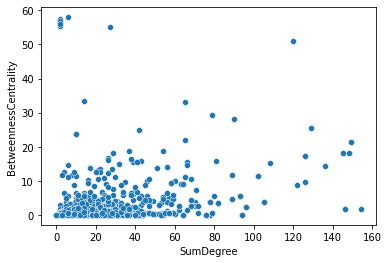

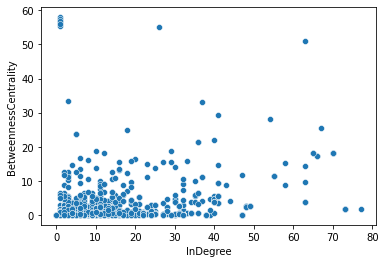

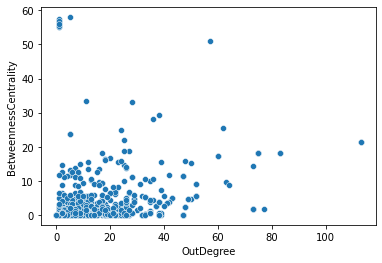

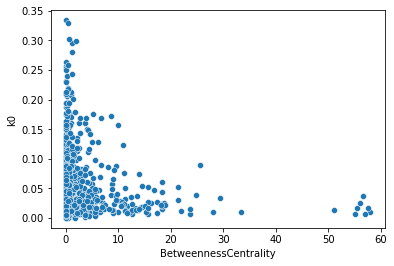

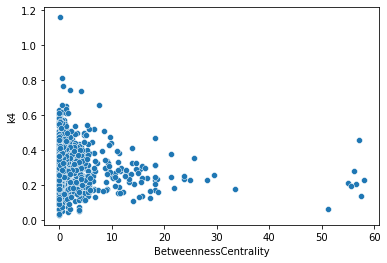

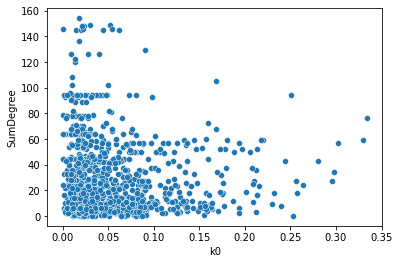

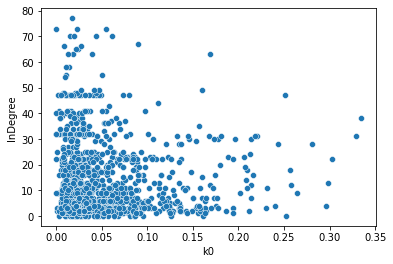

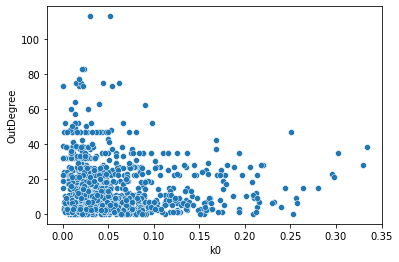

In [4]:
#### CRE1355 - BASED DATA ####
CC2344_Vm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2344_L2F.csv', delimiter = '\t', index_col = 'Unnamed: 0')
CC2931_Vm = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2931_L2F.csv', delimiter = '\t', index_col = 'Unnamed: 0')
centrality = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/divergence/files/network_divergence.csv', delimiter = '\t', index_col = 'v6')
for i in ['SumDegree', 'InDegree', 'OutDegree']:
    plt.figure()
    sns.scatterplot(data = centrality, x = i, y = 'BetweennessCentrality')

CC2344_Vm = CC2344_Vm[~CC2344_Vm.index.duplicated(keep = 'first')]
CC2931_Vm = CC2931_Vm[~CC2931_Vm.index.duplicated(keep = 'first')]
centrality = centrality[~centrality.index.duplicated(keep = 'first')]

CC2344_gene_network = pd.concat([centrality, CC2344_Vm], axis = 1)
CC2931_gene_network = pd.concat([centrality, CC2931_Vm], axis = 1)

#### VIEWING CONNECTIONS BETWEEN GENES ####
for i in ['k0', 'k4']:
    plt.figure()
    sns.scatterplot(data = centrality, y = i, x = 'BetweennessCentrality')
    
for i in ['SumDegree', 'InDegree', 'OutDegree']:
    plt.figure()
    sns.scatterplot(data = centrality, y = i, x = 'k0')

#### ISOLATING GENES WITH TOP PERCENTILE BETWEENNESS ####
ninety_five_percentile = np.percentile(centrality['BetweennessCentrality'].dropna(), 95)
section_95perc = centrality.loc[centrality['BetweennessCentrality'] >= ninety_five_percentile]
section_95perc.dropna(subset = ['v5.5_gene'], inplace = True) ##  66 genes in top 90 percentile betweenness
section_95perc['v5.5_gene'].to_csv('/research/projects/chlamydomonas/MAexpression/analysis/centrality/95_percentile_betweenness_genes_v5.5.csv', sep = ',', index = False, header = True)

ninety_percentile = np.percentile(centrality['BetweennessCentrality'].dropna(), 90)
section_90perc = centrality.loc[centrality['BetweennessCentrality'] >= ninety_percentile]
section_90perc.dropna(subset = ['v5.5_gene'], inplace = True) ## 135 genes in top 90 percentile betweenness
section_90perc['v5.5_gene'].to_csv('/research/projects/chlamydomonas/MAexpression/analysis/centrality/90_percentile_betweenness_genes_v5.5.csv', sep = ',', index = False, header = True)

In [6]:
import scipy
from scipy import stats
from scipy.stats import fligner
from scipy.stats import kruskal

#### PLOTTING LOG2FOLD EXPRESSION VS BETWEENNESS CENTRALITY ####
CC2344_gene_network['BC_Groups'] = pd.cut(CC2344_gene_network['BetweennessCentrality'], bins = [0, 10, 20, 30, 40 , 50 , 60])
CC2931_gene_network['BC_Groups'] = pd.cut(CC2931_gene_network['BetweennessCentrality'], bins = [0, 10, 20, 30, 40 , 50 , 60])

CC2344_gene_network['ID_Groups'] = pd.cut(CC2344_gene_network['InDegree'], bins = [i for i in range(0, 90, 10)])
CC2931_gene_network['ID_Groups'] = pd.cut(CC2931_gene_network['InDegree'], bins = [i for i in range(0, 90, 10)])

CC2344_gene_network['OD_Groups'] = pd.cut(CC2344_gene_network['OutDegree'], bins = [i for i in range(0, 140, 20)])
CC2931_gene_network['OD_Groups'] = pd.cut(CC2931_gene_network['OutDegree'], bins = [i for i in range(0, 140, 20)])

CC2344_gene_network['SD_Groups'] = pd.cut(CC2344_gene_network['SumDegree'], bins = [i for i in range(0, 160, 20)])
CC2931_gene_network['SD_Groups'] = pd.cut(CC2931_gene_network['SumDegree'], bins = [i for i in range(0, 160, 20)])

#### LIST OF ORDERED GROUPS ARRANGED ####
group_list = CC2344_gene_network['OD_Groups'].dropna()
group_list = group_list.unique()
lis = [0, 1, 2, 5, 4, 3]
OD_list = [group_list[i] for i in lis]

group_list = CC2344_gene_network['ID_Groups'].dropna()
group_list = group_list.unique()
lis = [0, 3, 1, 2, 4, 7, 5, 6]
ID_list = [group_list[i] for i in lis]

group_list = CC2344_gene_network['BC_Groups'].dropna()
group_list = group_list.unique()
lis = [0, 2, 1, 3, 4]
BC_list = [group_list[i] for i in lis]

group_list = CC2344_gene_network['SD_Groups'].dropna()
group_list = group_list.unique()
lis = [0, 2, 1, 3, 4, 6, 5]
SD_list = [group_list[i] for i in lis]

ordered_list = {'OD_Groups':OD_list, 'ID_Groups':ID_list, 'BC_Groups':BC_list, 'SD_Groups':SD_list}

#### LIST OF ALL VARIANCES PER GROUP ####
CC2344_BC_Groups = []
for i in ordered_list['BC_Groups']:
    group = CC2344_gene_network.loc[CC2344_gene_network['BC_Groups'] == i]
    CC2344_BC_Groups.append(group['mean'].dropna().values.tolist())
    
CC2344_ID_Groups = []
for i in ordered_list['ID_Groups']:
    group = CC2344_gene_network.loc[CC2344_gene_network['ID_Groups'] == i]
    CC2344_ID_Groups.append(group['mean'].dropna().values.tolist())
    
CC2344_OD_Groups = []
for i in ordered_list['OD_Groups']:
    group = CC2344_gene_network.loc[CC2344_gene_network['OD_Groups'] == i]
    CC2344_OD_Groups.append(group['mean'].dropna().values.tolist())
    
CC2344_SD_Groups = []
for i in ordered_list['SD_Groups']:
    group = CC2344_gene_network.loc[CC2344_gene_network['SD_Groups'] == i]
    CC2344_SD_Groups.append(group['mean'].dropna().values.tolist())

CC2931_BC_Groups = []
for i in ordered_list['BC_Groups']:
    group = CC2931_gene_network.loc[CC2931_gene_network['BC_Groups'] == i]
    CC2931_BC_Groups.append(group['mean'].dropna().values.tolist())
    
CC2931_ID_Groups = []
for i in ordered_list['ID_Groups']:
    group = CC2931_gene_network.loc[CC2931_gene_network['ID_Groups'] == i]
    CC2931_ID_Groups.append(group['mean'].dropna().values.tolist())
    
CC2931_OD_Groups = []
for i in ordered_list['OD_Groups']:
    group = CC2931_gene_network.loc[CC2931_gene_network['OD_Groups'] == i]
    CC2931_OD_Groups.append(group['mean'].dropna().values.tolist())

CC2931_SD_Groups = []
for i in ordered_list['SD_Groups']:
    group = CC2931_gene_network.loc[CC2931_gene_network['SD_Groups'] == i]
    CC2931_SD_Groups.append(group['mean'].dropna().values.tolist())
    
#### VARIANCE OF INTERVALS WITHIN GROUPS ####
stats = pd.DataFrame()

group = CC2344_gene_network.groupby('OD_Groups')
for a in ordered_list['OD_Groups']:
    stats.at['OD_Groups' + '_' + str(a), 'CC2344_var'] = group.get_group(a)['mean'].var()
group = CC2931_gene_network.groupby('OD_Groups')
for b in ordered_list['OD_Groups']:
    stats.at['OD_Groups' + '_' + str(b), 'CC2931_var'] = group.get_group(b)['mean'].var()
    
group = CC2344_gene_network.groupby('OD_Groups')
for a in ordered_list['OD_Groups']:
    stats.at['OD_Groups' + '_' + str(a), 'CC2344_med'] = group.get_group(a)['mean'].median()
group = CC2931_gene_network.groupby('OD_Groups')
for b in ordered_list['OD_Groups']:
    stats.at['OD_Groups' + '_' + str(b), 'CC2931_med'] = group.get_group(b)['mean'].median()

group = CC2344_gene_network.groupby('ID_Groups')
for a in ordered_list['ID_Groups']:
    stats.at['ID_Groups' + '_' + str(a), 'CC2344_var'] = group.get_group(a)['mean'].var()
group = CC2931_gene_network.groupby('ID_Groups')
for b in ordered_list['ID_Groups']:
    stats.at['ID_Groups' + '_' + str(b), 'CC2931_var'] = group.get_group(b)['mean'].var()
    
group = CC2344_gene_network.groupby('ID_Groups')
for a in ordered_list['ID_Groups']:
    stats.at['ID_Groups' + '_' + str(a), 'CC2344_med'] = group.get_group(a)['mean'].median()
group = CC2931_gene_network.groupby('ID_Groups')
for b in ordered_list['ID_Groups']:
    stats.at['ID_Groups' + '_' + str(b), 'CC2931_med'] = group.get_group(b)['mean'].median()

group = CC2344_gene_network.groupby('BC_Groups')
for a in ordered_list['BC_Groups']:
    stats.at['BC_Groups' + '_' + str(a), 'CC2344_var'] = group.get_group(a)['mean'].var()
group = CC2931_gene_network.groupby('BC_Groups')
for b in ordered_list['BC_Groups']:
    stats.at['BC_Groups' + '_' + str(b), 'CC2931_var'] = group.get_group(b)['mean'].var()
    
group = CC2344_gene_network.groupby('BC_Groups')
for a in ordered_list['BC_Groups']:
    stats.at['BC_Groups' + '_' + str(a), 'CC2344_med'] = group.get_group(a)['mean'].median()
group = CC2931_gene_network.groupby('BC_Groups')
for b in ordered_list['BC_Groups']:
    stats.at['BC_Groups' + '_' + str(b), 'CC2931_med'] = group.get_group(b)['mean'].median()

group = CC2344_gene_network.groupby('SD_Groups')
for a in ordered_list['SD_Groups']:
    stats.at['SD_Groups' + '_' + str(a), 'CC2344_var'] = group.get_group(a)['mean'].var()
group = CC2931_gene_network.groupby('SD_Groups')
for b in ordered_list['SD_Groups']:
    stats.at['SD_Groups' + '_' + str(b), 'CC2931_var'] = group.get_group(b)['mean'].var()

group = CC2344_gene_network.groupby('SD_Groups')
for a in ordered_list['SD_Groups']:
    stats.at['SD_Groups' + '_' + str(a), 'CC2344_med'] = group.get_group(a)['mean'].median()
group = CC2931_gene_network.groupby('SD_Groups')
for b in ordered_list['SD_Groups']:
    stats.at['SD_Groups' + '_' + str(b), 'CC2931_med'] = group.get_group(b)['mean'].median()
display(stats)

#### TESTING IF THE MEDIAN OF DISTRIBUTION IS ALL EQUAL - Kruskal-Wallis #### - Assumes that the sample came from identical dist. or dist. with identical median
display(stats.kruskal(CC2344_BC_Groups[0], CC2344_BC_Groups[1], CC2344_BC_Groups[2], CC2344_BC_Groups[3], CC2344_BC_Groups[4])) ## NOT SIG
display(stats.kruskal(CC2344_ID_Groups[0], CC2344_ID_Groups[1], CC2344_ID_Groups[2], CC2344_ID_Groups[3], CC2344_ID_Groups[4], CC2344_ID_Groups[5], CC2344_ID_Groups[6], CC2344_ID_Groups[7])) ## NOT SIG
display(stats.kruskal(CC2344_OD_Groups[0], CC2344_OD_Groups[1], CC2344_OD_Groups[2], CC2344_OD_Groups[3], CC2344_OD_Groups[4], CC2344_OD_Groups[5])) ## NOT SIG
display(stats.kruskal(CC2344_SD_Groups[0], CC2344_SD_Groups[1], CC2344_SD_Groups[2], CC2344_SD_Groups[3], CC2344_SD_Groups[4], CC2344_SD_Groups[5], CC2344_SD_Groups[6])) ## NOT SIG

display(stats.kruskal(CC2931_BC_Groups[0], CC2931_BC_Groups[1], CC2931_BC_Groups[2], CC2931_BC_Groups[3], CC2931_BC_Groups[4])) ## NOT SIG
display(stats.kruskal(CC2931_ID_Groups[0], CC2931_ID_Groups[1], CC2931_ID_Groups[2], CC2931_ID_Groups[3], CC2931_ID_Groups[4], CC2931_ID_Groups[5], CC2931_ID_Groups[6], CC2931_ID_Groups[7])) ## NOT SIG
display(stats.kruskal(CC2931_OD_Groups[0], CC2931_OD_Groups[1], CC2931_OD_Groups[2], CC2931_OD_Groups[3], CC2931_OD_Groups[4], CC2931_OD_Groups[5])) ## NOT SIG
display(stats.kruskal(CC2931_SD_Groups[0], CC2931_SD_Groups[1], CC2931_SD_Groups[2], CC2931_SD_Groups[3], CC2931_SD_Groups[4], CC2931_SD_Groups[5], CC2931_SD_Groups[6])) ## NOT SIG

#### FLIGNER KILLEEN TEST FOR HOMOGENIETY OF VARIANCE ####
display(stats.fligner(CC2344_BC_Groups[0], CC2344_BC_Groups[1], CC2344_BC_Groups[2], CC2344_BC_Groups[3], CC2344_BC_Groups[4])) ## NOT SIG
display(stats.fligner(CC2344_ID_Groups[0], CC2344_ID_Groups[1], CC2344_ID_Groups[2], CC2344_ID_Groups[3], CC2344_ID_Groups[4], CC2344_ID_Groups[5], CC2344_ID_Groups[6], CC2344_ID_Groups[7])) ## SIG
display(stats.fligner(CC2344_OD_Groups[0], CC2344_OD_Groups[1], CC2344_OD_Groups[2], CC2344_OD_Groups[3], CC2344_OD_Groups[4], CC2344_OD_Groups[5])) ## NOT SIG
display(stats.fligner(CC2344_SD_Groups[0], CC2344_SD_Groups[1], CC2344_SD_Groups[2], CC2344_SD_Groups[3], CC2344_SD_Groups[4], CC2344_SD_Groups[5], CC2344_SD_Groups[6])) ## NOT SIG

display(stats.fligner(CC2931_BC_Groups[0], CC2931_BC_Groups[1], CC2931_BC_Groups[2], CC2931_BC_Groups[3], CC2931_BC_Groups[4])) ## NOT SIG
display(stats.fligner(CC2931_ID_Groups[0], CC2931_ID_Groups[1], CC2931_ID_Groups[2], CC2931_ID_Groups[3], CC2931_ID_Groups[4], CC2931_ID_Groups[5], CC2931_ID_Groups[6], CC2931_ID_Groups[7])) ## NOT SIG
display(stats.fligner(CC2931_OD_Groups[0], CC2931_OD_Groups[1], CC2931_OD_Groups[2], CC2931_OD_Groups[3], CC2931_OD_Groups[4], CC2931_OD_Groups[5])) ## NOT SIG
display(stats.fligner(CC2931_SD_Groups[0], CC2931_SD_Groups[1], CC2931_SD_Groups[2], CC2931_SD_Groups[3], CC2931_SD_Groups[4], CC2931_SD_Groups[5], CC2931_SD_Groups[6])) ## NOT SIG

fligner_stats = pd.DataFrame()
for i in range(len(CC2344_BC_Groups) - 1):
    a = CC2344_BC_Groups[i]
    b = CC2344_BC_Groups[i + 1]
    fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2344_BC_pval'] = stats.fligner(a, b)[1]
    if stats.fligner(a, b)[1] < 0.05:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2344_BC_P'] = 'Reject'
    else:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2344_BC_P'] = 'Fail to Reject'
    
    c = CC2931_BC_Groups[i]
    d = CC2931_BC_Groups[i + 1]
    fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2931_BC_pval'] = stats.fligner(c, d)[1]
    if stats.fligner(c, d)[1] < 0.05:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2931_BC_P'] = 'Reject'
    else:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CCC2931_BC_P'] = 'Fail to Reject'
        
for i in range(len(CC2344_ID_Groups) - 1):
    a = CC2344_ID_Groups[i]
    b = CC2344_ID_Groups[i + 1]
    fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2344_ID_pval'] = stats.fligner(a, b)[1]
    if stats.fligner(a, b)[1] < 0.05:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2344_ID_P'] = 'Reject'
    else:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2344_ID_P'] = 'Fail to Reject'
    
    c = CC2931_ID_Groups[i]
    d = CC2931_ID_Groups[i + 1]
    fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2931_ID_pval'] = stats.fligner(c, d)[1]
    if stats.fligner(c, d)[1] < 0.05:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2931_ID_P'] = 'Reject'
    else:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CCC2931_ID_P'] = 'Fail to Reject'
        
for i in range(len(CC2344_OD_Groups) - 1):
    a = CC2344_OD_Groups[i]
    b = CC2344_OD_Groups[i + 1]
    fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2344_OD_pval'] = stats.fligner(a, b)[1]
    if stats.fligner(a, b)[1] < 0.05:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2344_OD_P'] = 'Reject'
    else:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2344_OD_P'] = 'Fail to Reject'
    
    c = CC2931_OD_Groups[i]
    d = CC2931_OD_Groups[i + 1]
    fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2931_OD_pval'] = stats.fligner(c, d)[1]
    if stats.fligner(c, d)[1] < 0.05:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2931_OD_P'] = 'Reject'
    else:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CCC2931_OD_P'] = 'Fail to Reject'
        
for i in range(len(CC2344_SD_Groups) - 1):
    a = CC2344_SD_Groups[i]
    b = CC2344_SD_Groups[i + 1]
    fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2344_SD_pval'] = stats.fligner(a, b)[1]
    if stats.fligner(a, b)[1] < 0.05:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2344_SD_P'] = 'Reject'
    else:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2344_SD_P'] = 'Fail to Reject'
    
    c = CC2931_SD_Groups[i]
    d = CC2931_SD_Groups[i + 1]
    fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2931_SD_pval'] = stats.fligner(c, d)[1]
    if stats.fligner(c, d)[1] < 0.05:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CC2931_SD_P'] = 'Reject'
    else:
        fligner_stats.at[str(i) + '-' + str(i + 1), 'CCC2931_SD_P'] = 'Fail to Reject'
display(fligner_stats)

#### MEAN LOG2 FOLD CHANGE PER BIN ####
mean_change = pd.DataFrame()

group = CC2344_gene_network.groupby('OD_Groups')
for a in ordered_list['OD_Groups']:
    mean_change.at['OD_Groups' + '_' + str(a), 'CC2344'] = group.get_group(a)['mean'].mean()
group = CC2931_gene_network.groupby('OD_Groups')
for b in ordered_list['OD_Groups']:
    mean_change.at['OD_Groups' + '_' + str(b), 'CC2931'] = group.get_group(b)['mean'].mean()
    
group = CC2344_gene_network.groupby('ID_Groups')
for a in ordered_list['ID_Groups']:
    mean_change.at['ID_Groups' + '_' + str(a), 'CC2344'] = group.get_group(a)['mean'].mean()
group = CC2931_gene_network.groupby('ID_Groups')
for b in ordered_list['ID_Groups']:
    mean_change.at['ID_Groups' + '_' + str(b), 'CC2931'] = group.get_group(b)['mean'].mean()

group = CC2344_gene_network.groupby('BC_Groups')
for a in ordered_list['BC_Groups']:
    mean_change.at['BC_Groups' + '_' + str(a), 'CC2344'] = group.get_group(a)['mean'].mean()
group = CC2931_gene_network.groupby('BC_Groups')
for b in ordered_list['BC_Groups']:
    mean_change.at['BC_Groups' + '_' + str(b), 'CC2931'] = group.get_group(b)['mean'].mean()
    
group = CC2344_gene_network.groupby('SD_Groups')
for a in ordered_list['SD_Groups']:
    mean_change.at['SD_Groups' + '_' + str(a), 'CC2344'] = group.get_group(a)['mean'].mean()
group = CC2931_gene_network.groupby('SD_Groups')
for b in ordered_list['SD_Groups']:
    mean_change.at['SD_Groups' + '_' + str(b), 'CC2931'] = group.get_group(b)['mean'].mean()
display(mean_change)

mean_change = mean_change.reset_index()
for i in mean_change.index.values:
    if 'OD_Groups' in mean_change.at[i, 'index']:
        mean_change.at[i, 'Groups'] = 'OD_Groups'
    if 'ID_Groups' in mean_change.at[i, 'index']:
        mean_change.at[i, 'Groups'] = 'ID_Groups'
    if 'BC_Groups' in mean_change.at[i, 'index']:
        mean_change.at[i, 'Groups'] = 'BC_Groups'
    if 'SD_Groups' in mean_change.at[i, 'index']:
        mean_change.at[i, 'Groups'] = 'SD_Groups'
mean_change['index'] = mean_change['index'].replace({'OD_Groups_':'', 'ID_Groups_':'', 'BC_Groups_':'', 'SD_Groups_':''}, regex = True)
display(mean_change)

mean_change_1 = pd.melt(mean_change, id_vars = ['Groups', 'index'], value_vars = ['CC2344', 'CC2931'])

for i in ['BC_Groups', 'ID_Groups', 'OD_Groups', 'SD_Groups']:
    sns.barplot(data = mean_change_1.loc[mean_change_1['Groups'] == i], x = 'index', y = 'value', hue = 'variable')
    plt.xlabel(i)
    plt.ylabel('Mean Log2Fold change')
    plt.figure()

#### BOXPLOT OF MEAN LOG2FOLD PER CENTRALITY ####
for i in ['BC_Groups', 'ID_Groups', 'OD_Groups', 'SD_Groups']:
    sns.boxplot(data = CC2344_gene_network, x = i, y = 'mean')
    plt.title('CC2344')
    plt.axhline(0, color = 'black')
    plt.figure()
    sns.boxplot(data = CC2931_gene_network, x = i, y = 'mean')
    plt.title('CC2931')
    plt.axhline(0, color = 'black')
    plt.figure()
    
#### VIOLINPLOT OF MEAN LOG2FOLD PER CENTRALITY ####
for i in ['BC_Groups', 'ID_Groups', 'OD_Groups', 'SD_Groups']:
    sns.violinplot(data = CC2344_gene_network, x = i, y = 'mean')
    plt.title('CC2344')
    plt.axhline(0, color = 'black')
    plt.figure()
    sns.violinplot(data = CC2931_gene_network, x = i, y = 'mean')
    plt.title('CC2931')
    plt.axhline(0, color = 'black')
    plt.figure()
    
#### SCATTERPLOT OF MEAN LOG2FOLD PER CENTRALITY ####
for i in ['BetweennessCentrality', 'InDegree', 'OutDegree', 'SumDegree']:
    sns.scatterplot(data = CC2344_gene_network, x = i, y = 'mean')
    plt.title('CC2344')
    plt.axhline(0, color = 'black')
    plt.figure()
    sns.scatterplot(data = CC2931_gene_network, x = i, y = 'mean')
    plt.title('CC2931')
    plt.axhline(0, color = 'black')
    plt.figure()
    
#### COMBINING CC2344 AND CC2931 ####
CC2344_gene_network['sample'] = 'CC2344'
CC2931_gene_network['sample'] = 'CC2931'
combined_gene_network = pd.concat([CC2344_gene_network, CC2931_gene_network])

#### MANN WHITNEY U TEST BETWEEN VM AND BETWEENNESS CENTRALITY GROUPS #### - NO SIGNIFICANCE
group_list = ordered_list['BC_Groups']
results_BC_VM = pd.DataFrame()

groups = combined_gene_network.groupby('BC_Groups')
for i in range(len(group_list[:-1])):
    section_1 = groups.get_group(group_list[i])
    section_2 = groups.get_group(group_list[i+1])
    CC2344_1 = section_1.loc[section_1['sample'] == 'CC2344']
    CC2931_1 = section_1.loc[section_1['sample'] == 'CC2931']
    CC2344_2 = section_2.loc[section_2['sample'] == 'CC2344']
    CC2931_2 = section_2.loc[section_2['sample'] == 'CC2931']
    
    CC2344_value_1 = CC2344_1['Vm_per_mut'].values.tolist()
    CC2931_value_1 = CC2931_1['Vm_per_mut'].values.tolist()
    CC2344_value_2 = CC2344_2['Vm_per_mut'].values.tolist()
    CC2931_value_2 = CC2931_2['Vm_per_mut'].values.tolist()
    
    t_stat, pval = mannwhitneyu(CC2344_value_1, CC2344_value_2, alternative = 'less')
    results_BC_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2344_alt_less'] = pval
    t_stat1, pval1 = mannwhitneyu(CC2931_value_1, CC2931_value_2, alternative = 'less')
    results_BC_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2931_alt_less'] = pval1
    
    t_stat, pval = mannwhitneyu(CC2344_value_1, CC2344_value_2, alternative = 'greater')
    results_BC_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2344_alt_great'] = pval
    t_stat1, pval1 = mannwhitneyu(CC2931_value_1, CC2931_value_2, alternative = 'greater')
    results_BC_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2931_alt_great'] = pval1
    
display(results_BC_VM)

#### MANN WHITNEY U TEST BETWEEN VM AND INDEGREE GROUPS #### - NO SIGNIFICANCE
group_list = ordered_list['ID_Groups']
results_ID_VM = pd.DataFrame()

groups = combined_gene_network.groupby('ID_Groups')
for i in range(len(group_list[:-1])):
    section_1 = groups.get_group(group_list[i])
    section_2 = groups.get_group(group_list[i+1])
    CC2344_1 = section_1.loc[section_1['sample'] == 'CC2344']
    CC2931_1 = section_1.loc[section_1['sample'] == 'CC2931']
    CC2344_2 = section_2.loc[section_2['sample'] == 'CC2344']
    CC2931_2 = section_2.loc[section_2['sample'] == 'CC2931']
    
    CC2344_value_1 = CC2344_1['Vm_per_mut'].values.tolist()
    CC2931_value_1 = CC2931_1['Vm_per_mut'].values.tolist()
    CC2344_value_2 = CC2344_2['Vm_per_mut'].values.tolist()
    CC2931_value_2 = CC2931_2['Vm_per_mut'].values.tolist()
    
    t_stat, pval = mannwhitneyu(CC2344_value_1, CC2344_value_2, alternative = 'less')
    results_ID_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2344_alt_less'] = pval
    t_stat1, pval1 = mannwhitneyu(CC2931_value_1, CC2931_value_2, alternative = 'less')
    results_ID_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2931_alt_less'] = pval1
    
    t_stat, pval = mannwhitneyu(CC2344_value_1, CC2344_value_2, alternative = 'greater')
    results_ID_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2344_alt_great'] = pval
    t_stat1, pval1 = mannwhitneyu(CC2931_value_1, CC2931_value_2, alternative = 'greater')
    results_ID_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2931_alt_great'] = pval1
    
display(results_ID_VM)

#### MANN WHITNEY U TEST BETWEEN VM AND OUTDEGREE GROUPS #### - NO SIGNIFICANCE
group_list = ordered_list['OD_Groups']
results_OD_VM = pd.DataFrame()

groups = combined_gene_network.groupby('OD_Groups')
for i in range(len(group_list[:-1])):
    section_1 = groups.get_group(group_list[i])
    section_2 = groups.get_group(group_list[i+1])
    CC2344_1 = section_1.loc[section_1['sample'] == 'CC2344']
    CC2931_1 = section_1.loc[section_1['sample'] == 'CC2931']
    CC2344_2 = section_2.loc[section_2['sample'] == 'CC2344']
    CC2931_2 = section_2.loc[section_2['sample'] == 'CC2931']
    
    CC2344_value_1 = CC2344_1['Vm_per_mut'].values.tolist()
    CC2931_value_1 = CC2931_1['Vm_per_mut'].values.tolist()
    CC2344_value_2 = CC2344_2['Vm_per_mut'].values.tolist()
    CC2931_value_2 = CC2931_2['Vm_per_mut'].values.tolist()
    
    t_stat, pval = mannwhitneyu(CC2344_value_1, CC2344_value_2, alternative = 'less')
    results_OD_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2344_alt_less'] = pval
    t_stat1, pval1 = mannwhitneyu(CC2931_value_1, CC2931_value_2, alternative = 'less')
    results_OD_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2931_alt_less'] = pval1
    
    t_stat, pval = mannwhitneyu(CC2344_value_1, CC2344_value_2, alternative = 'greater')
    results_OD_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2344_alt_great'] = pval
    t_stat1, pval1 = mannwhitneyu(CC2931_value_1, CC2931_value_2, alternative = 'greater')
    results_OD_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2931_alt_great'] = pval1
    
display(results_OD_VM)

#### MANN WHITNEY U TEST BETWEEN VM AND SUMDEGREE GROUPS #### - NO SIGNIFICANCE
group_list = ordered_list['SD_Groups']
results_SD_VM = pd.DataFrame()

groups = combined_gene_network.groupby('SD_Groups')
for i in range(len(group_list[:-1])):
    section_1 = groups.get_group(group_list[i])
    section_2 = groups.get_group(group_list[i+1])
    CC2344_1 = section_1.loc[section_1['sample'] == 'CC2344']
    CC2931_1 = section_1.loc[section_1['sample'] == 'CC2931']
    CC2344_2 = section_2.loc[section_2['sample'] == 'CC2344']
    CC2931_2 = section_2.loc[section_2['sample'] == 'CC2931']
    
    CC2344_value_1 = CC2344_1['Vm_per_mut'].values.tolist()
    CC2931_value_1 = CC2931_1['Vm_per_mut'].values.tolist()
    CC2344_value_2 = CC2344_2['Vm_per_mut'].values.tolist()
    CC2931_value_2 = CC2931_2['Vm_per_mut'].values.tolist()
    
    t_stat, pval = mannwhitneyu(CC2344_value_1, CC2344_value_2, alternative = 'less')
    results_SD_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2344_alt_less'] = pval
    t_stat1, pval1 = mannwhitneyu(CC2931_value_1, CC2931_value_2, alternative = 'less')
    results_SD_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2931_alt_less'] = pval1
    
    t_stat, pval = mannwhitneyu(CC2344_value_1, CC2344_value_2, alternative = 'greater')
    results_SD_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2344_alt_great'] = pval
    t_stat1, pval1 = mannwhitneyu(CC2931_value_1, CC2931_value_2, alternative = 'greater')
    results_SD_VM.at[str(group_list[i]) + '-' + str(group_list[i+1]), 'CC2931_alt_great'] = pval1
    
display(results_SD_VM)

,CC2344_var,CC2931_var,CC2344_med,CC2931_med
"OD_Groups_(0, 20]",0.779163,0.473588,0.151951,0.206394
"OD_Groups_(20, 40]",0.725615,0.536198,0.173207,0.219067
"OD_Groups_(40, 60]",0.455733,0.524228,0.169004,0.258327
"OD_Groups_(60, 80]",0.331749,0.141898,0.131391,0.397990
"OD_Groups_(80, 100]",0.018627,0.100514,0.695039,0.722838
"OD_Groups_(100, 120]",0.039041,NaN,0.544978,-1.933879
"ID_Groups_(0, 10]",0.874005,0.514657,0.128602,0.213800
"ID_Groups_(10, 20]",0.707965,0.472872,0.191440,0.218640
"ID_Groups_(20, 30]",0.621596,0.533382,0.171159,0.209545
"ID_Groups_(30, 40]",0.548776,0.467713,0.173207,0.223653


AttributeError: 'DataFrame' object has no attribute 'kruskal'

### EXAMINING DEGs

<ipython-input-21-629bf4a9d8c0>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


KruskalResult(statistic=3.1749229432016364, pvalue=0.3654338139961134)

KruskalResult(statistic=12.912591569263213, pvalue=0.04444519038263813)

KruskalResult(statistic=4.547644362457504, pvalue=0.33693541423648)

KruskalResult(statistic=9.237908542913146, pvalue=0.09994284311532987)

KruskalResult(statistic=6.835871879297542, pvalue=0.07731721620619776)

KruskalResult(statistic=24.092988835341203, pvalue=0.0002083591373973441)

KruskalResult(statistic=2.902324288177965, pvalue=0.40693130712734915)

KruskalResult(statistic=23.671878659582717, pvalue=0.00025100751856654277)

FlignerResult(statistic=11.907740464972019, pvalue=0.007705978288074937)

FlignerResult(statistic=13.20408121502732, pvalue=0.039907195135366516)

FlignerResult(statistic=9.554034265680327, pvalue=0.04864872635982661)

FlignerResult(statistic=9.839485748312836, pvalue=0.07991322057990827)

FlignerResult(statistic=8.700269129661205, pvalue=0.03355318151956656)

FlignerResult(statistic=10.782320846441323, pvalue=0.055870880821011604)

FlignerResult(statistic=2.9023997957688383, pvalue=0.4069192834707821)

FlignerResult(statistic=10.861240620221746, pvalue=0.054201650804941146)

,CC2344,CC2931
"OD_Groups_(0, 20]",0.665730,-0.007251
"OD_Groups_(20, 40]",1.133843,0.224575
"OD_Groups_(40, 60]",-0.149190,0.589083
"OD_Groups_(60, 80]",2.403039,NaN
"OD_Groups_(80, 100]",1.527212,1.642902
"ID_Groups_(0, 10]",0.822423,-0.204614
"ID_Groups_(10, 20]",0.563482,-0.011763
"ID_Groups_(20, 30]",1.634401,1.923628
"ID_Groups_(30, 40]",-0.545673,-0.503044
"ID_Groups_(40, 50]",0.437971,0.038987


,index,CC2344,CC2931,Groups
0,"(0, 20]",0.665730,-0.007251,OD_Groups
1,"(20, 40]",1.133843,0.224575,OD_Groups
2,"(40, 60]",-0.149190,0.589083,OD_Groups
3,"(60, 80]",2.403039,NaN,OD_Groups
4,"(80, 100]",1.527212,1.642902,OD_Groups
5,"(0, 10]",0.822423,-0.204614,ID_Groups
6,"(10, 20]",0.563482,-0.011763,ID_Groups
7,"(20, 30]",1.634401,1.923628,ID_Groups
8,"(30, 40]",-0.545673,-0.503044,ID_Groups
9,"(40, 50]",0.437971,0.038987,ID_Groups


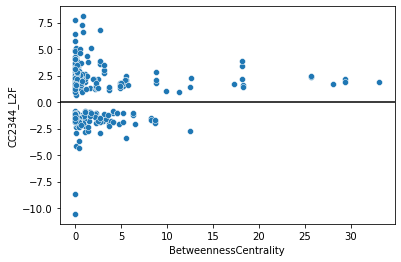

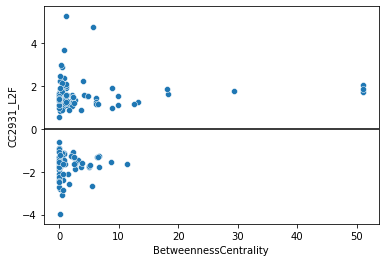

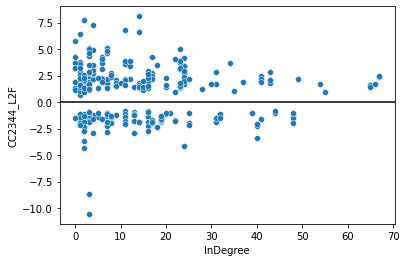

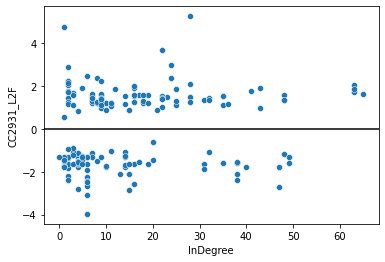

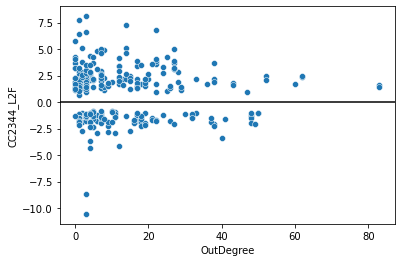

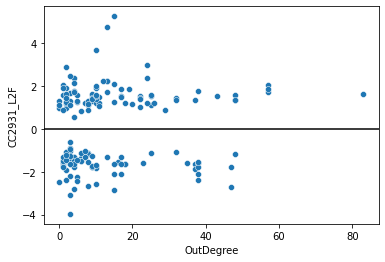

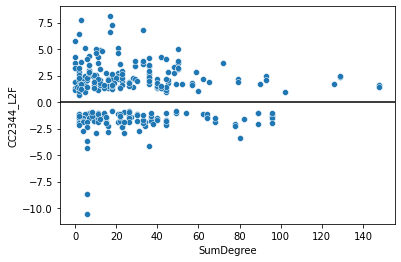

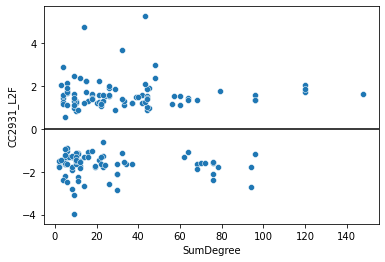

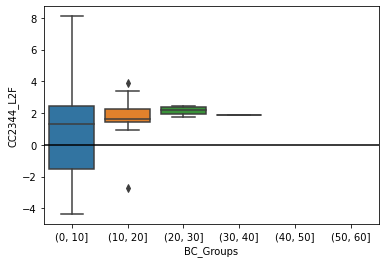

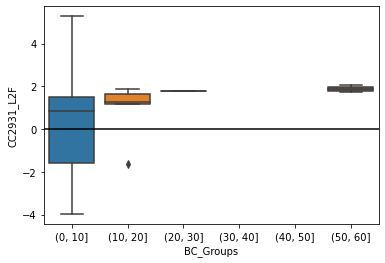

<Figure size 432x288 with 0 Axes>

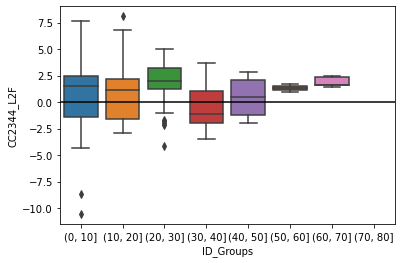

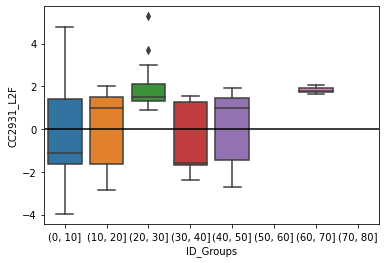

<Figure size 432x288 with 0 Axes>

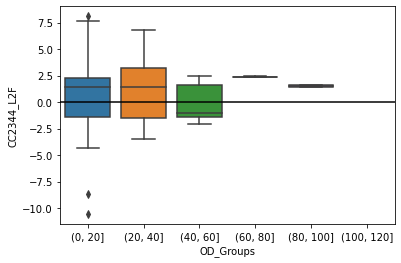

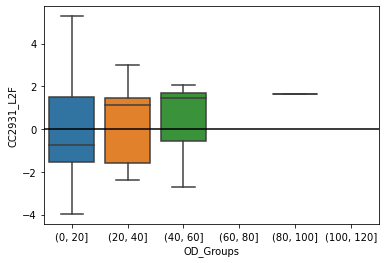

<Figure size 432x288 with 0 Axes>

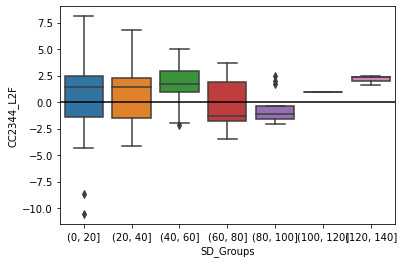

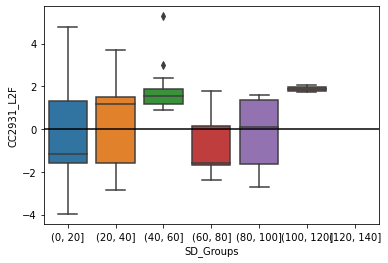

<Figure size 432x288 with 0 Axes>

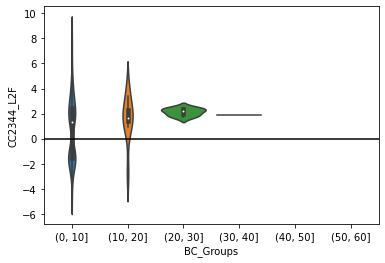

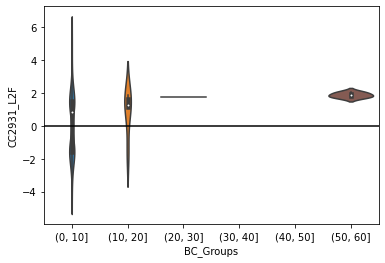

<Figure size 432x288 with 0 Axes>

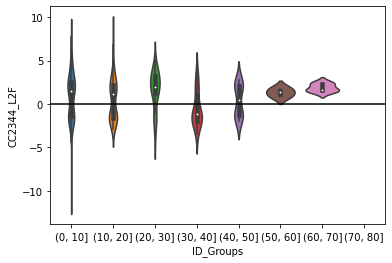

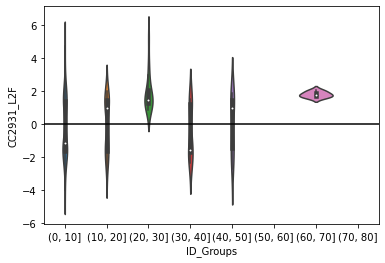

<Figure size 432x288 with 0 Axes>

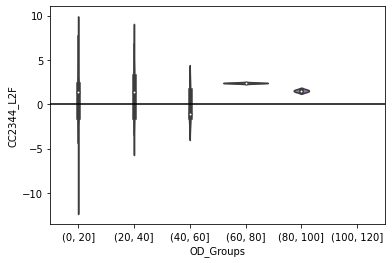

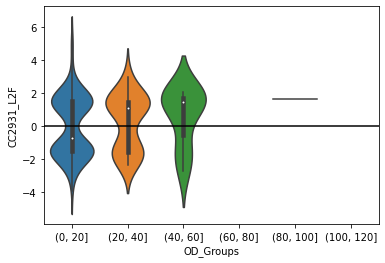

<Figure size 432x288 with 0 Axes>

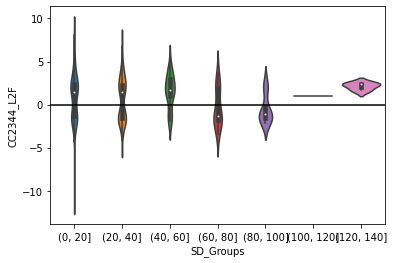

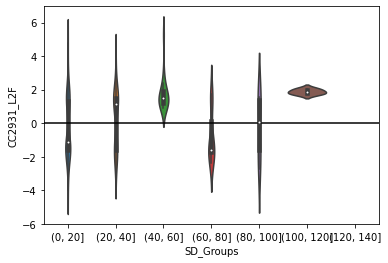

<Figure size 432x288 with 0 Axes>

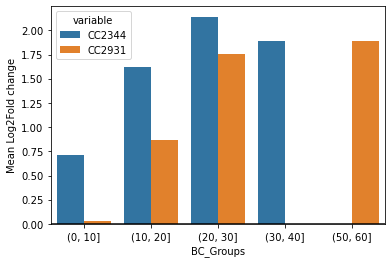

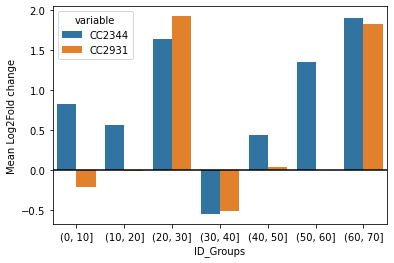

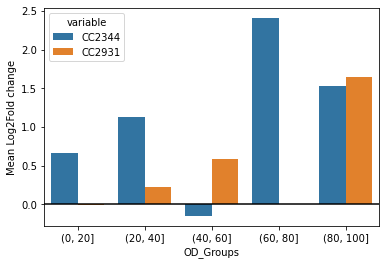

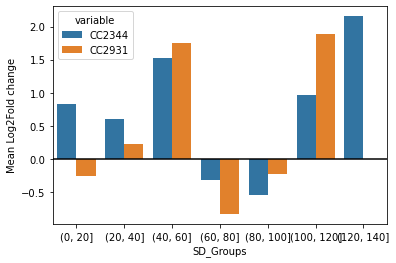

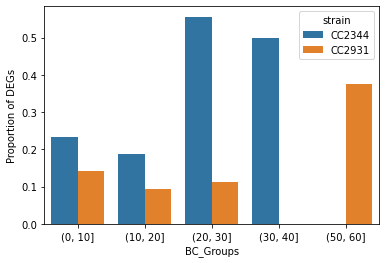

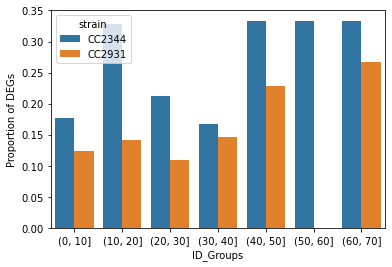

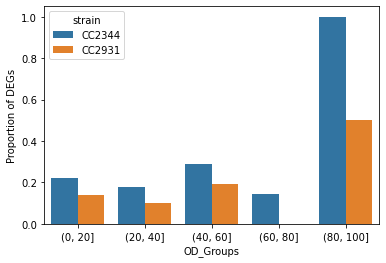

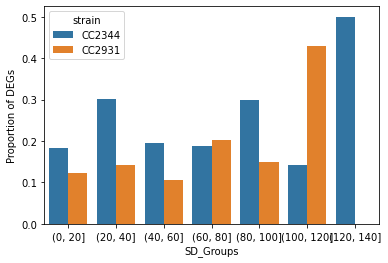

In [21]:
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
total = CC2344 + CC2931

CC2344_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2344_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
CC2931_log2Fold = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/raw_counts/CC2931_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
centrality = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/divergence/files/network_divergence.csv', delimiter = '\t', index_col = 'v6')

#### CATEGORIZING GENES ACCORDING TO THEIR CENTRALITY ####
centrality['BC_Groups'] = pd.cut(centrality['BetweennessCentrality'], bins = [0, 10, 20, 30, 40 , 50 , 60])
centrality['ID_Groups'] = pd.cut(centrality['InDegree'], bins = [i for i in range(0, 90, 10)])
centrality['OD_Groups'] = pd.cut(centrality['OutDegree'], bins = [i for i in range(0, 140, 20)])
centrality['SD_Groups'] = pd.cut(centrality['SumDegree'], bins = [i for i in range(0, 160, 20)])

DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes1.csv', delimiter = ',')
DEGs = DEGs.reset_index()
DEGs = pd.melt(DEGs, id_vars = 'index', value_vars = DEGs.columns[1:])
DEGs = DEGs.dropna().rename(columns = {'variable':'sample'})

for i in list(DEGs.index.values):
    if 'CC2344' in DEGs.at[i, 'sample']:
        DEGs.at[i, 'CC2344_L2F'] = CC2344_log2Fold.at[DEGs.at[i, 'value'], DEGs.at[i, 'sample']]
    if 'CC2931' in DEGs.at[i, 'sample']:
        DEGs.at[i, 'CC2931_L2F'] = CC2931_log2Fold.at[DEGs.at[i, 'value'], DEGs.at[i, 'sample']]
        
DEGs = DEGs.set_index('value').join(centrality)

for i in ['BetweennessCentrality', 'InDegree', 'OutDegree', 'SumDegree']:
    plt.figure()
    sns.scatterplot(data = DEGs, x = i, y = 'CC2344_L2F')
    plt.axhline(0, color = 'black')
    plt.figure()
    sns.scatterplot(data = DEGs, x = i, y = 'CC2931_L2F')
    plt.axhline(0, color = 'black')
    
for i in ['BC_Groups', 'ID_Groups', 'OD_Groups', 'SD_Groups']:
    plt.figure()
    sns.boxplot(data = DEGs, x = i, y = 'CC2344_L2F')
    plt.axhline(0, color = 'black')
    plt.figure()
    sns.boxplot(data = DEGs, x = i, y = 'CC2931_L2F')
    plt.axhline(0, color = 'black')
    plt.figure()
    
for i in ['BC_Groups', 'ID_Groups', 'OD_Groups', 'SD_Groups']:
    plt.figure()
    sns.violinplot(data = DEGs, x = i, y = 'CC2344_L2F')
    plt.axhline(0, color = 'black')
    plt.figure()
    sns.violinplot(data = DEGs, x = i, y = 'CC2931_L2F')
    plt.axhline(0, color = 'black')
    plt.figure()
    
#### DIVIDING DEGS INTO STRAINS ####
CC2344_DEGs = DEGs.loc[DEGs['sample'].isin(CC2344)]
CC2931_DEGs = DEGs.loc[DEGs['sample'].isin(CC2931)]

#### LIST OF ORDERED GROUPS ARRANGED ####
group_list = CC2344_DEGs['OD_Groups'].dropna()
group_list = group_list.unique()
lis = [0, 1, 2, 4, 3]
OD_list = [group_list[i] for i in lis]

group_list = CC2344_DEGs['ID_Groups'].dropna()
group_list = group_list.unique()
lis = [0, 1, 2, 3, 4, 6, 5]
ID_list = [group_list[i] for i in lis]

group_list = CC2344_DEGs['BC_Groups'].dropna()
group_list = group_list.unique()
lis = [0, 2, 3, 1]
BC_list = [group_list[i] for i in lis]

group_list = CC2344_DEGs['SD_Groups'].dropna()
group_list = group_list.unique()
lis = [0, 1, 2, 3, 4, 6, 5]
SD_list = [group_list[i] for i in lis]

CC2344_ordered_list = {'OD_Groups':OD_list, 'ID_Groups':ID_list, 'BC_Groups':BC_list, 'SD_Groups':SD_list}

group_list = CC2931_DEGs['OD_Groups'].dropna()
group_list = group_list.unique()
lis = [1, 0, 2, 3]
OD_list = [group_list[i] for i in lis]

group_list = CC2931_DEGs['ID_Groups'].dropna()
group_list = group_list.unique()
lis = [0, 1, 2, 5, 3, 4]
ID_list = [group_list[i] for i in lis]

group_list = CC2931_DEGs['BC_Groups'].dropna()
group_list = group_list.unique()
lis = [0, 1, 3, 2]
BC_list = [group_list[i] for i in lis]

group_list = CC2931_DEGs['SD_Groups'].dropna()
group_list = group_list.unique()
lis = [1, 0, 2, 4, 3, 5]
SD_list = [group_list[i] for i in lis]

CC2931_ordered_list = {'OD_Groups':OD_list, 'ID_Groups':ID_list, 'BC_Groups':BC_list, 'SD_Groups':SD_list}

#### LIST OF ALL VARIANCES PER GROUP ####
CC2344_BC_Groups = []
for i in CC2344_ordered_list['BC_Groups']:
    group = CC2344_DEGs.loc[CC2344_DEGs['BC_Groups'] == i]
    CC2344_BC_Groups.append(group['CC2344_L2F'].dropna().values.tolist())
    
CC2344_ID_Groups = []
for i in CC2344_ordered_list['ID_Groups']:
    group = CC2344_DEGs.loc[CC2344_DEGs['ID_Groups'] == i]
    CC2344_ID_Groups.append(group['CC2344_L2F'].dropna().values.tolist())
    
CC2344_OD_Groups = []
for i in CC2344_ordered_list['OD_Groups']:
    group = CC2344_DEGs.loc[CC2344_DEGs['OD_Groups'] == i]
    CC2344_OD_Groups.append(group['CC2344_L2F'].dropna().values.tolist())
    
CC2344_SD_Groups = []
for i in CC2344_ordered_list['SD_Groups']:
    group = CC2344_DEGs.loc[CC2344_DEGs['SD_Groups'] == i]
    CC2344_SD_Groups.append(group['CC2344_L2F'].dropna().values.tolist())

CC2931_BC_Groups = []
for i in CC2931_ordered_list['BC_Groups']:
    group = CC2931_DEGs.loc[CC2931_DEGs['BC_Groups'] == i]
    CC2931_BC_Groups.append(group['CC2931_L2F'].dropna().values.tolist())
    
CC2931_ID_Groups = []
for i in CC2931_ordered_list['ID_Groups']:
    group = CC2931_DEGs.loc[CC2931_DEGs['ID_Groups'] == i]
    CC2931_ID_Groups.append(group['CC2931_L2F'].dropna().values.tolist())
    
CC2931_OD_Groups = []
for i in CC2931_ordered_list['OD_Groups']:
    group = CC2931_DEGs.loc[CC2931_DEGs['OD_Groups'] == i]
    CC2931_OD_Groups.append(group['CC2931_L2F'].dropna().values.tolist())
    
CC2931_SD_Groups = []
for i in CC2931_ordered_list['SD_Groups']:
    group = CC2931_DEGs.loc[CC2931_DEGs['SD_Groups'] == i]
    CC2931_SD_Groups.append(group['CC2931_L2F'].dropna().values.tolist())

#### TESTING IF THE MEDIAN OF DISTRIBUTION IS ALL EQUAL - Kruskal-Wallis #### - Assumes that the sample came from identical dist. or dist. with identical median
display(stats.kruskal(CC2344_BC_Groups[0], CC2344_BC_Groups[1], CC2344_BC_Groups[2], CC2344_BC_Groups[3])) ## NOT SIG
display(stats.kruskal(CC2344_ID_Groups[0], CC2344_ID_Groups[1], CC2344_ID_Groups[2], CC2344_ID_Groups[3], CC2344_ID_Groups[4], CC2344_ID_Groups[5], CC2344_ID_Groups[6])) ## SIG
display(stats.kruskal(CC2344_OD_Groups[0], CC2344_OD_Groups[1], CC2344_OD_Groups[2], CC2344_OD_Groups[3], CC2344_OD_Groups[4])) ## NOT SIG 
display(stats.kruskal(CC2344_SD_Groups[0], CC2344_SD_Groups[1], CC2344_SD_Groups[2], CC2344_SD_Groups[3], CC2344_SD_Groups[4], CC2344_SD_Groups[5])) ## NOT SIG 

display(stats.kruskal(CC2931_BC_Groups[0], CC2931_BC_Groups[1], CC2931_BC_Groups[2], CC2931_BC_Groups[3])) ## NOT SIG
display(stats.kruskal(CC2931_ID_Groups[0], CC2931_ID_Groups[1], CC2931_ID_Groups[2], CC2931_ID_Groups[3], CC2931_ID_Groups[4], CC2931_ID_Groups[5])) ## SIG
display(stats.kruskal(CC2931_OD_Groups[0], CC2931_OD_Groups[1], CC2931_OD_Groups[2], CC2931_OD_Groups[3])) ## NOT SIG
display(stats.kruskal(CC2931_SD_Groups[0], CC2931_SD_Groups[1], CC2931_SD_Groups[2], CC2931_SD_Groups[3], CC2931_SD_Groups[4], CC2931_SD_Groups[5])) ## SIG 

#### FLIGNER KILLEEN TEST FOR HOMOGENIETY OF VARIANCE ####
display(stats.fligner(CC2344_BC_Groups[0], CC2344_BC_Groups[1], CC2344_BC_Groups[2], CC2344_BC_Groups[3])) ## SIG
display(stats.fligner(CC2344_ID_Groups[0], CC2344_ID_Groups[1], CC2344_ID_Groups[2], CC2344_ID_Groups[3], CC2344_ID_Groups[4], CC2344_ID_Groups[5], CC2344_ID_Groups[6])) ## SIG
display(stats.fligner(CC2344_OD_Groups[0], CC2344_OD_Groups[1], CC2344_OD_Groups[2], CC2344_OD_Groups[3], CC2344_OD_Groups[4])) ## SIG
display(stats.fligner(CC2344_SD_Groups[0], CC2344_SD_Groups[1], CC2344_SD_Groups[2], CC2344_SD_Groups[3], CC2344_SD_Groups[4], CC2344_SD_Groups[5])) ## NOT SIG 

display(stats.fligner(CC2931_BC_Groups[0], CC2931_BC_Groups[1], CC2931_BC_Groups[2], CC2931_BC_Groups[3])) ## SIG
display(stats.fligner(CC2931_ID_Groups[0], CC2931_ID_Groups[1], CC2931_ID_Groups[2], CC2931_ID_Groups[3], CC2931_ID_Groups[4], CC2931_ID_Groups[5])) ## NOT SIG
display(stats.fligner(CC2931_OD_Groups[0], CC2931_OD_Groups[1], CC2931_OD_Groups[2], CC2931_OD_Groups[3])) ## NOT SIG
display(stats.fligner(CC2931_SD_Groups[0], CC2931_SD_Groups[1], CC2931_SD_Groups[2], CC2931_SD_Groups[3], CC2931_SD_Groups[4], CC2931_SD_Groups[5])) ## NOT SIG 

#### MEAN CHANGE PER BIN ####
mean_change = pd.DataFrame()

group = CC2344_DEGs.groupby('OD_Groups')
for a in CC2344_ordered_list['OD_Groups']:
    mean_change.at['OD_Groups' + '_' + str(a), 'CC2344'] = group.get_group(a)['CC2344_L2F'].mean()
group = CC2931_DEGs.groupby('OD_Groups')
for b in CC2931_ordered_list['OD_Groups']:
    mean_change.at['OD_Groups' + '_' + str(b), 'CC2931'] = group.get_group(b)['CC2931_L2F'].mean()
    
group = CC2344_DEGs.groupby('ID_Groups')
for a in CC2344_ordered_list['ID_Groups']:
    mean_change.at['ID_Groups' + '_' + str(a), 'CC2344'] = group.get_group(a)['CC2344_L2F'].mean()
group = CC2931_DEGs.groupby('ID_Groups')
for b in CC2931_ordered_list['ID_Groups']:
    mean_change.at['ID_Groups' + '_' + str(b), 'CC2931'] = group.get_group(b)['CC2931_L2F'].mean()

group = CC2344_DEGs.groupby('BC_Groups')
for a in CC2344_ordered_list['BC_Groups']:
    mean_change.at['BC_Groups' + '_' + str(a), 'CC2344'] = group.get_group(a)['CC2344_L2F'].mean()
group = CC2931_DEGs.groupby('BC_Groups')
for b in CC2931_ordered_list['BC_Groups']:
    mean_change.at['BC_Groups' + '_' + str(b), 'CC2931'] = group.get_group(b)['CC2931_L2F'].mean()
    
group = CC2344_DEGs.groupby('SD_Groups')
for a in CC2344_ordered_list['SD_Groups']:
    mean_change.at['SD_Groups' + '_' + str(a), 'CC2344'] = group.get_group(a)['CC2344_L2F'].mean()
group = CC2931_DEGs.groupby('SD_Groups')
for b in CC2931_ordered_list['SD_Groups']:
    mean_change.at['SD_Groups' + '_' + str(b), 'CC2931'] = group.get_group(b)['CC2931_L2F'].mean()
display(mean_change)

mean_change = mean_change.reset_index()
for i in mean_change.index.values:
    if 'OD_Groups' in mean_change.at[i, 'index']:
        mean_change.at[i, 'Groups'] = 'OD_Groups'
    if 'ID_Groups' in mean_change.at[i, 'index']:
        mean_change.at[i, 'Groups'] = 'ID_Groups'
    if 'BC_Groups' in mean_change.at[i, 'index']:
        mean_change.at[i, 'Groups'] = 'BC_Groups'
    if 'SD_Groups' in mean_change.at[i, 'index']:
        mean_change.at[i, 'Groups'] = 'SD_Groups'
mean_change['index'] = mean_change['index'].replace({'OD_Groups_':'', 'ID_Groups_':'', 'BC_Groups_':'', 'SD_Groups_':''}, regex = True)
display(mean_change)

mean_change_1 = pd.melt(mean_change, id_vars = ['Groups', 'index'], value_vars = ['CC2344', 'CC2931'])

for i in ['BC_Groups', 'ID_Groups', 'OD_Groups', 'SD_Groups']:
    plt.figure()
    sns.barplot(data = mean_change_1.loc[mean_change_1['Groups'] == i], x = 'index', y = 'value', hue = 'variable')
    plt.axhline(0, color = 'black')
    plt.xlabel(i)
    plt.ylabel('Mean Log2Fold change')

#### PROPORTION OF DEGS IN EACH BIN ####
prop_of_DEGs = pd.DataFrame()

for i in ['BC_Groups', 'ID_Groups', 'OD_Groups', 'SD_Groups']:
    CC2344_grouped = CC2344_gene_network.groupby(i)
    CC2344_DEGs_grouped = CC2344_DEGs.groupby(i)
    for a in CC2344_ordered_list[i]:
        prop_of_DEGs.at[i + '_'+ str(a), 'CC2344_proportion'] = len(CC2344_DEGs_grouped.get_group(a))/len(CC2344_grouped.get_group(a))
    CC2931_grouped = CC2931_gene_network.groupby(i)
    CC2931_DEGs_grouped = CC2931_DEGs.groupby(i)
    for b in CC2931_ordered_list[i]:
        prop_of_DEGs.at[i + '_'+ str(b), 'CC2931_proportion'] = len(CC2931_DEGs_grouped.get_group(b))/len(CC2931_grouped.get_group(b))
prop_of_DEGs = prop_of_DEGs.replace(np.nan, 0).reset_index()

for i in ['BC_Groups', 'ID_Groups', 'OD_Groups', 'SD_Groups']:
    for a in prop_of_DEGs.index.values:
        if i in prop_of_DEGs.at[a, 'index']:
            prop_of_DEGs.at[a, 'groups'] = i
            
prop_of_DEGs = pd.melt(prop_of_DEGs, id_vars = ['groups', 'index'], value_vars = ['CC2344_proportion', 'CC2931_proportion'])
prop_of_DEGs['index'] = prop_of_DEGs['index'].replace({'BC_Groups_':'', 'ID_Groups_':'', 'OD_Groups_':'', 'SD_Groups_':''}, regex = True)

for i in prop_of_DEGs.index.values:
    if 'CC2344' in prop_of_DEGs.at[i, 'variable']:
        prop_of_DEGs.at[i, 'strain'] = 'CC2344'
    if 'CC2931' in prop_of_DEGs.at[i, 'variable']:
        prop_of_DEGs.at[i, 'strain'] = 'CC2931'
    
for i in ['BC_Groups', 'ID_Groups', 'OD_Groups', 'SD_Groups']:
    plt.figure()
    sns.barplot(data = prop_of_DEGs.loc[prop_of_DEGs['groups'] == i], x = 'index', y = 'value', hue = 'strain')
    plt.xlabel(i)
    plt.ylabel('Proportion of DEGs')

### CENTRALITY VS DIVERGENCE

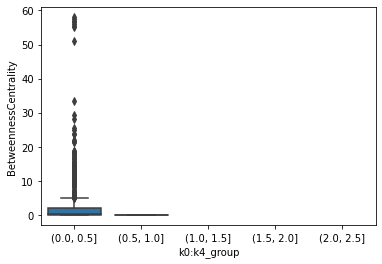

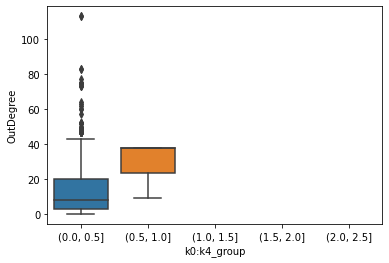

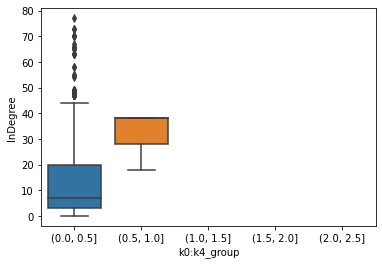

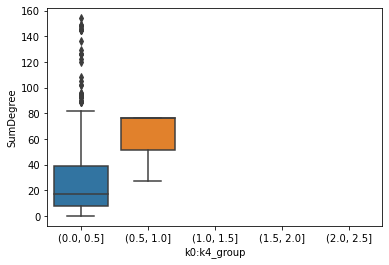

In [25]:
#### PLOTTING ####
centrality['k0:k4_group'] = pd.cut(centrality['k0:k4'], bins = [0, 0.5, 1, 1.5, 2, 2.5])
for i in ['BetweennessCentrality', 'OutDegree', 'InDegree', 'SumDegree']:
    plt.figure()
    sns.boxplot(data = centrality, x = 'k0:k4_group', y = i)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/k0:k4_vs_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
#### MANN WHITNEY U TEST ####
group_list = centrality['k0:k4_group'].dropna()
group_list = group_list.unique()

results_pval = pd.DataFrame(columns = ['BetweennessCentrality', 'OutDegree', 'InDegree', 'SumDegree'])

for e in ['BetweennessCentrality', 'OutDegree', 'InDegree', 'SumDegree']:
    for i in range(len(group_list[:-1])):
        edited_centrality = centrality.groupby('k0:k4_group')
        section_1 = edited_centrality.get_group(group_list[i])
        section_3 = section_1[e].values.tolist()
        section_2 = edited_centrality.get_group(group_list[i+1])
        section_4 = section_2[e].values.tolist()
        t_stat, pval = mannwhitneyu(section_3, section_4)
        results_pval.at[str(group_list[i]) + '-' + str(group_list[i+1]), e] = pval
        
for e in ['BetweennessCentrality', 'OutDegree', 'InDegree', 'SumDegree']:
    section_1 = edited_centrality.get_group(group_list[0])
    section_3 = section_1[e].values.tolist()
    section_2 = edited_centrality.get_group(group_list[3])
    section_4 = section_2[e].values.tolist()
    t_stat, pval = mannwhitneyu(section_3, section_4)
    results_pval.at[str(group_list[0]) + '-' + str(group_list[3]), e] = pval

    section_1 = edited_centrality.get_group(group_list[1])
    section_3 = section_1[e].values.tolist()
    section_2 = edited_centrality.get_group(group_list[3])
    section_4 = section_2[e].values.tolist()
    t_stat, pval = mannwhitneyu(section_3, section_4)
    results_pval.at[str(group_list[1]) + '-' + str(group_list[3]), e] = pval

### HIGH AND LOW EXPRESSION GENES VS CENTRALITY

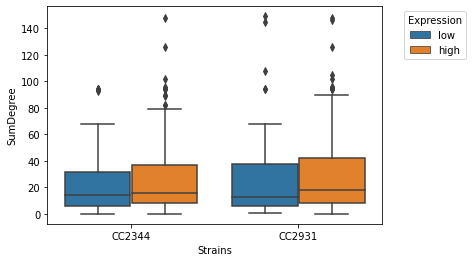

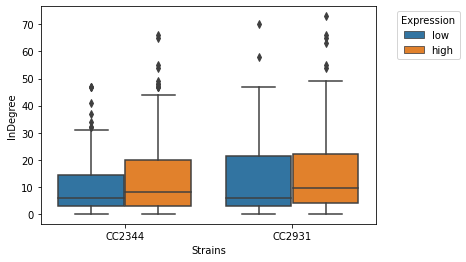

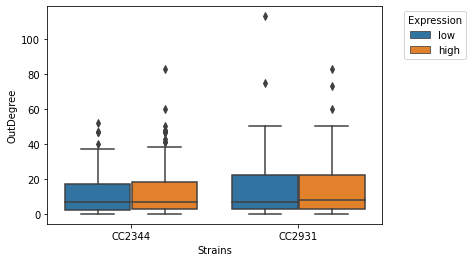

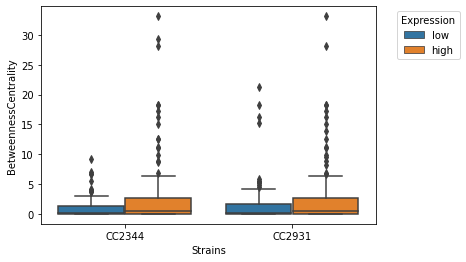

In [17]:
#### TARGET COLUMNS ####
column = ['SumDegree', 'InDegree', 'OutDegree', 'BetweennessCentrality']

CC2344_low = CC2344_gene_network[column].loc[CC2344_low_exp]
CC2344_low['expression'] = 'low'
CC2344_low['sample'] = 'CC2344'
CC2344_high = CC2344_gene_network[column].loc[CC2344_hi_exp]
CC2344_high['expression'] = 'high'
CC2344_high['sample'] = 'CC2344'
CC2931_low = CC2931_gene_network[column].loc[CC2931_low_exp]
CC2931_low['expression'] = 'low'
CC2931_low['sample'] = 'CC2931'
CC2931_high = CC2931_gene_network[column].loc[CC2931_hi_exp]
CC2931_high['expression'] = 'high'
CC2931_high['sample'] = 'CC2931'

centrality_plot = pd.concat([CC2344_low, CC2344_high, CC2931_low, CC2931_high], axis = 0)

#### RESULTS TABLE ####
results = pd.DataFrame(index = column, columns = ['CC2344_low_median', 'CC2344_high_median', 'CC2344_mannwhit_pval', 
                                                                             'CC2931_low_median', 'CC2931_high_median', 'CC2931_mannwhit_pval', 
                                                                             'CC2931_low_iqr', 'CC2344_low_iqr', 'CC2931_high_iqr', 'CC2344_high_iqr'])
for i in column:
    results.at[i, 'CC2931_low_median'] = CC2931_low[i].median()
    results.at[i, 'CC2931_high_median'] = CC2931_high[i].median()
    results.at[i, 'CC2344_low_median'] =  CC2344_low[i].median()
    results.at[i, 'CC2344_high_median'] = CC2344_high[i].median()
    
    results.at[i, 'CC2931_low_iqr'] = iqr(CC2931_low[i].dropna())
    results.at[i, 'CC2931_high_iqr'] = iqr(CC2931_high[i].dropna())
    results.at[i, 'CC2344_low_iqr'] = iqr(CC2344_low[i].dropna())
    results.at[i, 'CC2344_high_iqr'] = iqr(CC2344_high[i].dropna())

#### PLOTS ####
for i in column: ### SIGNIFICANT IN ALL PLOTS, WITH MEDIAN HIGH EXPRESSION LARGER THAN MEDIAN LOW EXPRESSION
    plt.figure()
    sns.boxplot(data = centrality_plot, x = 'sample', y = i, hue = 'expression')
    plt.xlabel('Strains')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = 'Expression')
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/high_vs_low_expression_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    CC2344_ts, CC2344_p = mannwhitneyu(CC2344_high[i].values.tolist(), CC2344_low[i].values.tolist(), alternative = 'greater')
    results.at[i, 'CC2344_mannwhit_pval'] = CC2344_p
    CC2931_ts, CC2931_p = mannwhitneyu(CC2931_high[i].values.tolist(), CC2931_low[i].values.tolist(), alternative = 'greater')
    results.at[i, 'CC2931_mannwhit_pval'] = CC2931_p
display(results)

### MUTATIONAL VARIANCE VS CENTRALITY

<ipython-input-20-55212ac2ee16>:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15,5))


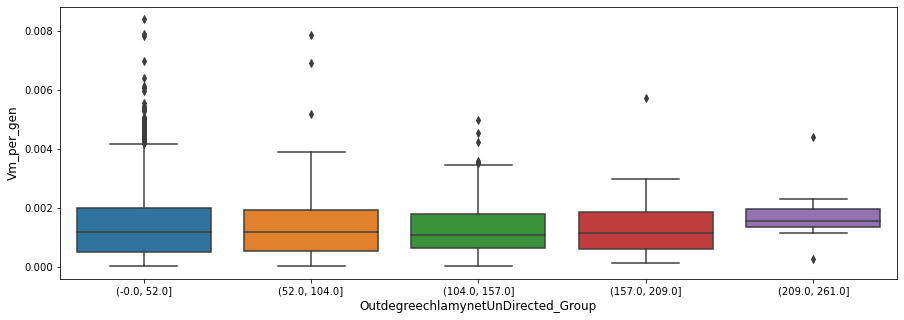

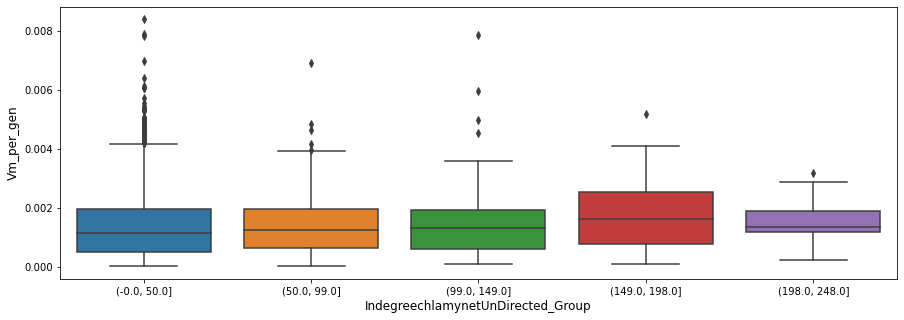

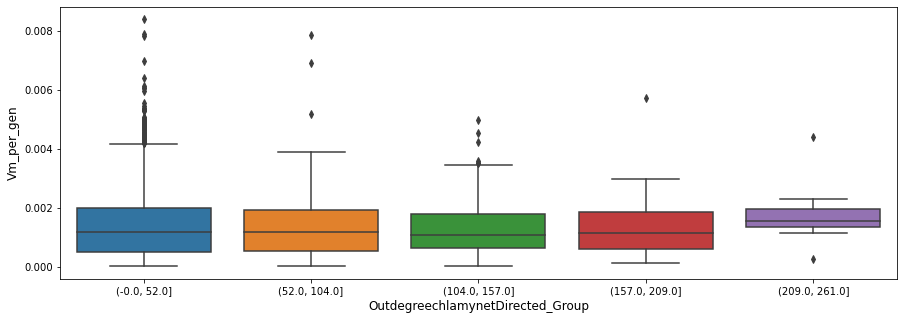

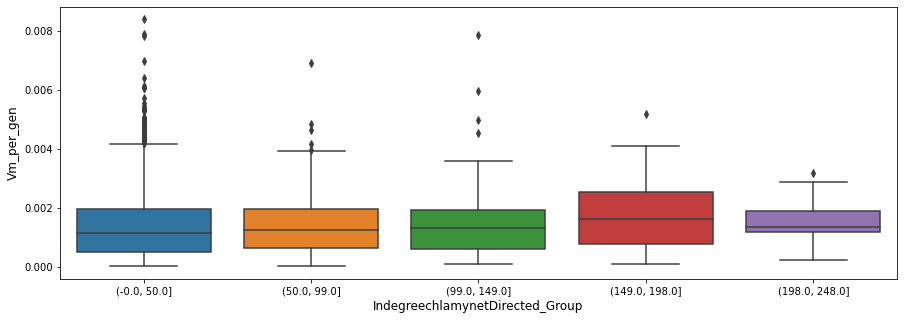

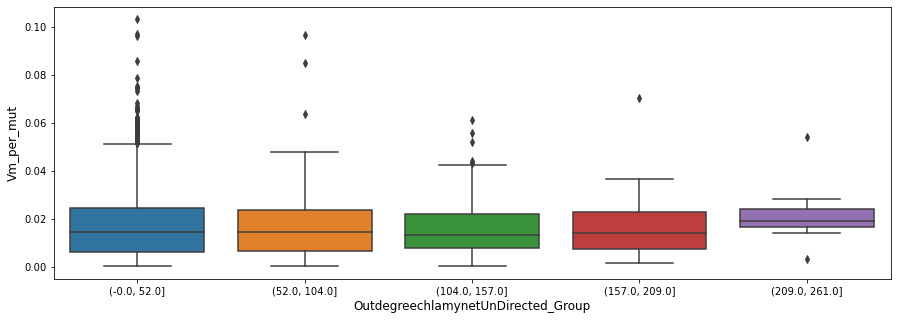

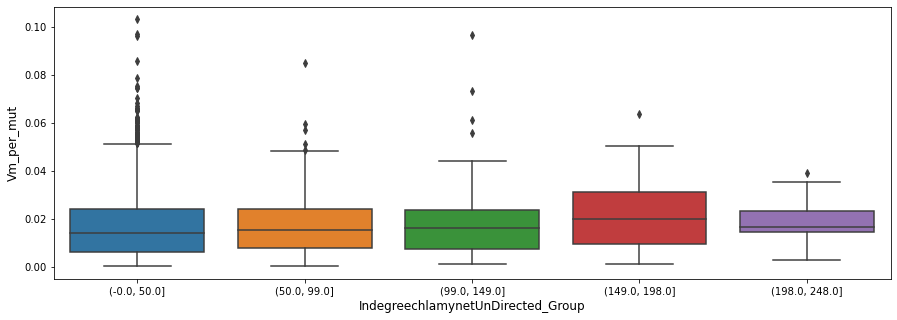

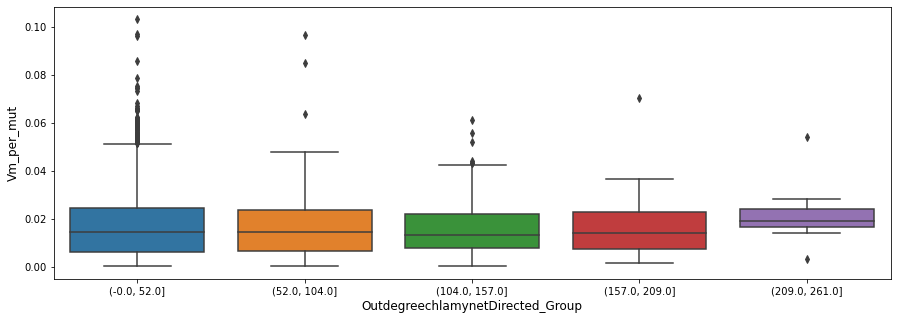

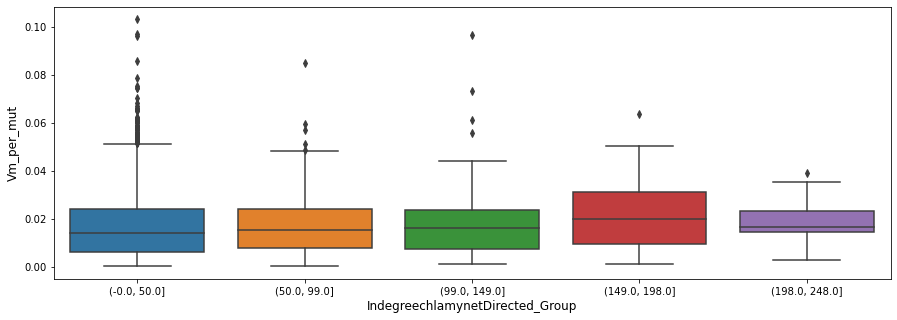

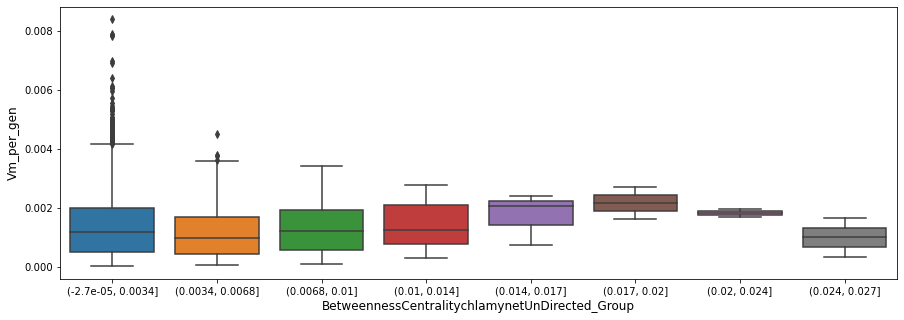

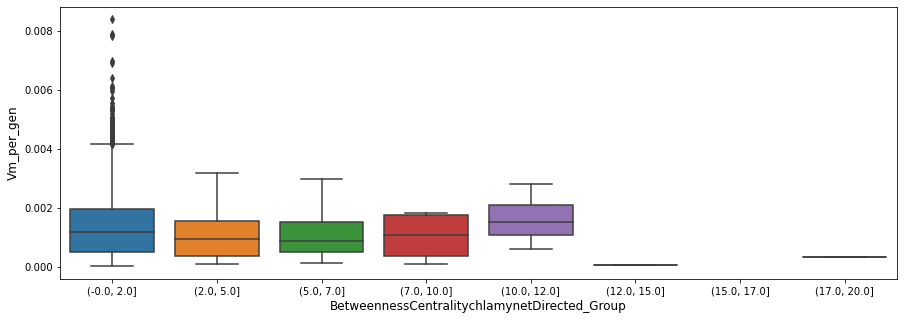

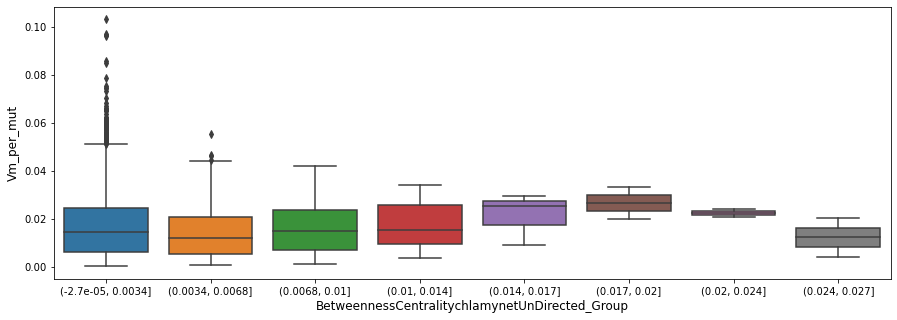

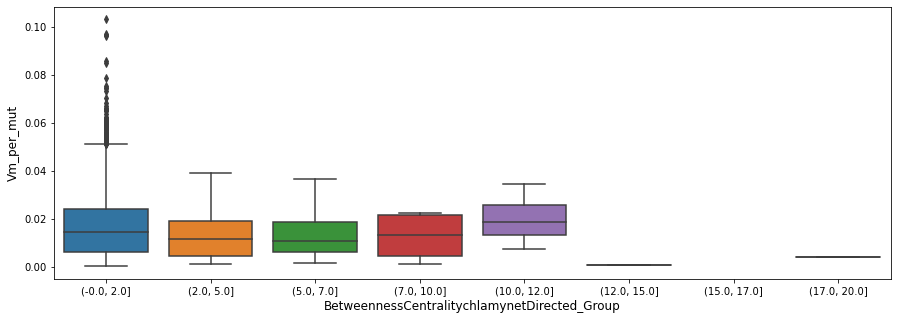

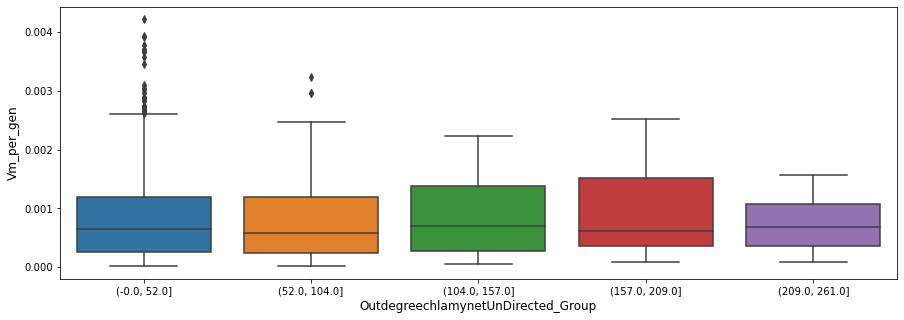

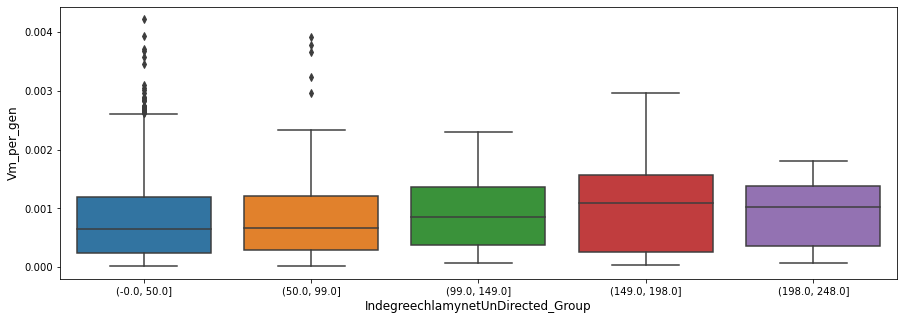

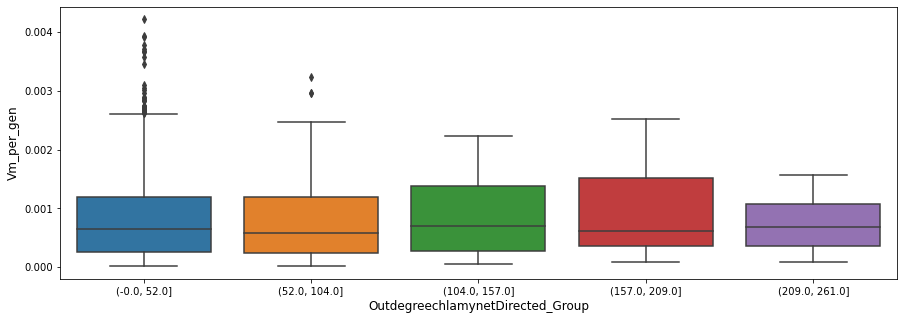

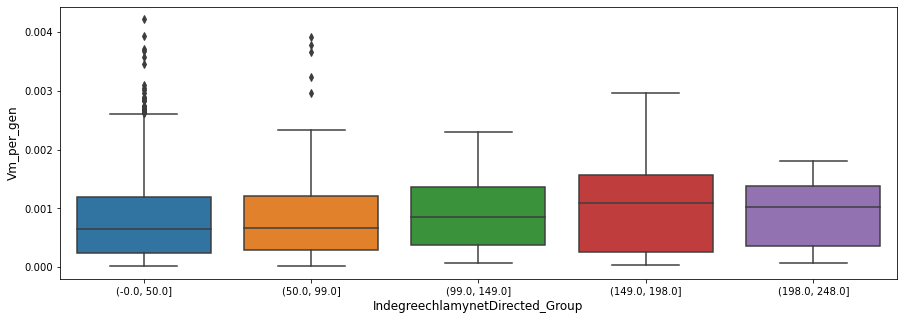

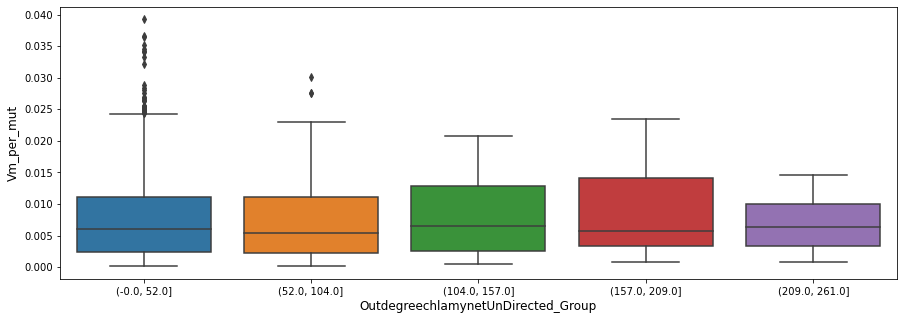

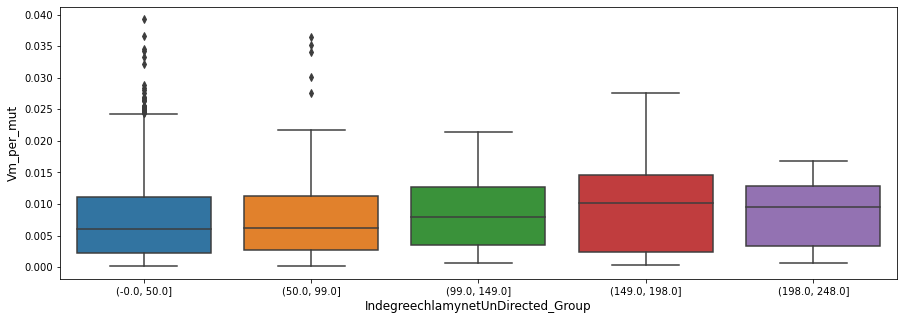

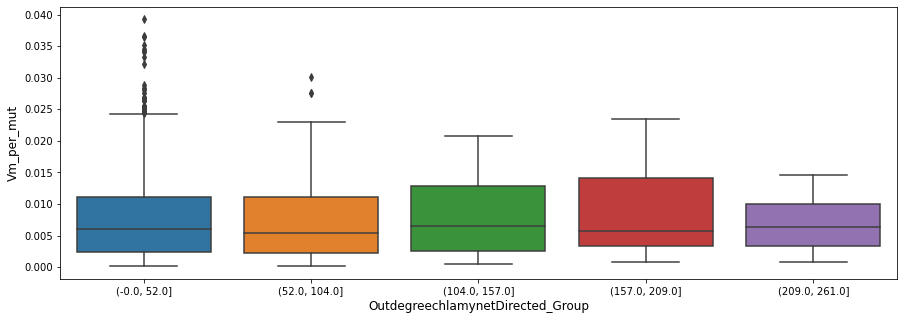

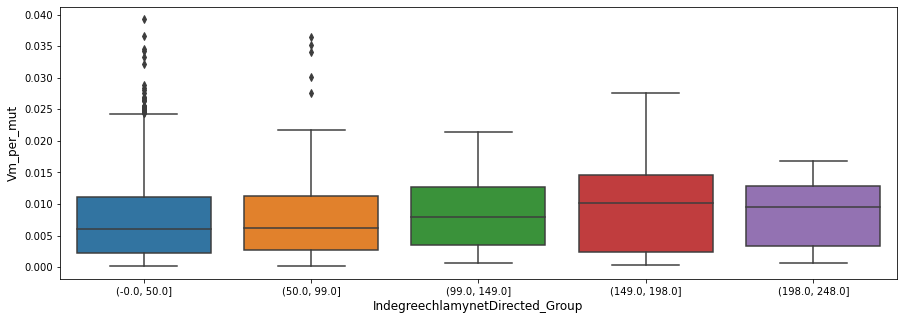

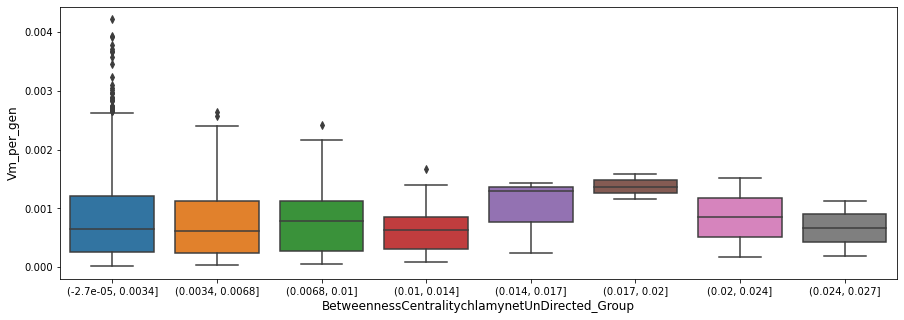

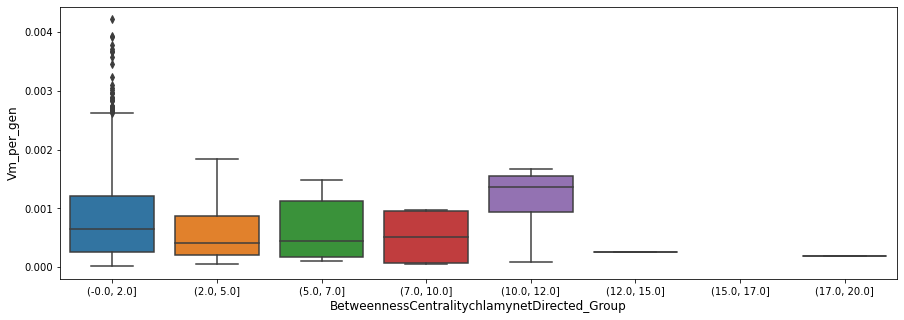

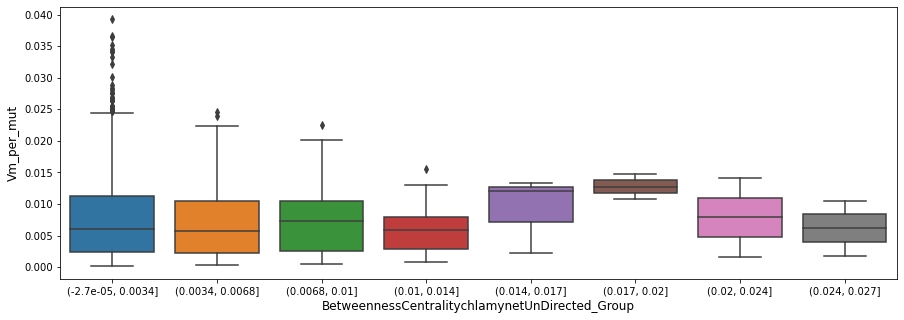

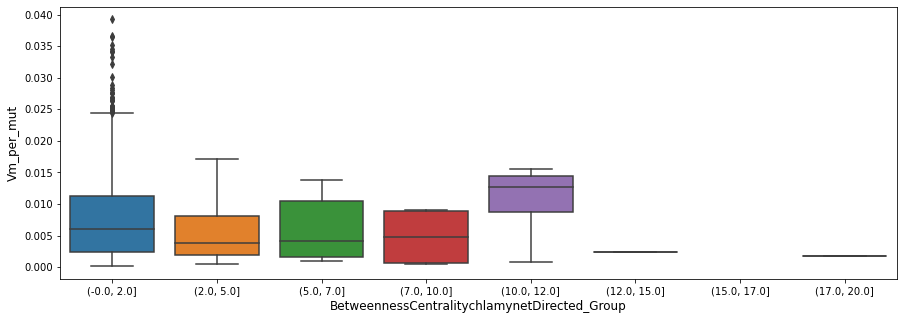

In [20]:
#### CREATING GROUPS ####
for i in ['OutdegreechlamynetUnDirected', 'IndegreechlamynetUnDirected', 'OutdegreechlamynetDirected', 'IndegreechlamynetDirected']:
    CC2344_gene_network[i + '_Group'] = pd.cut(CC2344_gene_network[i], 5, precision = 0)
for i in ['BetweennessCentralitychlamynetUnDirected', 'BetweennessCentralitychlamynetDirected']:
    CC2344_gene_network[i + '_Group'] = pd.cut(CC2344_gene_network[i], 8, precision = 0)
for i in ['OutdegreechlamynetUnDirected', 'IndegreechlamynetUnDirected', 'OutdegreechlamynetDirected', 'IndegreechlamynetDirected']:
    CC2931_gene_network[i + '_Group'] = pd.cut(CC2931_gene_network[i], 5, precision = 0)
for i in ['BetweennessCentralitychlamynetUnDirected', 'BetweennessCentralitychlamynetDirected']:
    CC2931_gene_network[i + '_Group'] = pd.cut(CC2931_gene_network[i], 8, precision = 0)

#### CC2344 ####
for i in ['OutdegreechlamynetUnDirected', 'IndegreechlamynetUnDirected', 'OutdegreechlamynetDirected', 'IndegreechlamynetDirected']:
    plt.figure(figsize=(15,5))
    ax = sns.boxplot(data = CC2344_gene_network, x = i + '_Group', y = 'Vm_per_gen')
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2344_Vm_per_gen_vs_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
for i in ['OutdegreechlamynetUnDirected', 'IndegreechlamynetUnDirected', 'OutdegreechlamynetDirected', 'IndegreechlamynetDirected']:
    plt.figure(figsize=(15,5))
    ax = sns.boxplot(data = CC2344_gene_network, x = i + '_Group', y = 'Vm_per_mut')
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2344_Vm_per_mut_vs_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

for i in ['BetweennessCentralitychlamynetUnDirected', 'BetweennessCentralitychlamynetDirected']:
    plt.figure(figsize=(15,5))
    ax = sns.boxplot(data = CC2344_gene_network, x = i + '_Group', y = 'Vm_per_gen')
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2344_Vm_per_gen_vs_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
for i in ['BetweennessCentralitychlamynetUnDirected', 'BetweennessCentralitychlamynetDirected']:
    plt.figure(figsize=(15,5))
    ax = sns.boxplot(data = CC2344_gene_network, x = i + '_Group', y = 'Vm_per_mut')
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2344_Vm_per_mut_vs_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### CC2931 ####
for i in ['OutdegreechlamynetUnDirected', 'IndegreechlamynetUnDirected', 'OutdegreechlamynetDirected', 'IndegreechlamynetDirected']:
    plt.figure(figsize=(15,5))
    ax = sns.boxplot(data = CC2931_gene_network, x = i + '_Group', y = 'Vm_per_gen')
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2931_Vm_per_gen_vs_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
for i in ['OutdegreechlamynetUnDirected', 'IndegreechlamynetUnDirected', 'OutdegreechlamynetDirected', 'IndegreechlamynetDirected']:
    plt.figure(figsize=(15,5))
    ax = sns.boxplot(data = CC2931_gene_network, x = i + '_Group', y = 'Vm_per_mut')
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2931_Vm_per_mut_vs_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
for i in ['BetweennessCentralitychlamynetUnDirected', 'BetweennessCentralitychlamynetDirected']:
    plt.figure(figsize=(15,5))
    ax = sns.boxplot(data = CC2931_gene_network, x = i + '_Group', y = 'Vm_per_gen')
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2931_Vm_per_gen_vs_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
for i in ['BetweennessCentralitychlamynetUnDirected', 'BetweennessCentralitychlamynetDirected']:
    plt.figure(figsize=(15,5))
    ax = sns.boxplot(data = CC2931_gene_network, x = i + '_Group', y = 'Vm_per_mut')
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2931_Vm_per_mut_vs_' + i + '.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
#### MANN WHITNEY U TEST BETWEEN CENTRALITY GROUPS ####
#######################################################

#### REORDERING THE GROUPS ####
outdegree_grouplist = CC2344_gene_network['OutdegreechlamynetUnDirected_Group'].dropna()
outdegree_grouplist = CC2344_gene_network['OutdegreechlamynetUnDirected_Group'].unique()
lis = [0, 2, 3, 1, 4]
outdegree_grouplist = [outdegree_grouplist[i] for i in lis]

indegree_grouplist = CC2344_gene_network['IndegreechlamynetUnDirected_Group'].dropna()
indegree_grouplist = CC2344_gene_network['IndegreechlamynetUnDirected_Group'].unique()
lis = [0, 1, 2, 4, 3]
indegree_grouplist = [indegree_grouplist[i] for i in lis]

undirected_centrality_grouplist = CC2344_gene_network['BetweennessCentralitychlamynetUnDirected_Group'].dropna()
undirected_centrality_grouplist = CC2344_gene_network['BetweennessCentralitychlamynetUnDirected_Group'].unique()
lis = [0, 2, 4, 1, 3, 5, 6, 7]
undirected_centrality_grouplist = [undirected_centrality_grouplist[i] for i in lis]

directed_centrality_grouplist = CC2344_gene_network['BetweennessCentralitychlamynetDirected_Group'].dropna()
directed_centrality_grouplist = CC2344_gene_network['BetweennessCentralitychlamynetDirected_Group'].unique()
lis = [0, 1, 3, 2, 5, 4, 6]
directed_centrality_grouplist = [directed_centrality_grouplist[i] for i in lis]

results = pd.DataFrame(columns = ['CC2344_pval_Vm_per_gen', 'CC2931_pval_Vm_per_gen', 'CC2344_pval_Vm_per_mut', 'CC2931_pval_Vm_per_mut'])

for a in ['OutdegreechlamynetUnDirected', 'OutdegreechlamynetDirected']:
    for e in ['CC2931_pval_Vm_per_gen', 'CC2931_pval_Vm_per_mut']:
        for i in range(len(outdegree_grouplist[:-1])):
            edited_CC2931 = CC2931_gene_network.groupby(a + '_Group')
            section_1 = edited_CC2931.get_group(outdegree_grouplist[i])
            section_3 = section_1['Vm_per_gen'].values.tolist()
            section_2 = edited_CC2931.get_group(outdegree_grouplist[i+1])
            section_4 = section_2['Vm_per_gen'].values.tolist()
            t_stat, pval = mannwhitneyu(section_3, section_4)
            results.at[a + '_' + str(outdegree_grouplist[i]) + '-' + str(outdegree_grouplist[i+1]), e] = pval
            if pval < 0.05:
                results.at[a + '_' + str(outdegree_grouplist[i]) + '-' + str(outdegree_grouplist[i+1]), e] = 'rejected'
            else:
                results.at[a + '_' + str(outdegree_grouplist[i]) + '-' + str(outdegree_grouplist[i+1]), e] = 'not rejected'
    for e in ['CC2344_pval_Vm_per_gen', 'CC2344_pval_Vm_per_mut']:
        for i in range(len(outdegree_grouplist[:-1])):
            edited_CC2344 = CC2344_gene_network.groupby(a + '_Group')
            section_1 = edited_CC2344.get_group(outdegree_grouplist[i])
            section_3 = section_1['Vm_per_gen'].values.tolist()
            section_2 = edited_CC2344.get_group(outdegree_grouplist[i+1])
            section_4 = section_2['Vm_per_gen'].values.tolist()
            t_stat, pval = mannwhitneyu(section_3, section_4)
            results.at[a + '_' + str(outdegree_grouplist[i]) + '-' + str(outdegree_grouplist[i+1]), e] = pval
            if pval < 0.05:
                results.at[a + '_' + str(outdegree_grouplist[i]) + '-' + str(outdegree_grouplist[i+1]), e] = 'rejected'
            else:
                results.at[a + '_' + str(outdegree_grouplist[i]) + '-' + str(outdegree_grouplist[i+1]), e] = 'not rejected'
                
for a in ['IndegreechlamynetUnDirected', 'IndegreechlamynetDirected']:
    for e in ['CC2931_pval_Vm_per_gen', 'CC2931_pval_Vm_per_mut']:
        for i in range(len(indegree_grouplist[:-1])):
            edited_CC2931 = CC2931_gene_network.groupby(a + '_Group')
            section_1 = edited_CC2931.get_group(indegree_grouplist[i])
            section_3 = section_1['Vm_per_gen'].values.tolist()
            section_2 = edited_CC2931.get_group(indegree_grouplist[i+1])
            section_4 = section_2['Vm_per_gen'].values.tolist()
            t_stat, pval = mannwhitneyu(section_3, section_4)
            results.at[a + '_' + str(indegree_grouplist[i]) + '-' + str(indegree_grouplist[i+1]), e] = pval
            if pval < 0.05:
                results.at[a + '_' + str(indegree_grouplist[i]) + '-' + str(indegree_grouplist[i+1]), e] = 'rejected'
            else:
                results.at[a + '_' + str(indegree_grouplist[i]) + '-' + str(indegree_grouplist[i+1]), e] = 'not rejected'
    
    for e in ['CC2344_pval_Vm_per_gen', 'CC2344_pval_Vm_per_mut']:
        for i in range(len(indegree_grouplist[:-1])):
            edited_CC2344 = CC2344_gene_network.groupby(a + '_Group')
            section_1 = edited_CC2344.get_group(indegree_grouplist[i])
            section_3 = section_1['Vm_per_gen'].values.tolist()
            section_2 = edited_CC2344.get_group(indegree_grouplist[i+1])
            section_4 = section_2['Vm_per_gen'].values.tolist()
            t_stat, pval = mannwhitneyu(section_3, section_4)
            results.at[a + '_' + str(indegree_grouplist[i]) + '-' + str(indegree_grouplist[i+1]), e] = pval
            if pval < 0.05:
                results.at[a + '_' + str(indegree_grouplist[i]) + '-' + str(indegree_grouplist[i+1]), e] = 'rejected'
            else:
                results.at[a + '_' + str(indegree_grouplist[i]) + '-' + str(indegree_grouplist[i+1]), e] = 'not rejected'
        
for e in ['CC2931_pval_Vm_per_gen', 'CC2931_pval_Vm_per_mut']:
    for i in range(len(undirected_centrality_grouplist[:-1])):
        edited_CC2931 = CC2931_gene_network.groupby('BetweennessCentralitychlamynetUnDirected_Group')
        section_1 = edited_CC2931.get_group(undirected_centrality_grouplist[i])
        section_3 = section_1['Vm_per_gen'].values.tolist()
        section_2 = edited_CC2931.get_group(undirected_centrality_grouplist[i+1])
        section_4 = section_2['Vm_per_gen'].values.tolist()
        t_stat, pval = mannwhitneyu(section_3, section_4)
        results.at['BetweennessCentralitychlamynetUnDirected_' + str(undirected_centrality_grouplist[i]) + '-' + str(undirected_centrality_grouplist[i+1]), e] = pval
        if pval < 0.05:
            results.at['BetweennessCentralitychlamynetUnDirected_' + str(undirected_centrality_grouplist[i]) + '-' + str(undirected_centrality_grouplist[i+1]), e] = 'rejected'
        else:
            results.at['BetweennessCentralitychlamynetUnDirected_' + str(undirected_centrality_grouplist[i]) + '-' + str(undirected_centrality_grouplist[i+1]), e] = 'not rejected'
for e in ['CC2344_pval_Vm_per_gen', 'CC2344_pval_Vm_per_mut']:
    for i in range(len(undirected_centrality_grouplist[:-1])):
        edited_CC2344 = CC2344_gene_network.groupby('BetweennessCentralitychlamynetUnDirected_Group')
        section_1 = edited_CC2344.get_group(undirected_centrality_grouplist[i])
        section_3 = section_1['Vm_per_gen'].values.tolist()
        section_2 = edited_CC2344.get_group(undirected_centrality_grouplist[i+1])
        section_4 = section_2['Vm_per_gen'].values.tolist()
        t_stat, pval = mannwhitneyu(section_3, section_4)
        results.at['BetweennessCentralitychlamynetUnDirected_' + str(undirected_centrality_grouplist[i]) + '-' + str(undirected_centrality_grouplist[i+1]), e] = pval
        if pval < 0.05:
            results.at['BetweennessCentralitychlamynetUnDirected_' + str(undirected_centrality_grouplist[i]) + '-' + str(undirected_centrality_grouplist[i+1]), e] = 'rejected'
        else:
            results.at['BetweennessCentralitychlamynetUnDirected_' + str(undirected_centrality_grouplist[i]) + '-' + str(undirected_centrality_grouplist[i+1]), e] = 'not rejected'

for e in ['CC2931_pval_Vm_per_gen', 'CC2931_pval_Vm_per_mut']:
    for i in range(len(directed_centrality_grouplist[:-1])):
        edited_CC2931 = CC2931_gene_network.groupby('BetweennessCentralitychlamynetDirected_Group')
        section_1 = edited_CC2931.get_group(directed_centrality_grouplist[i])
        section_3 = section_1['Vm_per_gen'].values.tolist()
        section_2 = edited_CC2931.get_group(directed_centrality_grouplist[i+1])
        section_4 = section_2['Vm_per_gen'].values.tolist()
        t_stat, pval = mannwhitneyu(section_3, section_4)
        results.at['BetweennessCentralitychlamynetDirected_' + str(directed_centrality_grouplist[i]) + '-' + str(directed_centrality_grouplist[i+1]), e] = pval
        if pval < 0.05:
            results.at['BetweennessCentralitychlamynetDirected_' + str(directed_centrality_grouplist[i]) + '-' + str(directed_centrality_grouplist[i+1]), e] = 'rejected'
        else:
            results.at['BetweennessCentralitychlamynetDirected_' + str(directed_centrality_grouplist[i]) + '-' + str(directed_centrality_grouplist[i+1]), e] = 'not rejected'
for e in ['CC2344_pval_Vm_per_gen', 'CC2344_pval_Vm_per_mut']:
    for i in range(len(directed_centrality_grouplist[:-1])):
        edited_CC2344 = CC2344_gene_network.groupby('BetweennessCentralitychlamynetDirected_Group')
        section_1 = edited_CC2344.get_group(directed_centrality_grouplist[i])
        section_3 = section_1['Vm_per_gen'].values.tolist()
        section_2 = edited_CC2344.get_group(directed_centrality_grouplist[i+1])
        section_4 = section_2['Vm_per_gen'].values.tolist()
        t_stat, pval = mannwhitneyu(section_3, section_4)
        results.at['BetweennessCentralitychlamynetDirected_' + str(directed_centrality_grouplist[i]) + '-' + str(directed_centrality_grouplist[i+1]), e] = pval
        if pval < 0.05:
            results.at['BetweennessCentralitychlamynetDirected_' + str(directed_centrality_grouplist[i]) + '-' + str(directed_centrality_grouplist[i+1]), e] = 'rejected'
        else:
            results.at['BetweennessCentralitychlamynetDirected_' + str(directed_centrality_grouplist[i]) + '-' + str(directed_centrality_grouplist[i+1]), e] = 'not rejected'

In [21]:
results

,CC2344_pval_Vm_per_gen,CC2931_pval_Vm_per_gen,CC2344_pval_Vm_per_mut,CC2931_pval_Vm_per_mut
"OutdegreechlamynetUnDirected_(-0.0, 52.0]-(52.0, 104.0]",not rejected,not rejected,not rejected,not rejected
"OutdegreechlamynetUnDirected_(52.0, 104.0]-(104.0, 157.0]",not rejected,not rejected,not rejected,not rejected
"OutdegreechlamynetUnDirected_(104.0, 157.0]-(157.0, 209.0]",not rejected,not rejected,not rejected,not rejected
"OutdegreechlamynetUnDirected_(157.0, 209.0]-(209.0, 261.0]",not rejected,not rejected,not rejected,not rejected
"OutdegreechlamynetDirected_(-0.0, 52.0]-(52.0, 104.0]",not rejected,not rejected,not rejected,not rejected
"OutdegreechlamynetDirected_(52.0, 104.0]-(104.0, 157.0]",not rejected,not rejected,not rejected,not rejected
"OutdegreechlamynetDirected_(104.0, 157.0]-(157.0, 209.0]",not rejected,not rejected,not rejected,not rejected
"OutdegreechlamynetDirected_(157.0, 209.0]-(209.0, 261.0]",not rejected,not rejected,not rejected,not rejected
"IndegreechlamynetUnDirected_(-0.0, 50.0]-(50.0, 99.0]",not rejected,not rejected,not rejected,not rejected
"IndegreechlamynetUnDirected_(50.0, 99.0]-(99.0, 149.0]",not rejected,not rejected,not rejected,not rejected


### CENTRALITY OF DEGS

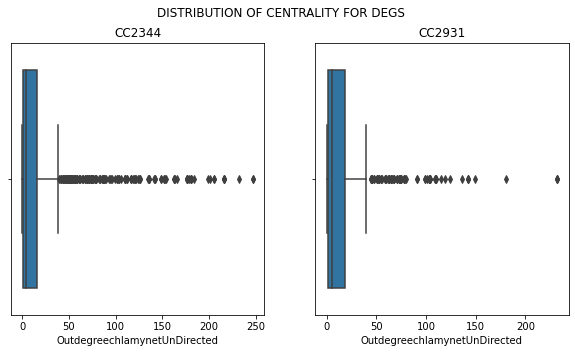

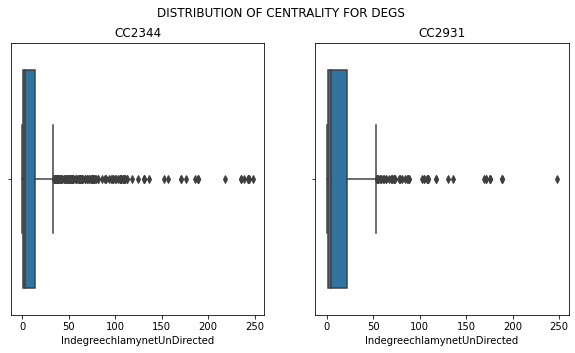

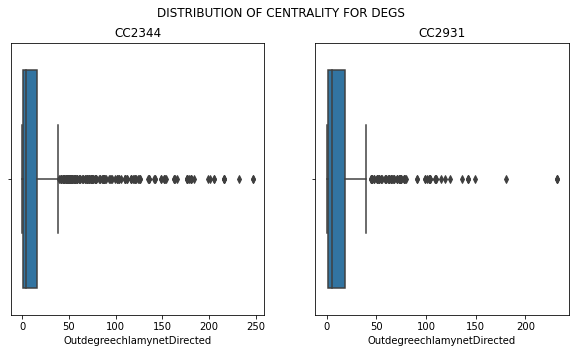

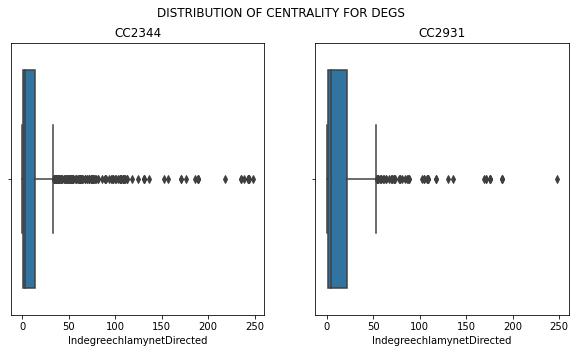

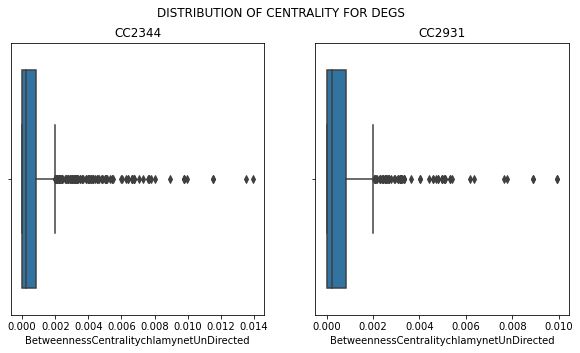

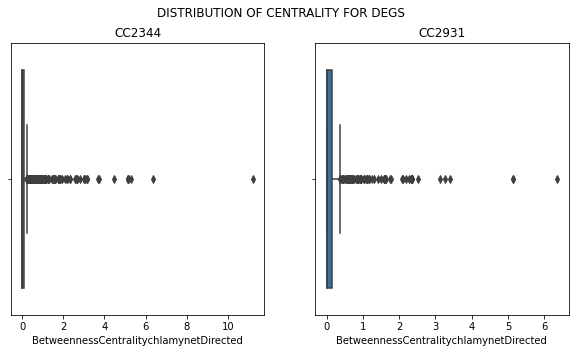

In [22]:
#### LISTS ####
CC2344 = ["CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
total = CC2344 + CC2931
genes = ['CC2344.resSig_L1.genes', 'CC2344.resSig_L2.genes', 'CC2344.resSig_L3.genes', 'CC2344.resSig_L4.genes',
         'CC2344.resSig_L5.genes', 'CC2344.resSig_L6.genes', 'CC2344.resSig_L7.genes', 'CC2344.resSig_L8.genes',
         'CC2344.resSig_L9.genes', 'CC2344.resSig_L10.genes', 'CC2344.resSig_L11.genes', 'CC2344.resSig_L12.genes',
         'CC2344.resSig_L13.genes', 'CC2344.resSig_L14.genes', 'CC2344.resSig_L15.genes', 'CC2931.resSig_L1.genes',
         'CC2931.resSig_L2.genes', 'CC2931.resSig_L3.genes', 'CC2931.resSig_L4.genes', 'CC2931.resSig_L5.genes',
         'CC2931.resSig_L6.genes', 'CC2931.resSig_L7.genes', 'CC2931.resSig_L9.genes', 'CC2931.resSig_L10.genes',
         'CC2931.resSig_L11.genes', 'CC2931.resSig_L13.genes', 'CC2931.resSig_L14.genes', 'CC2931.resSig_L15.genes']
dic = {genes[i]:total[i] for i in range(len(genes))}
centrality_list = ['OutdegreechlamynetUnDirected', 'IndegreechlamynetUnDirected', 'OutdegreechlamynetDirected', 'IndegreechlamynetDirected', 'BetweennessCentralitychlamynetUnDirected', 'BetweennessCentralitychlamynetDirected']

#### ISOLATING THE CENTRALITY OF DEGS ####
DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv', delimiter = ',')
DEGs = DEGs.reset_index()
DEGs = pd.melt(DEGs, id_vars = 'index', value_vars = DEGs.columns[1:])
DEGs = DEGs.dropna()

for i in list(DEGs.index.values):
    DEGs.at[i, 'sample'] = dic[DEGs.at[i, 'variable']]

CC2344_DEGs = DEGs.loc[DEGs['sample'].isin(CC2344)]
CC2931_DEGs = DEGs.loc[DEGs['sample'].isin(CC2931)]
    
CC2344_subset = CC2344_gene_network.loc[CC2344_DEGs['value'].values.tolist()]
CC2344_DEGs = pd.concat([CC2344_DEGs.set_index('value'), CC2344_subset], axis = 1)

CC2931_subset = CC2931_gene_network.loc[CC2931_DEGs['value'].values.tolist()]
CC2931_DEGs = pd.concat([CC2931_DEGs.set_index('value'), CC2931_subset], axis = 1)

centrality_results = pd.DataFrame(index = centrality_list, columns = ['pval', 'CC2344_iqr', 'CC2931_iqr'])

for i in centrality_list:
    stat, p = mannwhitneyu(CC2344_DEGs[i].values.tolist(), CC2931_DEGs[i].values.tolist())
    centrality_results.at[i, 'pval'] =  p
    centrality_results.at[i, 'CC2344_iqr'] = iqr(CC2344_DEGs[i].values.tolist())
    centrality_results.at[i, 'CC2931_iqr'] = iqr(CC2931_DEGs[i].values.tolist())
    fig, axes = plt.subplots(1, 2, figsize = (10, 5))
    sns.boxplot(ax = axes[0], data = CC2344_DEGs, x = i)
    sns.boxplot(ax = axes[1], data = CC2931_DEGs, x = i)
    axes[0].set_title('CC2344')
    axes[1].set_title('CC2931')
    axes[0].set_xlabel(i)
    axes[1].set_xlabel(i)
    fig.suptitle('DISTRIBUTION OF CENTRALITY FOR DEGS')
    fig.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/distribution_' + i + '_vs_degs.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### NULL HYPOTHESIS ####
select_columns = CC2931_gene_network.columns[5:11]
simulated_degs_results = pd.DataFrame(index = [i for i in range(1000)])
for i in range(1000):
    for a in select_columns:
        genes = np.random.choice(list(CC2344_gene_network.index.values), len(CC2344_DEGs), replace = True)
        simulated_degs = CC2344_gene_network.loc[genes]
        simulated_degs = simulated_degs.dropna()
        simulated_degs_results.at[i, 'CC2344_' + a + '_median'] = simulated_degs[a].median()
        stat, p = mannwhitneyu(simulated_degs[a].values.tolist(), CC2344_DEGs[a].values.tolist())
        if p < 0.05:
            simulated_degs_results.at[i, 'CC2344_' + a + '_pval'] = 'Null rejected'
        else:
            simulated_degs_results.at[i, 'CC2344_' + a + '_pval'] = 'Null not rejected'
        simulated_degs_results['CC2344_observed_' + a + '_median'] = CC2344_DEGs[a].median()

        genes = np.random.choice(list(CC2931_gene_network.index.values), len(CC2931_DEGs), replace = True)
        simulated_degs = CC2931_gene_network.loc[genes]
        simulated_degs = simulated_degs.dropna()
        simulated_degs_results.at[i, 'CC2931_' + a + '_median'] = simulated_degs[a].median()
        stat, p = mannwhitneyu(simulated_degs[a].values.tolist(), CC2931_DEGs[a].values.tolist())
        if p < 0.05:
            simulated_degs_results.at[i, 'CC2931_' + a + '_pval'] = 'Null rejected'
        else:
            simulated_degs_results.at[i, 'CC2931_' + a + '_pval'] = 'Null not rejected'
        simulated_degs_results['CC2931_observed_' + a + '_median'] = CC2931_DEGs[a].median()

In [27]:
simulated_degs_results

,CC2344_BetweennessCentralitychlamynetUnDirected_median,CC2344_BetweennessCentralitychlamynetUnDirected_pval,CC2344_observed_BetweennessCentralitychlamynetUnDirected_median,CC2931_BetweennessCentralitychlamynetUnDirected_median,CC2931_BetweennessCentralitychlamynetUnDirected_pval,CC2931_observed_BetweennessCentralitychlamynetUnDirected_median,CC2344_OutdegreechlamynetUnDirected_median,CC2344_OutdegreechlamynetUnDirected_pval,CC2344_observed_OutdegreechlamynetUnDirected_median,CC2931_OutdegreechlamynetUnDirected_median,...,CC2344_observed_OutdegreechlamynetDirected_median,CC2931_OutdegreechlamynetDirected_median,CC2931_OutdegreechlamynetDirected_pval,CC2931_observed_OutdegreechlamynetDirected_median,CC2344_IndegreechlamynetDirected_median,CC2344_IndegreechlamynetDirected_pval,CC2344_observed_IndegreechlamynetDirected_median,CC2931_IndegreechlamynetDirected_median,CC2931_IndegreechlamynetDirected_pval,CC2931_observed_IndegreechlamynetDirected_median
0,0.000227,Null rejected,0.000237,0.000237,Null rejected,0.000237,4.0,Null rejected,4.0,4.0,...,4.0,4.0,Null rejected,5.0,4.0,Null rejected,3.0,4.0,Null rejected,5.0
1,0.000237,Null rejected,0.000237,0.000237,Null rejected,0.000237,4.0,Null rejected,4.0,4.0,...,4.0,5.0,Null rejected,5.0,4.0,Null rejected,3.0,4.0,Null rejected,5.0
2,0.000237,Null rejected,0.000237,0.000240,Null rejected,0.000237,4.0,Null rejected,4.0,4.0,...,4.0,3.5,Null rejected,5.0,4.0,Null rejected,3.0,3.0,Null rejected,5.0
3,0.000237,Null rejected,0.000237,0.000223,Null rejected,0.000237,4.0,Null rejected,4.0,4.0,...,4.0,4.0,Null rejected,5.0,4.0,Null rejected,3.0,4.0,Null rejected,5.0
4,0.000237,Null rejected,0.000237,0.000237,Null rejected,0.000237,4.0,Null rejected,4.0,4.0,...,4.0,4.0,Null rejected,5.0,4.0,Null rejected,3.0,3.0,Null rejected,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000237,Null rejected,0.000237,0.000237,Null rejected,0.000237,4.0,Null rejected,4.0,4.0,...,4.0,4.0,Null rejected,5.0,4.0,Null rejected,3.0,4.0,Null rejected,5.0
996,0.000223,Null rejected,0.000237,0.000238,Null rejected,0.000237,4.0,Null rejected,4.0,4.0,...,4.0,5.0,Null rejected,5.0,4.0,Null rejected,3.0,3.0,Null rejected,5.0
997,0.000237,Null rejected,0.000237,0.000187,Null rejected,0.000237,3.0,Null rejected,4.0,4.0,...,4.0,3.0,Null rejected,5.0,4.0,Null rejected,3.0,4.0,Null rejected,5.0
998,0.000237,Null rejected,0.000237,0.000239,Null rejected,0.000237,3.0,Null rejected,4.0,3.0,...,4.0,3.0,Null rejected,5.0,4.0,Null rejected,3.0,4.0,Null rejected,5.0


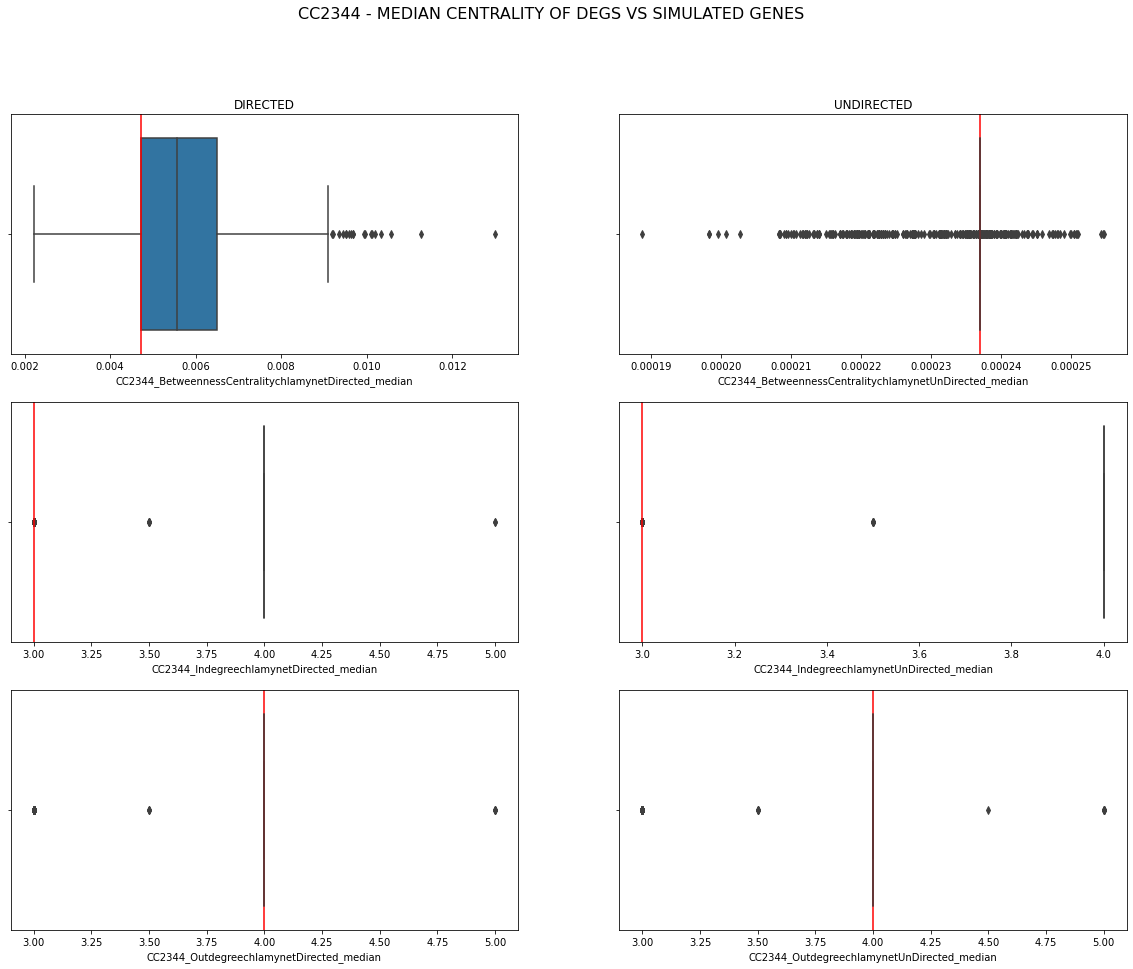

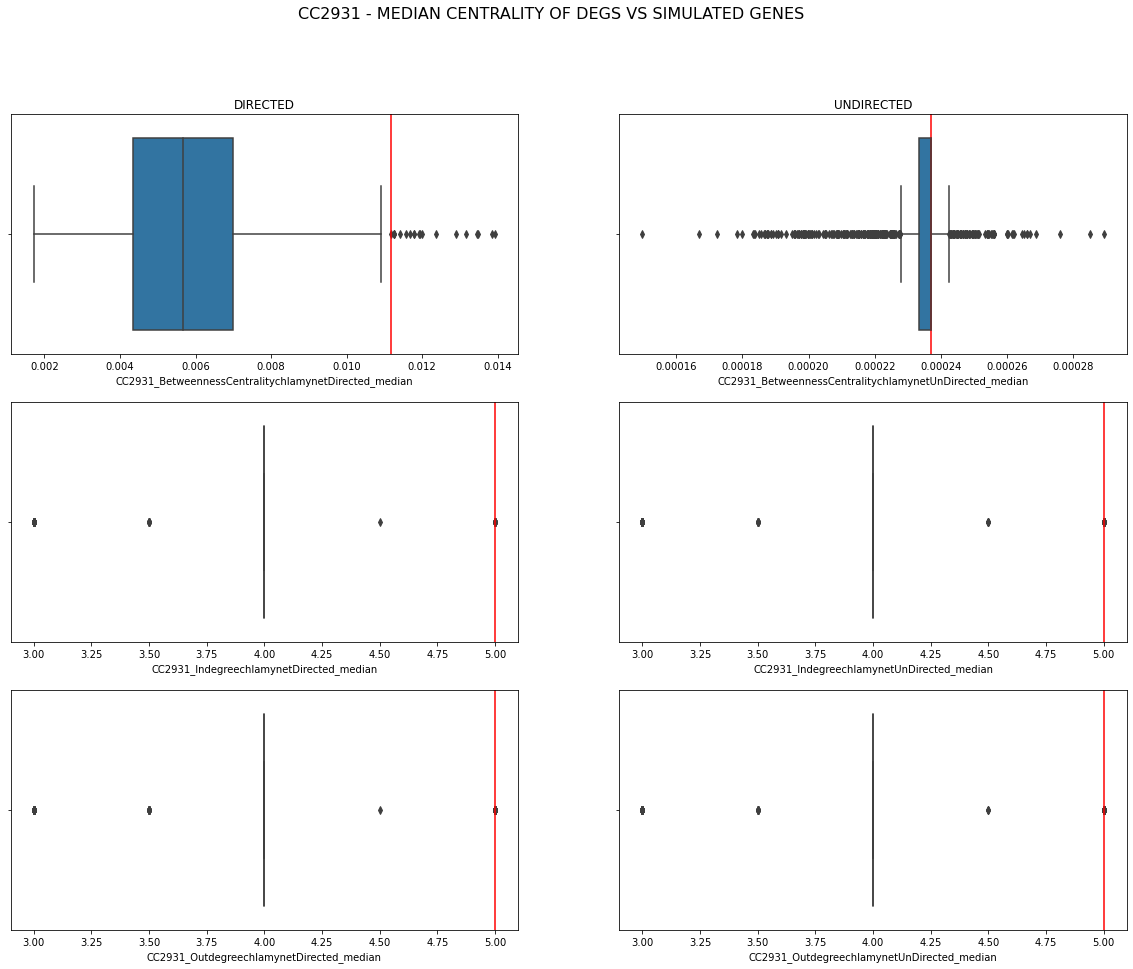

In [23]:
#### PLOTS ####
###############

#### CC2344 ####
fig, axes = plt.subplots(3, 2, figsize = (20, 15))
fig.suptitle('CC2344 - MEDIAN CENTRALITY OF DEGS VS SIMULATED GENES', fontsize=16)
sns.boxplot(ax = axes[0,0], x = simulated_degs_results['CC2344_BetweennessCentralitychlamynetDirected_median'])
axes[0,0].axvline(CC2344_DEGs['BetweennessCentralitychlamynetDirected'].median(), color = 'red')
axes[0,0].set_title('DIRECTED')
sns.boxplot(ax = axes[0,1], x = simulated_degs_results['CC2344_BetweennessCentralitychlamynetUnDirected_median'])
axes[0,1].axvline(CC2344_DEGs['BetweennessCentralitychlamynetUnDirected'].median(), color = 'red')
axes[0,1].set_title('UNDIRECTED')
sns.boxplot(ax = axes[1,0], x = simulated_degs_results['CC2344_IndegreechlamynetDirected_median'])
axes[1,0].axvline(CC2344_DEGs['IndegreechlamynetDirected'].median(), color = 'red')
sns.boxplot(ax = axes[1,1], x = simulated_degs_results['CC2344_IndegreechlamynetUnDirected_median'])
axes[1,1].axvline(CC2344_DEGs['IndegreechlamynetUnDirected'].median(), color = 'red')
sns.boxplot(ax = axes[2,0], x = simulated_degs_results['CC2344_OutdegreechlamynetDirected_median'])
axes[2,0].axvline(CC2344_DEGs['OutdegreechlamynetDirected'].median(), color = 'red')
sns.boxplot(ax = axes[2,1], x = simulated_degs_results['CC2344_OutdegreechlamynetUnDirected_median'])
axes[2,1].axvline(CC2344_DEGs['OutdegreechlamynetUnDirected'].median(), color = 'red')
fig.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2344_median_centrality_degs_vs_simulated_genes.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

#### CC2931 ####
fig, axes = plt.subplots(3, 2, figsize = (20, 15))
fig.suptitle('CC2931 - MEDIAN CENTRALITY OF DEGS VS SIMULATED GENES', fontsize=16)
sns.boxplot(ax = axes[0,0], x = simulated_degs_results['CC2931_BetweennessCentralitychlamynetDirected_median'])
axes[0,0].axvline(CC2931_DEGs['BetweennessCentralitychlamynetDirected'].median(), color = 'red')
axes[0,0].set_title('DIRECTED')
sns.boxplot(ax = axes[0,1], x = simulated_degs_results['CC2931_BetweennessCentralitychlamynetUnDirected_median'])
axes[0,1].axvline(CC2931_DEGs['BetweennessCentralitychlamynetUnDirected'].median(), color = 'red')
axes[0,1].set_title('UNDIRECTED')
sns.boxplot(ax = axes[1,0], x = simulated_degs_results['CC2931_IndegreechlamynetDirected_median'])
axes[1,0].axvline(CC2931_DEGs['IndegreechlamynetDirected'].median(), color = 'red')
sns.boxplot(ax = axes[1,1], x = simulated_degs_results['CC2931_IndegreechlamynetUnDirected_median'])
axes[1,1].axvline(CC2931_DEGs['IndegreechlamynetUnDirected'].median(), color = 'red')
sns.boxplot(ax = axes[2,0], x = simulated_degs_results['CC2931_OutdegreechlamynetDirected_median'])
axes[2,0].axvline(CC2931_DEGs['OutdegreechlamynetDirected'].median(), color = 'red')
sns.boxplot(ax = axes[2,1], x = simulated_degs_results['CC2931_OutdegreechlamynetUnDirected_median'])
axes[2,1].axvline(CC2931_DEGs['OutdegreechlamynetUnDirected'].median(), color = 'red')
fig.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/CC2931_median_centrality_degs_vs_simulated_genes.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### LOG2FOLD VS CENTRALITY

In [29]:
#### PLOTTING LOG2FOLD SUM OF MEAN/MEDIAN VS CENTRALITY ####
############################################################

#### REORDERED GROUPS ####
outdegree_grouplist
indegree_grouplist
undirected_centrality_grouplist
directed_centrality_grouplist

#### CREATING DATAFRAMES ####
outdegree_L2F = pd.DataFrame(index = range(len(outdegree_grouplist)), columns = ['CC2344_mean', 'CC2344_median', 'CC2344_abs_mean', 'CC2344_abs_median', 'CC2931_mean', 'CC2931_median', 'CC2931_abs_mean', 'CC2931_abs_median'])
undirected_outdegree_L2F = pd.DataFrame(index = range(len(outdegree_grouplist)), columns = ['CC2344_mean', 'CC2344_median', 'CC2344_abs_mean', 'CC2344_abs_median', 'CC2931_mean', 'CC2931_median', 'CC2931_abs_mean', 'CC2931_abs_median'])
indegree_L2F = pd.DataFrame(index = range(len(indegree_grouplist)), columns = ['CC2344_mean', 'CC2344_median', 'CC2344_abs_mean', 'CC2344_abs_median', 'CC2931_mean', 'CC2931_median', 'CC2931_abs_mean', 'CC2931_abs_median'])
undirected_indegree_L2F = pd.DataFrame(index = range(len(indegree_grouplist)), columns = ['CC2344_mean', 'CC2344_median', 'CC2344_abs_mean', 'CC2344_abs_median', 'CC2931_mean', 'CC2931_median', 'CC2931_abs_mean', 'CC2931_abs_median'])
undirected_centrality_L2F = pd.DataFrame(index = range(len(undirected_centrality_grouplist)), columns = ['CC2344_mean', 'CC2344_median', 'CC2344_abs_mean', 'CC2344_abs_median', 'CC2931_mean', 'CC2931_median', 'CC2931_abs_mean', 'CC2931_abs_median'])
directed_centrality_L2F = pd.DataFrame(index = range(len(directed_centrality_grouplist)), columns = ['CC2344_mean', 'CC2344_median', 'CC2344_abs_mean', 'CC2344_abs_median', 'CC2931_mean', 'CC2931_median', 'CC2931_abs_mean', 'CC2931_abs_median'])
    
for i in range(len(outdegree_grouplist)):
    grouped = CC2344_gene_network.groupby('OutdegreechlamynetDirected_Group')
    section = grouped.get_group(outdegree_grouplist[i])
    outdegree_L2F.at[i, 'CC2344_mean'] = section['mean'].values.tolist()
    outdegree_L2F.at[i, 'CC2344_median'] = section['median'].values.tolist()
    outdegree_L2F.at[i, 'CC2344_abs_mean'] = section['abs_mean'].values.tolist()
    outdegree_L2F.at[i, 'CC2344_abs_median'] = section['abs_median'].values.tolist()
    outdegree_L2F.at[i, 'group'] = outdegree_grouplist[i]

    grouped = CC2931_gene_network.groupby('OutdegreechlamynetDirected_Group')
    section = grouped.get_group(outdegree_grouplist[i])
    outdegree_L2F.at[i, 'CC2931_mean'] = section['mean'].values.tolist()
    outdegree_L2F.at[i, 'CC2931_median'] = section['median'].values.tolist()
    outdegree_L2F.at[i, 'CC2931_abs_mean'] = section['abs_mean'].values.tolist()
    outdegree_L2F.at[i, 'CC2931_abs_median'] = section['abs_median'].values.tolist()
    
for i in range(len(outdegree_grouplist)):
    grouped = CC2344_gene_network.groupby('OutdegreechlamynetUnDirected_Group')
    section = grouped.get_group(outdegree_grouplist[i])
    undirected_outdegree_L2F.at[i, 'CC2344_mean'] = section['mean'].values.tolist()
    undirected_outdegree_L2F.at[i, 'CC2344_median'] = section['median'].values.tolist()
    undirected_outdegree_L2F.at[i, 'CC2344_abs_mean'] = section['abs_mean'].values.tolist()
    undirected_outdegree_L2F.at[i, 'CC2344_abs_median'] = section['abs_median'].values.tolist()
    undirected_outdegree_L2F.at[i, 'group'] = outdegree_grouplist[i]

    grouped = CC2931_gene_network.groupby('OutdegreechlamynetUnDirected_Group')
    section = grouped.get_group(outdegree_grouplist[i])
    undirected_outdegree_L2F.at[i, 'CC2931_mean'] = section['mean'].values.tolist()
    undirected_outdegree_L2F.at[i, 'CC2931_median'] = section['median'].values.tolist()
    undirected_outdegree_L2F.at[i, 'CC2931_abs_mean'] = section['abs_mean'].values.tolist()
    undirected_outdegree_L2F.at[i, 'CC2931_abs_median'] = section['abs_median'].values.tolist()
        
for i in range(len(indegree_grouplist)):
    grouped = CC2344_gene_network.groupby('IndegreechlamynetDirected_Group')
    section = grouped.get_group(indegree_grouplist[i])
    indegree_L2F.at[i, 'CC2344_mean'] = section['mean'].values.tolist()
    indegree_L2F.at[i, 'CC2344_median'] = section['median'].values.tolist()
    indegree_L2F.at[i, 'CC2344_abs_mean'] = section['abs_mean'].values.tolist()
    indegree_L2F.at[i, 'CC2344_abs_median'] = section['abs_median'].values.tolist()
    indegree_L2F.at[i, 'group'] = indegree_grouplist[i]

    grouped = CC2931_gene_network.groupby('IndegreechlamynetDirected_Group')
    section = grouped.get_group(indegree_grouplist[i])
    indegree_L2F.at[i, 'CC2931_mean'] = section['mean'].values.tolist()
    indegree_L2F.at[i, 'CC2931_median'] = section['median'].values.tolist()
    indegree_L2F.at[i, 'CC2931_abs_mean'] = section['abs_mean'].values.tolist()
    indegree_L2F.at[i, 'CC2931_abs_median'] = section['abs_median'].values.tolist()

for i in range(len(indegree_grouplist)):
    grouped = CC2344_gene_network.groupby('IndegreechlamynetUnDirected_Group')
    section = grouped.get_group(indegree_grouplist[i])
    undirected_indegree_L2F.at[i, 'CC2344_mean'] = section['mean'].values.tolist()
    undirected_indegree_L2F.at[i, 'CC2344_median'] = section['median'].values.tolist()
    undirected_indegree_L2F.at[i, 'CC2344_abs_mean'] = section['abs_mean'].values.tolist()
    undirected_indegree_L2F.at[i, 'CC2344_abs_median'] = section['abs_median'].values.tolist()
    undirected_indegree_L2F.at[i, 'group'] = indegree_grouplist[i]

    grouped = CC2931_gene_network.groupby('IndegreechlamynetUnDirected_Group')
    section = grouped.get_group(indegree_grouplist[i])
    undirected_indegree_L2F.at[i, 'CC2931_mean'] = section['mean'].values.tolist()
    undirected_indegree_L2F.at[i, 'CC2931_median'] = section['median'].values.tolist()
    undirected_indegree_L2F.at[i, 'CC2931_abs_mean'] = section['abs_mean'].values.tolist()
    undirected_indegree_L2F.at[i, 'CC2931_abs_median'] = section['abs_median'].values.tolist()

for i in range(len(undirected_centrality_grouplist)):
    grouped = CC2344_gene_network.groupby('BetweennessCentralitychlamynetUnDirected_Group')
    section = grouped.get_group(undirected_centrality_grouplist[i])
    undirected_centrality_L2F.at[i, 'CC2344_mean'] = section['mean'].values.tolist()
    undirected_centrality_L2F.at[i, 'CC2344_median'] = section['median'].values.tolist()
    undirected_centrality_L2F.at[i, 'CC2344_abs_mean'] = section['abs_mean'].values.tolist()
    undirected_centrality_L2F.at[i, 'CC2344_abs_median'] = section['abs_median'].values.tolist()
    undirected_centrality_L2F.at[i, 'group'] = undirected_centrality_grouplist[i]

    grouped = CC2931_gene_network.groupby('BetweennessCentralitychlamynetUnDirected_Group')
    section = grouped.get_group(undirected_centrality_grouplist[i])
    undirected_centrality_L2F.at[i, 'CC2931_mean'] = section['mean'].values.tolist()
    undirected_centrality_L2F.at[i, 'CC2931_median'] = section['median'].values.tolist()
    undirected_centrality_L2F.at[i, 'CC2931_abs_mean'] = section['abs_mean'].values.tolist()
    undirected_centrality_L2F.at[i, 'CC2931_abs_median'] = section['abs_median'].values.tolist()

for i in range(len(directed_centrality_grouplist)):
    grouped = CC2344_gene_network.groupby('BetweennessCentralitychlamynetDirected_Group')
    section = grouped.get_group(directed_centrality_grouplist[i])
    directed_centrality_L2F.at[i, 'CC2344_mean'] = section['mean'].values.tolist()
    directed_centrality_L2F.at[i, 'CC2344_median'] = section['median'].values.tolist()
    directed_centrality_L2F.at[i, 'CC2344_abs_mean'] = section['abs_mean'].values.tolist()
    directed_centrality_L2F.at[i, 'CC2344_abs_median'] = section['abs_median'].values.tolist()
    directed_centrality_L2F.at[i, 'group'] = directed_centrality_grouplist[i]

    grouped = CC2931_gene_network.groupby('BetweennessCentralitychlamynetDirected_Group')
    section = grouped.get_group(directed_centrality_grouplist[i])
    directed_centrality_L2F.at[i, 'CC2931_mean'] = section['mean'].sum()
    directed_centrality_L2F.at[i, 'CC2931_median'] = section['median'].sum()
    directed_centrality_L2F.at[i, 'CC2931_abs_mean'] = section['abs_mean'].sum()
    directed_centrality_L2F.at[i, 'CC2931_abs_median'] = section['abs_median'].sum()

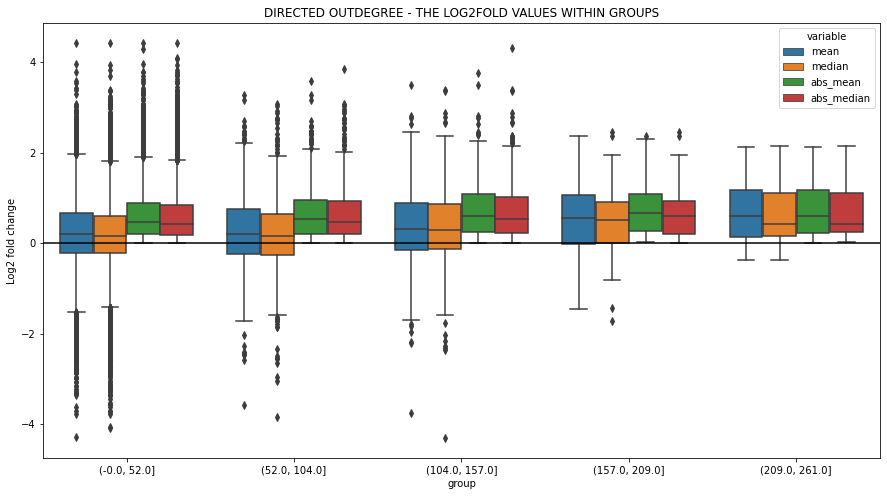

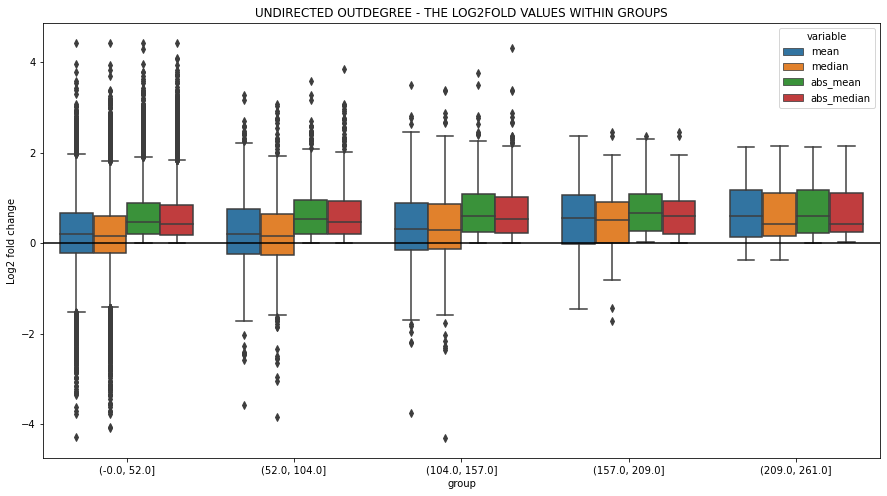

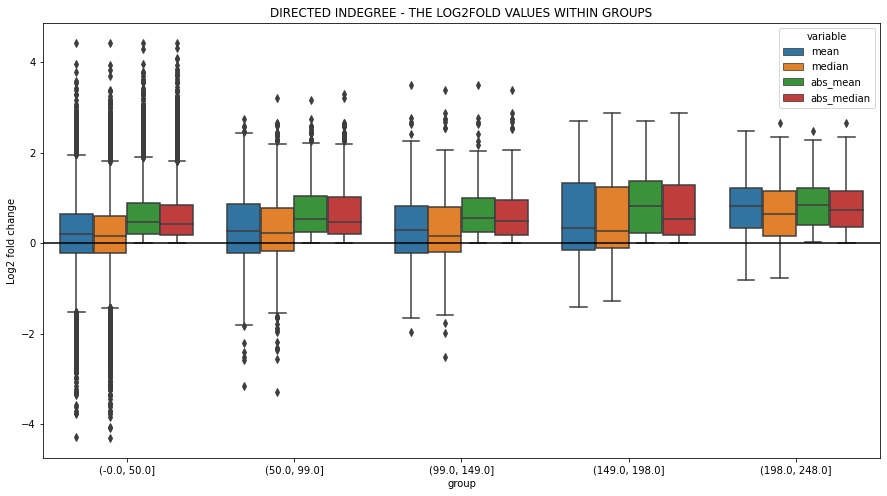

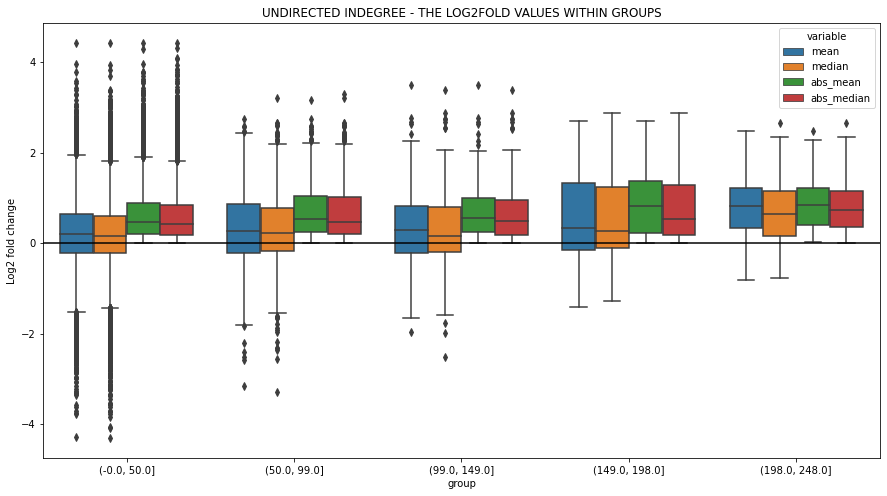

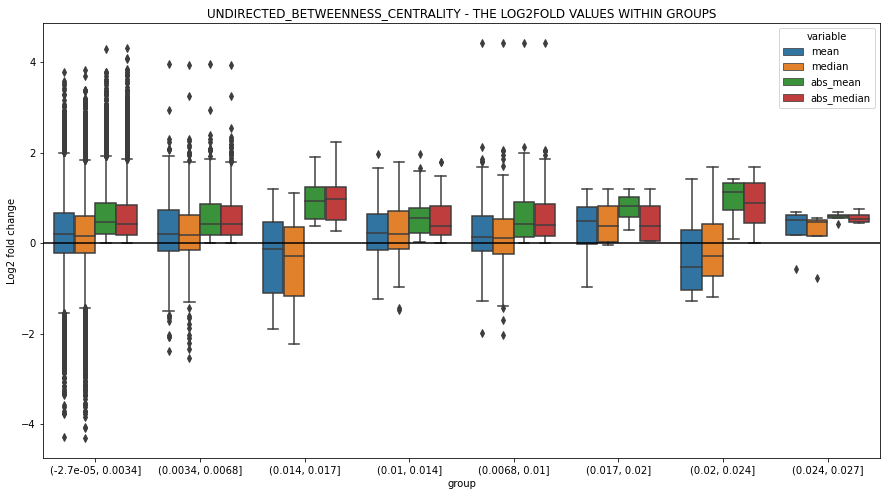

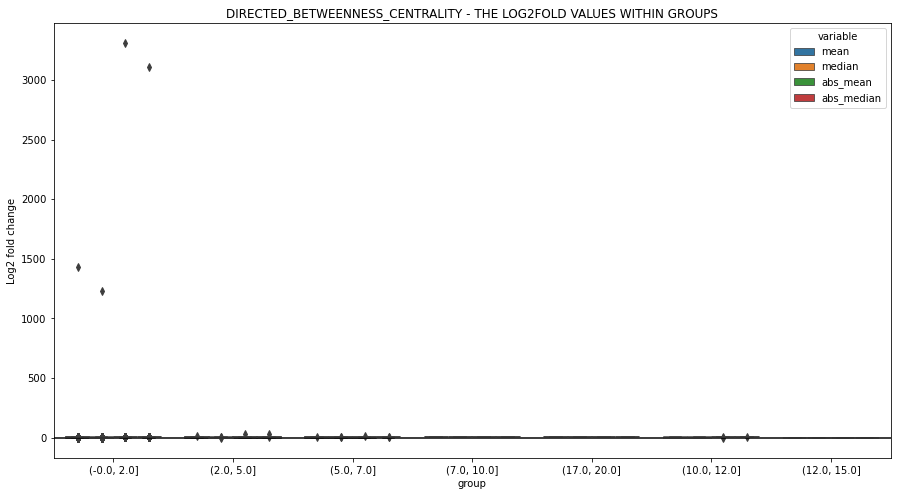

In [30]:
#### CHANGING DATAFRAME TO LONGFORM ####
outdegree_L2F = pd.melt(outdegree_L2F, id_vars = 'group', value_vars = ['CC2344_mean', 'CC2344_median', 'CC2344_abs_mean', 'CC2344_abs_median', 'CC2931_mean', 'CC2931_median', 'CC2931_abs_mean', 'CC2931_abs_median'])
undirected_outdegree_L2F = pd.melt(undirected_outdegree_L2F, id_vars = 'group', value_vars = ['CC2344_mean', 'CC2344_median', 'CC2344_abs_mean', 'CC2344_abs_median', 'CC2931_mean', 'CC2931_median', 'CC2931_abs_mean', 'CC2931_abs_median'])
indegree_L2F = pd.melt(indegree_L2F, id_vars = 'group', value_vars = ['CC2344_mean', 'CC2344_median', 'CC2344_abs_mean', 'CC2344_abs_median', 'CC2931_mean', 'CC2931_median', 'CC2931_abs_mean', 'CC2931_abs_median'])
undirected_indegree_L2F = pd.melt(undirected_indegree_L2F, id_vars = 'group', value_vars = ['CC2344_mean', 'CC2344_median', 'CC2344_abs_mean', 'CC2344_abs_median', 'CC2931_mean', 'CC2931_median', 'CC2931_abs_mean', 'CC2931_abs_median'])
directed_centrality_L2F = pd.melt(directed_centrality_L2F, id_vars = 'group', value_vars = ['CC2344_mean', 'CC2344_median', 'CC2344_abs_mean', 'CC2344_abs_median', 'CC2931_mean', 'CC2931_median', 'CC2931_abs_mean', 'CC2931_abs_median'])
undirected_centrality_L2F = pd.melt(undirected_centrality_L2F, id_vars = 'group', value_vars = ['CC2344_mean', 'CC2344_median', 'CC2344_abs_mean', 'CC2344_abs_median', 'CC2931_mean', 'CC2931_median', 'CC2931_abs_mean', 'CC2931_abs_median'])

#### EXPLODING ALL VALUES IN LIST #####
outdegree_L2F = outdegree_L2F.explode('value')
undirected_outdegree_L2F = undirected_outdegree_L2F.explode('value')
indegree_L2F = indegree_L2F.explode('value')
undirected_indegree_L2F = undirected_indegree_L2F.explode('value')
directed_centrality_L2F = directed_centrality_L2F.explode('value')
undirected_centrality_L2F = undirected_centrality_L2F.explode('value')

#### EDITING DATAFRAME TO ISOLATE THE SAMPLE PER VALUE ####
for i in list(outdegree_L2F.index.values):
    if 'CC2344' in outdegree_L2F.at[i, 'variable']:
        outdegree_L2F.at[i, 'sample'] = 'CC2344'
    if 'CC2931' in outdegree_L2F.at[i, 'variable']:
        outdegree_L2F.at[i, 'sample'] = 'CC2931'
outdegree_L2F['variable'] = outdegree_L2F['variable'].replace({'CC2344_':'', 'CC2931_':''}, regex = True)

for i in list(undirected_outdegree_L2F.index.values):
    if 'CC2344' in undirected_outdegree_L2F.at[i, 'variable']:
        undirected_outdegree_L2F.at[i, 'sample'] = 'CC2344'
    if 'CC2931' in undirected_outdegree_L2F.at[i, 'variable']:
        undirected_outdegree_L2F.at[i, 'sample'] = 'CC2931'
undirected_outdegree_L2F['variable'] = undirected_outdegree_L2F['variable'].replace({'CC2344_':'', 'CC2931_':''}, regex = True)

for i in list(indegree_L2F.index.values):
    if 'CC2344' in indegree_L2F.at[i, 'variable']:
        indegree_L2F.at[i, 'sample'] = 'CC2344'
    if 'CC2931' in indegree_L2F.at[i, 'variable']:
        indegree_L2F.at[i, 'sample'] = 'CC2931'
indegree_L2F['variable'] = indegree_L2F['variable'].replace({'CC2344_':'', 'CC2931_':''}, regex = True)

for i in list(undirected_indegree_L2F.index.values):
    if 'CC2344' in undirected_indegree_L2F.at[i, 'variable']:
        undirected_indegree_L2F.at[i, 'sample'] = 'CC2344'
    if 'CC2931' in undirected_indegree_L2F.at[i, 'variable']:
        undirected_indegree_L2F.at[i, 'sample'] = 'CC2931'
undirected_indegree_L2F['variable'] = undirected_indegree_L2F['variable'].replace({'CC2344_':'', 'CC2931_':''}, regex = True)

for i in list(undirected_centrality_L2F.index.values):
    if 'CC2344' in undirected_centrality_L2F.at[i, 'variable']:
        undirected_centrality_L2F.at[i, 'sample'] = 'CC2344'
    if 'CC2931' in undirected_centrality_L2F.at[i, 'variable']:
        undirected_centrality_L2F.at[i, 'sample'] = 'CC2931'
undirected_centrality_L2F['variable'] = undirected_centrality_L2F['variable'].replace({'CC2344_':'', 'CC2931_':''}, regex = True)

for i in list(directed_centrality_L2F.index.values):
    if 'CC2344' in directed_centrality_L2F.at[i, 'variable']:
        directed_centrality_L2F.at[i, 'sample'] = 'CC2344'
    if 'CC2931' in directed_centrality_L2F.at[i, 'variable']:
        directed_centrality_L2F.at[i, 'sample'] = 'CC2931'
directed_centrality_L2F['variable'] = directed_centrality_L2F['variable'].replace({'CC2344_':'', 'CC2931_':''}, regex = True)

#### PLOTS ####
plt.figure(figsize = (15,8))
ax = sns.boxplot(data = outdegree_L2F, x = 'group', y = 'value', hue = 'variable')
plt.axhline(0, color = 'black')
plt.title('DIRECTED OUTDEGREE - THE LOG2FOLD VALUES WITHIN GROUPS')
plt.ylabel('Log2 fold change')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/mean_median_L2F_directed_outdegree.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure(figsize = (15,8))
ax = sns.boxplot(data = undirected_outdegree_L2F, x = 'group', y = 'value', hue = 'variable')
plt.axhline(0, color = 'black')
plt.title('UNDIRECTED OUTDEGREE - THE LOG2FOLD VALUES WITHIN GROUPS')
plt.ylabel('Log2 fold change')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/mean_median_L2F_undirected_outdegree.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure(figsize = (15,8))
ax = sns.boxplot(data = indegree_L2F, x = 'group', y = 'value', hue = 'variable')
plt.axhline(0, color = 'black')
plt.title('DIRECTED INDEGREE - THE LOG2FOLD VALUES WITHIN GROUPS')
plt.ylabel('Log2 fold change')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/mean_median_L2F_directed_indegree.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure(figsize = (15,8))
ax = sns.boxplot(data = undirected_indegree_L2F, x = 'group', y = 'value', hue = 'variable')
plt.axhline(0, color = 'black')
plt.title('UNDIRECTED INDEGREE - THE LOG2FOLD VALUES WITHIN GROUPS')
plt.ylabel('Log2 fold change')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/mean_median_L2F_undirected_indegree.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure(figsize = (15,8))
ax = sns.boxplot(data = undirected_centrality_L2F, x = 'group', y = 'value', hue = 'variable')
plt.axhline(0, color = 'black')
plt.title('UNDIRECTED_BETWEENNESS_CENTRALITY - THE LOG2FOLD VALUES WITHIN GROUPS')
plt.ylabel('Log2 fold change')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/mean_median_L2F_undirected_centrality.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

plt.figure(figsize = (15,8))
ax = sns.boxplot(data = directed_centrality_L2F, x = 'group', y = 'value', hue = 'variable')
plt.axhline(0, color = 'black')
plt.title('DIRECTED_BETWEENNESS_CENTRALITY - THE LOG2FOLD VALUES WITHIN GROUPS')
plt.ylabel('Log2 fold change')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/centrality/mean_median_L2F_directed_centrality.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

<IPython.core.display.Javascript object>


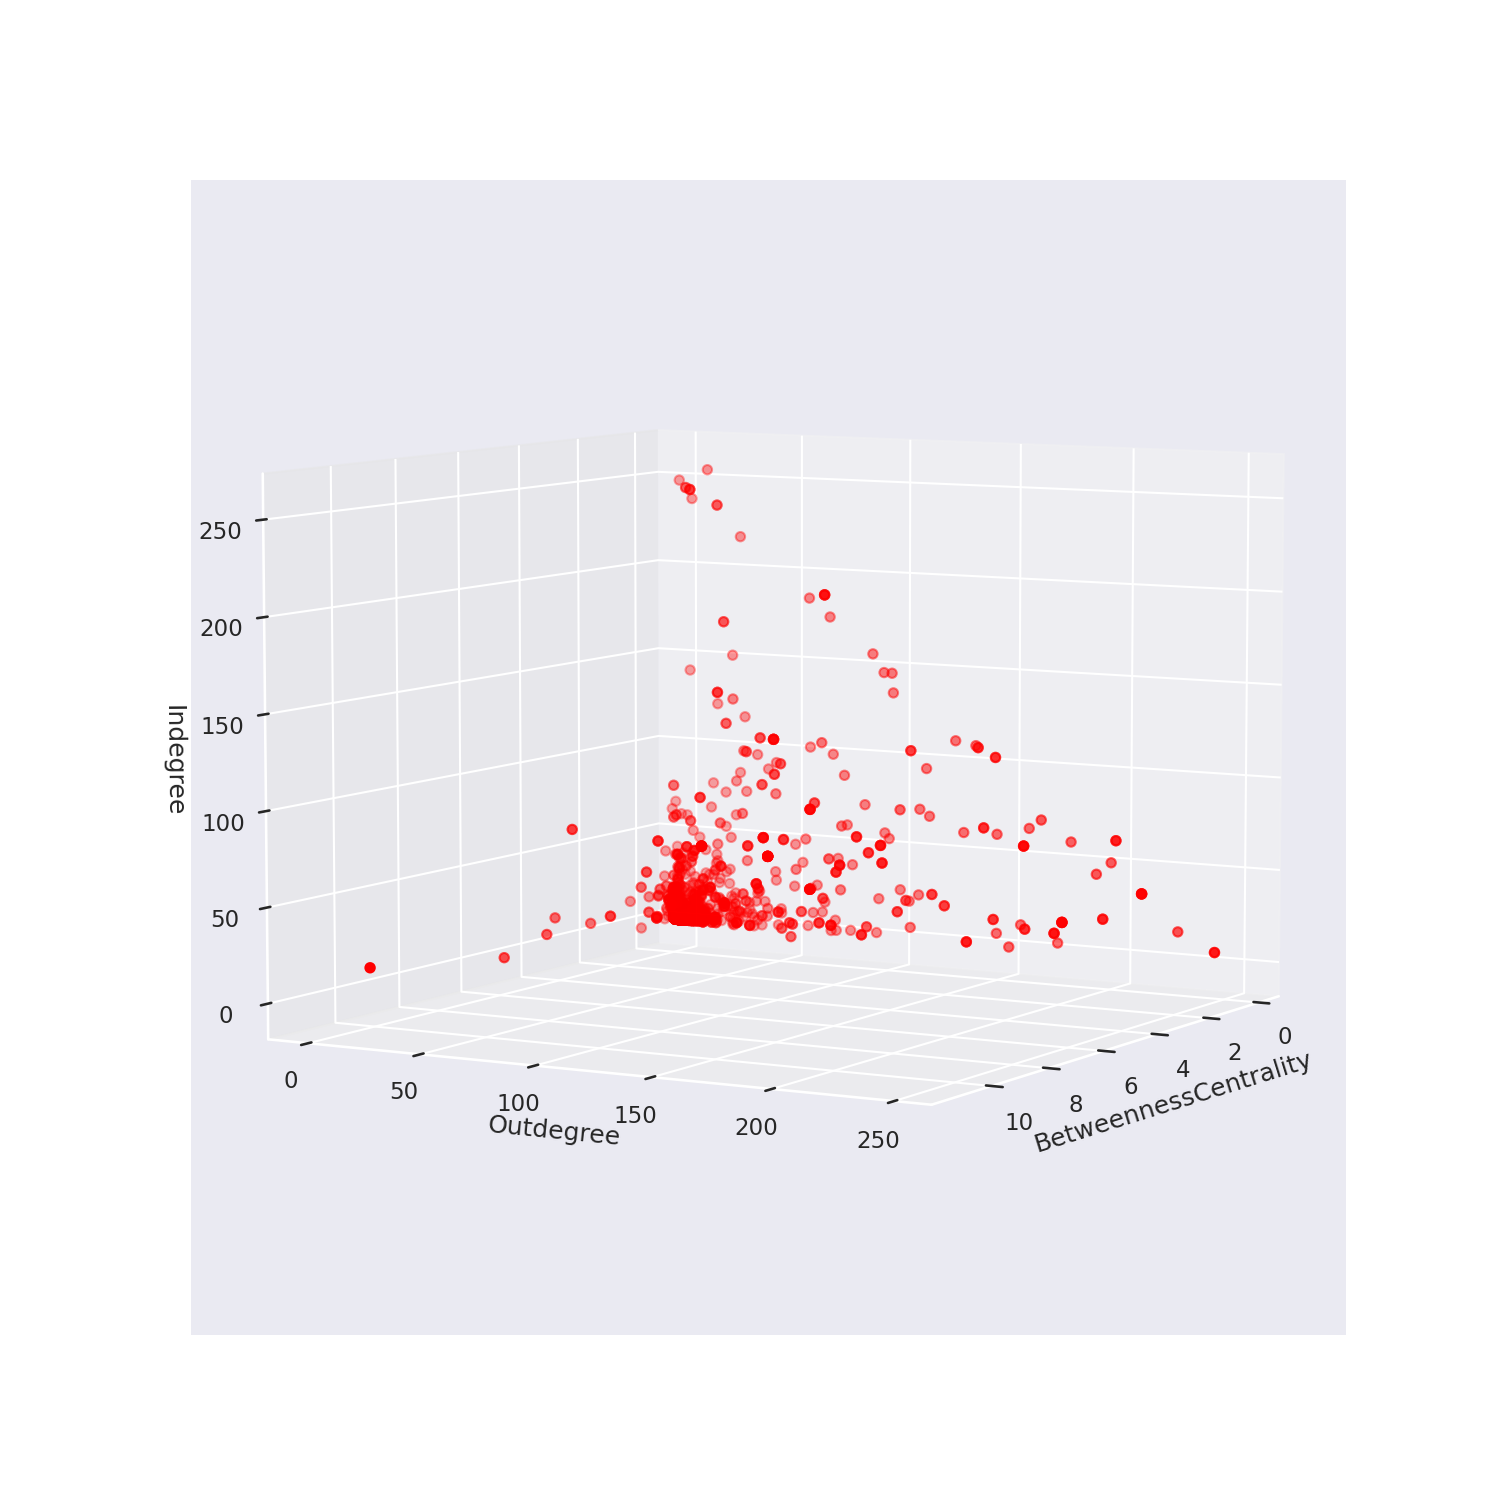

In [80]:
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

%matplotlib notebook

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection = '3d')

x = CC2344_DEGs['BetweennessCentralitychlamynetDirected']
y = CC2344_DEGs['OutdegreechlamynetDirected']
z = CC2344_DEGs['IndegreechlamynetDirected']

ax.set_xlabel("BetweennessCentrality")
ax.set_ylabel("Outdegree")
ax.set_zlabel("Indegree")

ax.scatter(x, y, z, color = 'red')

plt.show()